$$DME  ~Predictive ~Analytics ~Report$$
*_DME Team 5_*

The notebook aims to build predictive models to make prediction of customers who are mostly likely to purchase tires of DME, a tire retailer. Also, we try to explore possible reasons why customers purchase tires at DME. The framework and thread of analysis is as follows.
___

**Framework**

**1. Data Loading**

**2. Exploratory Data Analysis**

**3. Feature Engineering**

**4. Model Selection**

**5. Interpretation of Predictive Model**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
from IPython.display import display

%matplotlib inline
warnings.simplefilter(action="ignore",category=FutureWarning)
pd.set_option('mode.chained_assignment', None)

# Data Loading

Load data of tier buyer and data of non-buyer into the notebook. Then, concatenate the two datasets and drop columns that do not coexist in the two datasets.

After simply cleaning the dataset, we take a quick look at the data.

In [2]:
data1 = pd.read_excel("/Users/ray/Desktop/Marketing Analytics Project/fall b/data/DME Tire Purchase Data.xlsx")
data2 = pd.read_excel("/Users/ray/Desktop/Marketing Analytics Project/fall b/data/DME Non Purchaser Data.xlsx")

In [3]:
data2_ = data2.drop(["Sequence_Datamart","SegmentName","OriginalOrder"],axis=1)
# add one columns to indicate buyers who did not purchase tires
data2_["purchase"] = np.zeros(len(data2_))

data2_cols = data2_.columns.tolist()
mark = data1.columns.isin(data2_cols)
data1_co = data1[data1.columns[mark]]
# add one columns to indicate tire buyers
data1_co["purchase"] = np.ones(len(data1_co))

# concatenate the two datasets
data = pd.concat([data1_co,data2_]).drop(["VIN","Last Owner Titling State"],axis=1)
data.head()

Year        Make                 Model Vehicle Purchase Date  \
0  2011.0         KIA            SORENTO SX            2017-09-28   
1  2014.0        FORD        ECONOLINE E250            2014-04-19   
2  2016.0   CHEVROLET              CRUZE LS            2019-08-21   
3  2011.0      NISSAN  TITAN S/SV/SL/PRO-4X            2018-08-22   
4  2014.0  LAND ROVER               LR2 HSE            2019-11-26   

   Estimated Current Odometer  Number Of Owners  \
0                     79616.0               3.0   
1                    145140.0               1.0   
2                    156044.0               2.0   
3                    152092.0               4.0   
4                     47900.0               3.0   

   Last Owner Length Of Ownership In Days  Lienholder   Retail  Wholesale  \
0                                  1342.0       False  11220.0     6610.0   
1                                  2600.0       False  15430.0    10530.0   
2                                   650.0       False   9440.0     5090.0   
3                                  1014.0        True  18570.0    10940.0   
4                                   553.0       False  19320.0    12960.0   

   ...  Number of persons in Household Number of Adults in Household  \
0  ...                             NaN                           NaN   
1  ...                      One person                     One adult   
2  ...                      One person                           NaN   
3  ...                   Three persons                  Three adults   
4  ...                     Two persons                    Two adults   

  Median Income  Length of Residence Presence of Children Wealth Rating  \
0           NaN                  NaN                  NaN           NaN   
1          69.0                  NaN     Children present    9th decile   
2           NaN                  NaN                  NaN    2nd decile   
3          38.0                  9.0     Children present    9th decile   
4          92.0                  8.0     Children present    7th decile   

  Home Ownership                    Dwelling Type Current Home Value purchase  
0            NaN                              NaN                NaN      1.0  
1         Renter                    Single Family                NaN      1.0  
2            NaN  Multi Family Dwelling/Apartment                NaN      1.0  
3     Home Owner                    Single Family              179.0      1.0  
4     Home Owner                    Single Family              187.0      1.0  

[5 rows x 31 columns]

**Split the columns into distinct categories**

In [4]:
def get_columns(data):
    # extract cat columns
    s = data.dtypes == "object"
    object_cols = data.columns[s].tolist()

    # extract num columns
    n = (data.dtypes == "int64") | (data.dtypes == "float64")
    numerical_cols = data.columns[n].tolist()
    # drop target variable from numerical cols

    # find out discrete cols from numerical cols
    discrete_cols = [num_col for num_col in numerical_cols if data[num_col].nunique()<=20]
    
    # get continuous cols
    mark = pd.Series(numerical_cols).isin(discrete_cols)
    continuous_cols = pd.Series(numerical_cols)[~mark].tolist()
    
    return object_cols,numerical_cols,discrete_cols,continuous_cols

object_cols,numerical_cols,discrete_cols,continuous_cols = get_columns(data)

**Qucikly look at the descriptive statistics of numerical features**

In [5]:
data[numerical_cols].describe()

Year  Estimated Current Odometer  Number Of Owners  \
count  17199.000000                13397.000000      17181.000000   
mean    2011.067853               113930.100843          2.367906   
std        5.088094                61852.044244          1.327980   
min     1981.000000                 4187.000000          1.000000   
25%     2007.000000                65684.000000          1.000000   
50%     2012.000000               105405.000000          2.000000   
75%     2015.000000               151870.000000          3.000000   
max     2021.000000               578209.000000         15.000000   

       Last Owner Length Of Ownership In Days         Retail      Wholesale  \
count                            17181.000000   16478.000000   16476.000000   
mean                              1834.342821   13901.477728    9479.144817   
std                               1539.395610    9725.635957    8939.412931   
min                                  3.000000    1190.000000     250.000000   
25%                                703.000000    7120.000000    3340.000000   
50%                               1390.000000   11250.000000    6420.000000   
75%                               2552.000000   17727.500000   12850.000000   
max                              11943.000000  114290.000000  102140.000000   

       Private Party          Age  Median Income  Length of Residence  \
count   16476.000000  7792.000000    8496.000000          8084.000000   
mean    12021.293396    56.405287      77.132298             9.424542   
std      9396.413878    15.286978      46.082375             5.840184   
min       790.000000    20.000000      10.000000             1.000000   
25%      5470.000000    46.000000      46.000000             3.000000   
50%      9160.000000    57.000000      68.000000            10.000000   
75%     15682.500000    67.000000      96.000000            16.000000   
max    109500.000000    94.000000     255.000000            65.000000   

       Current Home Value      purchase  
count         6962.000000  17202.000000  
mean           344.141913      0.709336  
std            242.688144      0.454082  
min              1.000000      0.000000  
25%            169.000000      0.000000  
50%            272.000000      1.000000  
75%            449.000000      1.000000  
max            999.000000      1.000000

**Interpretation:**

Variables are on different scales and we may need to conduct feature scaling.

# Exploratory Data Analysis

Through EDA, we hope to gain insights into the what issues exist in current features, why consumers purchase tires at DME, and what features are the best candidates for data modeling.

There are two important aspects for which we need to consider when doing the analysis: *what is the variation of variables?*, and *what are the relationships between variables?*

**Framework**
- Data Cleaning
- Variation
- Covariation

## Data Cleaning

- Missing Values
- Outliers

### Missing Values

In [6]:
def get_missing_pct(df):
    """compute the percentage for missing val"""
    missing_df = df.apply(lambda col:col.isnull().sum()).to_frame().reset_index().rename(columns={"index":"column",0:"missing_cnt"})
    IsMissing = missing_df["missing_cnt"]>0
    missing_df_ = missing_df[IsMissing]
    missing_df_["missing_pct"] = missing_df["missing_cnt"] / df.shape[0]
    return missing_df_

In [7]:
cm = sns.light_palette("crimson", as_cmap=True)
missing_df = get_missing_pct(data)
missing_df.sort_values(by="missing_pct",ascending=False).style.background_gradient(cm)

$\color{crimson}{\bf{\text{Interpretation:}}}$

- `Occupation`, `Yound Adult in household`, and `Working woman in household` have more than 70% of observatins being missing from the full dataset. Filling them with certain values for modeling might cause severe bias and so we might need to drop them from the dataset.
- As for other variables, we decided to explore the relationships between variables and fill them based on the relations.

### Outliers Examination

Outliers are observations whose values are remarkably different from other ones. We either just drop them from dataset or convert them by log transformation.

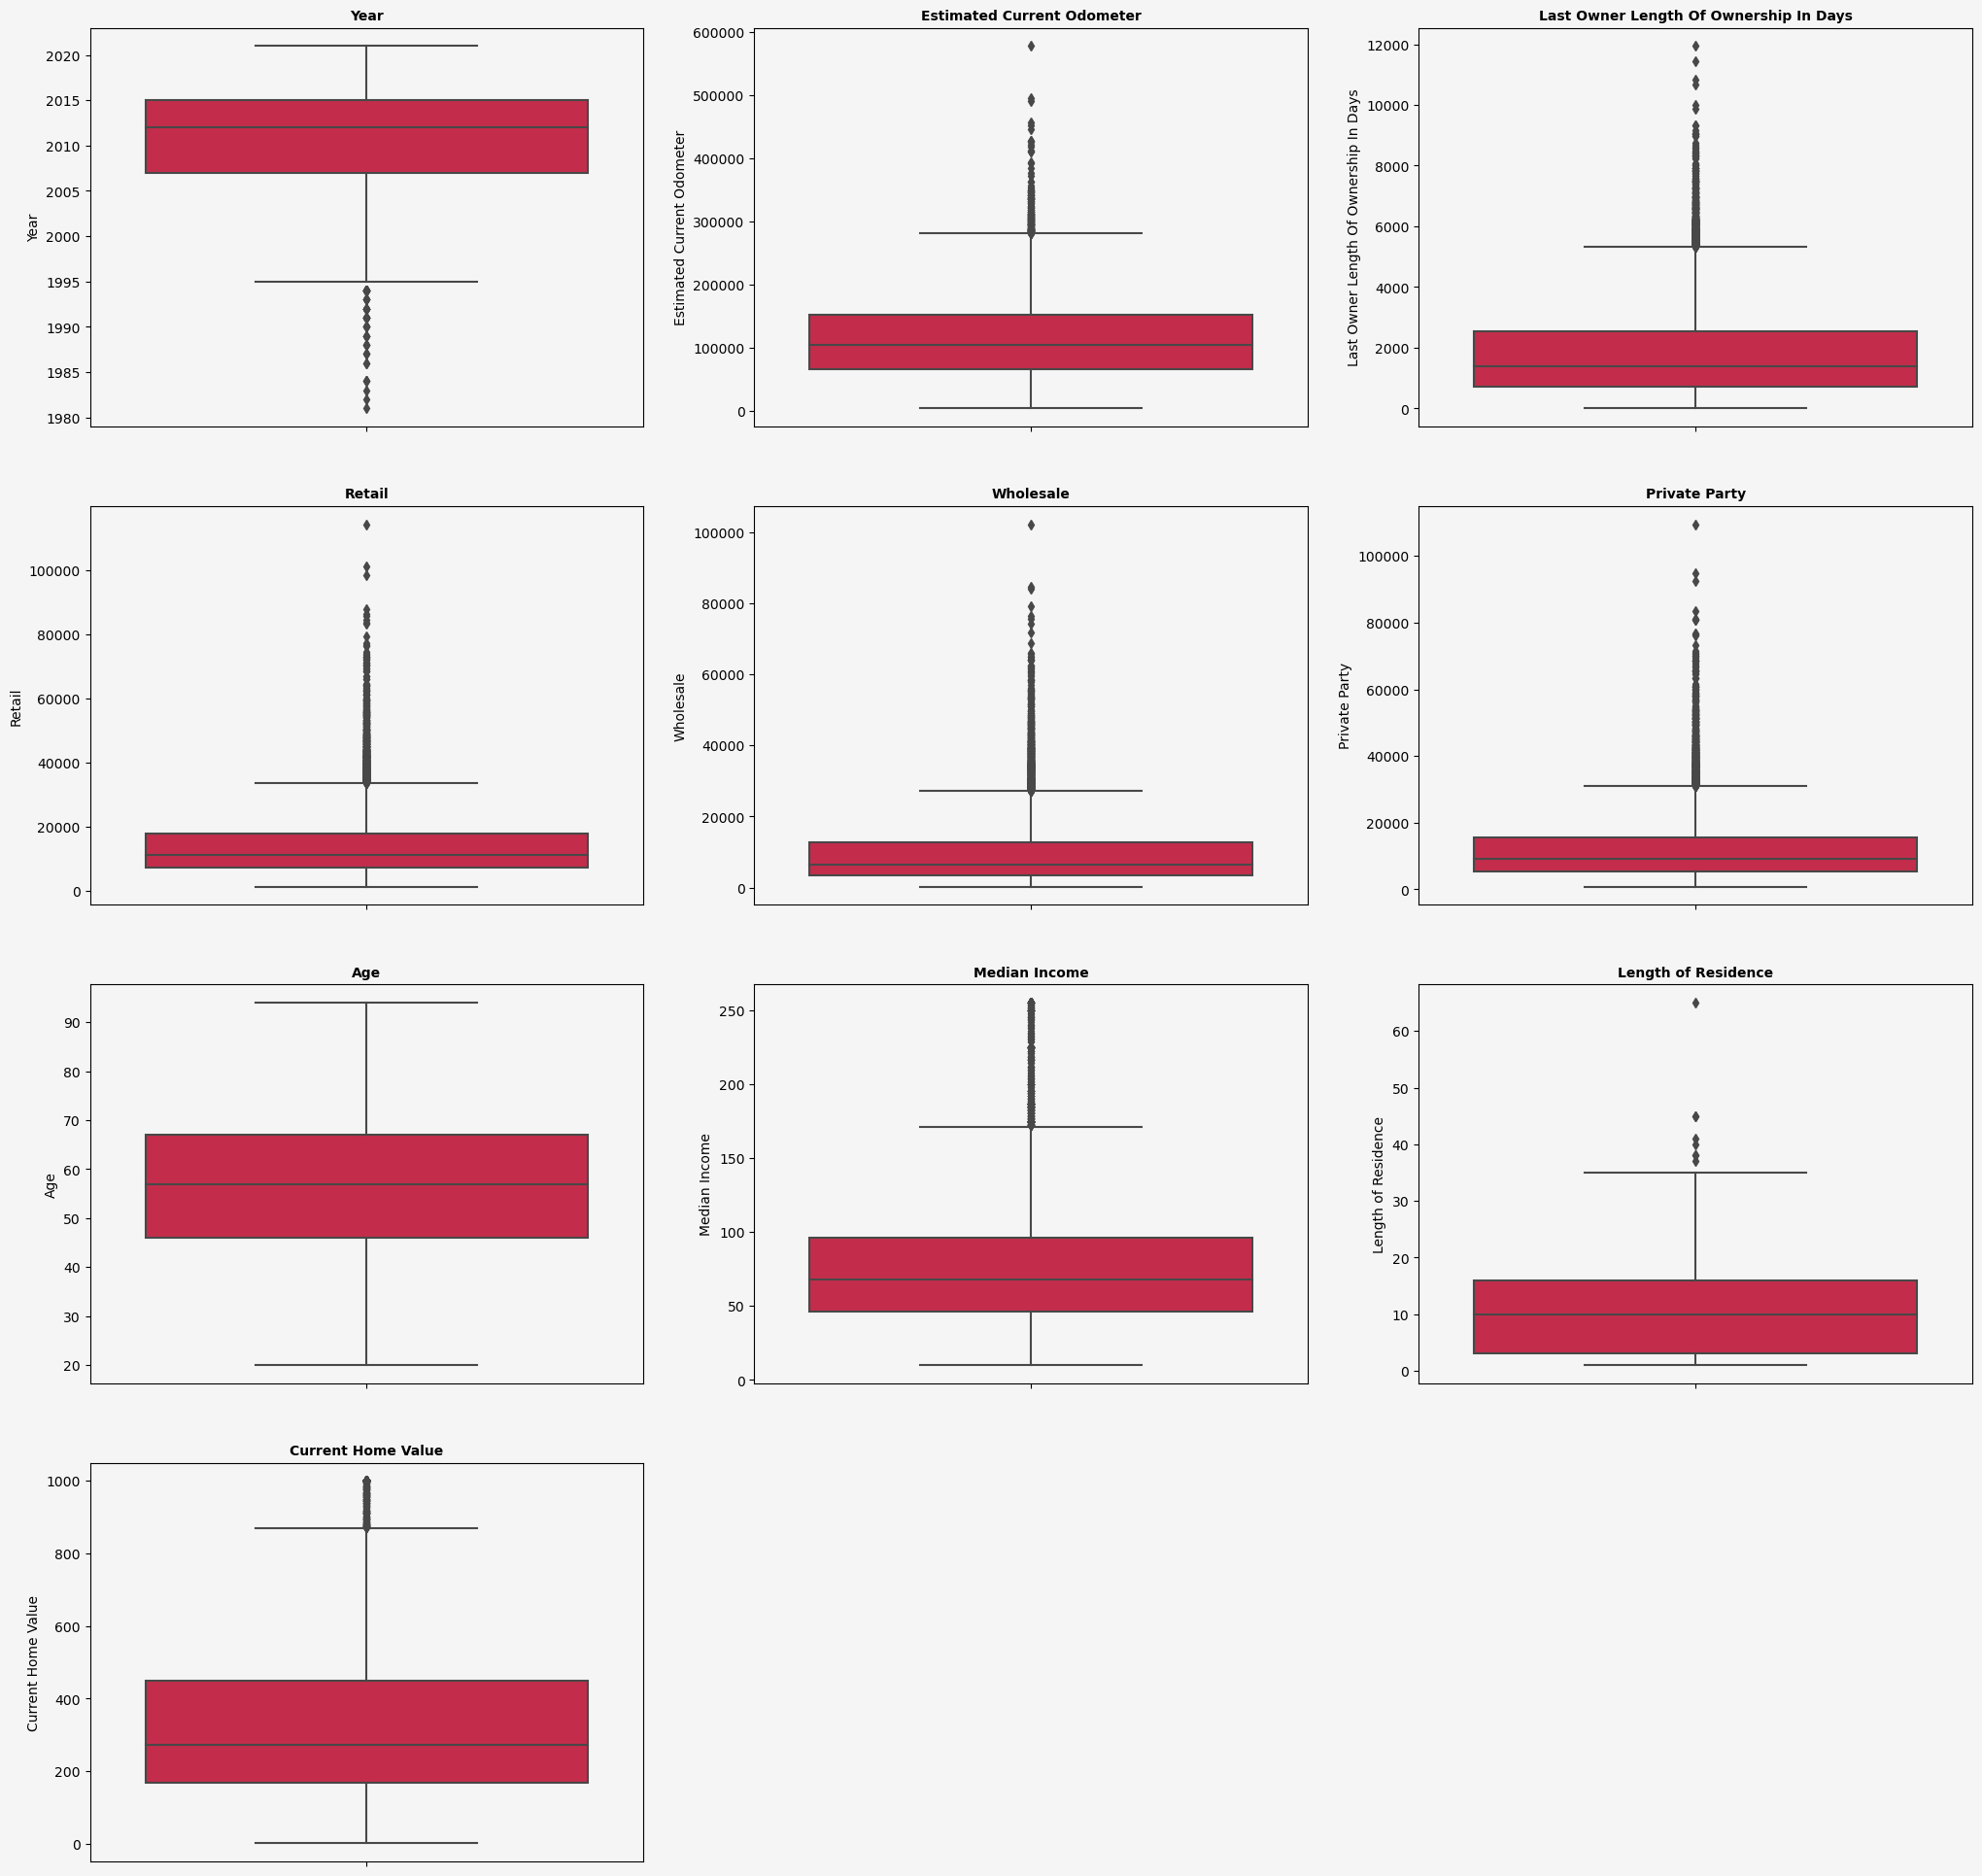

In [8]:
import seaborn as sns
from scipy.stats import norm

# write function to visualize the distribution of variables
def check_dist(row,col,data,cols,color,isbox=True):
    fig,axes = plt.subplots(row,col,figsize=(25,25),dpi=100,facecolor="whitesmoke")
    i = 0
    if isbox:
        for r in range(row):
            for c in range(col):
                try:
                    sns.boxplot(y=data[cols[i]],ax=axes[r,c],color=color)
                    text_title = cols[i]
                    i += 1
                    axes[r,c].set_facecolor("whitesmoke")
                    axes[r,c].set_title(text_title,fontsize=10,weight="bold")
                    axes[r,c].set_xlabel("")
                except IndexError:
                    pass
    else:
         for r in range(row):
            for c in range(col):
                try:
                    sns.distplot(data[cols[i]],ax=axes[r,c],color=color,fit=norm)
                    text_title = cols[i]
                    i += 1
                    axes[r,c].set_facecolor("whitesmoke")
                    axes[r,c].set_title(text_title,y=1,pad=-10,fontsize=14,fontweight="bold",color="crimson")
                    axes[r,c].set_xlabel("")
                except IndexError:
                    pass       
        
    # delete all surplus subplots that do not include any graphs
    if row*col > len(cols):
        total_plot_num = row*col
        plot_num = total_plot_num-len(cols)
        for i in reversed(list(range(plot_num))):
            axes[row-1,col-i-1].set_visible(False)
            
    plt.show()
    
# call the funciton
check_dist(4,3,data,continuous_cols,"crimson",isbox=True)
plt.show()

There are a number of outliers in Retail, which is an important indicator of whether consumers buy tires. Take a closer look at the distribution of the variable and the distribution after tranforming it by taking the logrithm.

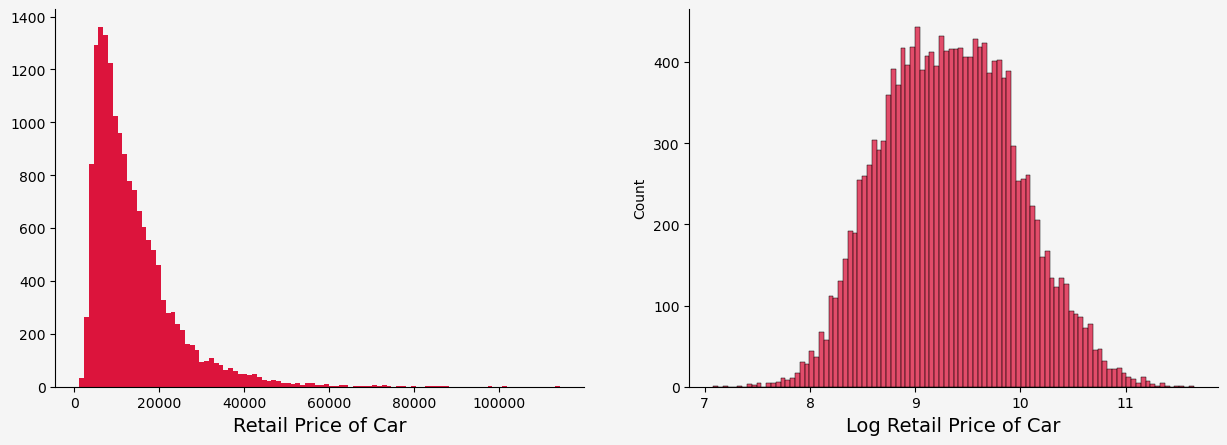

In [9]:
fig,axes = plt.subplots(1,2,dpi=100,figsize=(15,5),facecolor="whitesmoke")
data["Retail"].hist(bins=100,color="crimson",ax=axes[0])
axes[0].grid(False)
axes[0].set_facecolor("whitesmoke")
axes[0].set_xlabel("Retail Price of Car",fontsize=14)
for i in ["right","top"]:
    axes[0].spines[i].set_visible(False)


    
# perform log transformation on the variable and see distribution
data["log_retail"] = np.log(data["Retail"])
sns.histplot(data=data,x="log_retail",color="crimson",bins=100)
axes[1].grid(False)
axes[1].set_facecolor("whitesmoke")
axes[1].set_xlabel("Log Retail Price of Car",fontsize=14)
for i in ["right","top"]:
    axes[1].spines[i].set_visible(False)


$\color{crimson}{\bf{\text{Interpretation:}}}$

The log transformation makes the distribution of `Retail` more normal than before, and the bell-shape curve can make some parametric models assuming normal distribution perform better. We decided to perform the same operation on other variables with severe outliers.

## Variation of Features

I classify variables into *target variable* and *predictors*, and then examine the characteristic of variation of the two class of features respectively.

### Target Variable

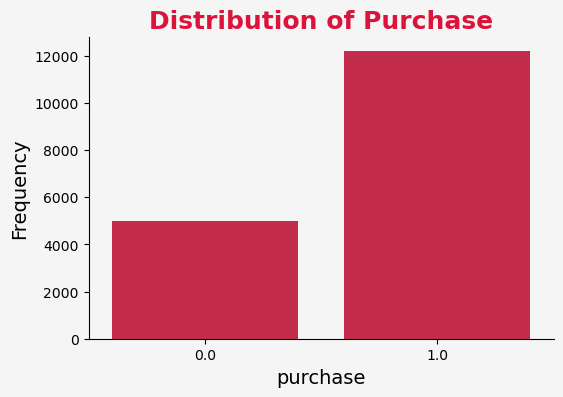

In [10]:
def plot_cat_dist(data,y,title):
    target_da = data[y].value_counts().reset_index().rename(columns={"index":y,y:"frequency"})
    #____________________________________________________________________________________________________________

    # Visualize the distribution of target variable
    fig,ax = plt.subplots(1,1,dpi=100,facecolor="whitesmoke")

    sns.barplot(data=target_da,x=y,y='frequency',color="crimson",ax=ax)
    ax.set_facecolor("whitesmoke")
    ax.set_xlabel(y,fontsize=14)
    ax.set_ylabel("Frequency",fontsize=14)
    ax.set_title(title,fontsize=18,
                color="crimson",weight="bold")
    for spine in ["top","right"]:
        ax.spines[spine].set_visible(False)
    plt.show()
    
plot_cat_dist(data,"purchase","Distribution of Purchase")

$\color{crimson}{\bf{\text{Interpretation:}}}$

There is a substantial difference in consumer count between tire buyer and tire non-buyer. This is a $\color{crimson}{\bf{\text{typical imbalanced dataset}}}$ and it is problematic for our predictive model because the model will spend a huge amount of effor on finding the majority class and the minority class thus becomes hard to predict. 

**Therefore, we decided to downsample the larger class(purchased) to be roughly the same size as the smaller class(not purchased) because the sample size for customers who purchase tires is large enough with more than 10,000 observations.**

In [11]:
# create a balanced dataset
data["purchase"].value_counts()

1.0    12202
0.0     5000
Name: purchase, dtype: int64

The number of customers who did not purchase tires is 5000, so I decided to downsample the marjority class to 5000.

In [12]:
seed = 123

# extract the data of tire purchaser
mark = data["purchase"] == 1
purchase_data = data[mark]
nonpur_data = data[~mark]

# sample data for training
pur_data = purchase_data.sample(n=4000,random_state=seed)
nonpur_data_x = nonpur_data.sample(frac=0.8,random_state=seed)


# concat train set
balanced_data = pd.concat([pur_data,nonpur_data_x],axis=0)

# holdout dataset
pur_mark = ~purchase_data.index.isin(pur_data.index)
nopur_mark = ~nonpur_data.index.isin(nonpur_data_x.index)
holdout_data = pd.concat([purchase_data.loc[pur_mark,:],nonpur_data.loc[nopur_mark,:]])

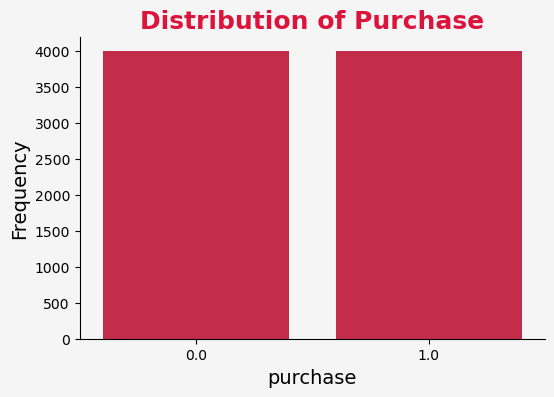

In [13]:
plot_cat_dist(balanced_data,"purchase","Distribution of Purchase")

After downsampling, we obtained an evenly distributed dataset. Now we can move on to the variation examination of independent variables.

In [14]:
balanced_data["Household Income"] = balanced_data["Household Income"].apply(lambda x:str(x).strip())

### Predictor Variables

Predictor variables can be classified into numerical variables and categorical variables, and numerical variables can be further splitted into continuous variables and discrete variables. We will check the variation of three classes of variables one by one.
___

**Framework**
- *Continuous Variable*
- *Discrete Variable*
- *Categorical Variable*

#### Continuous Variables

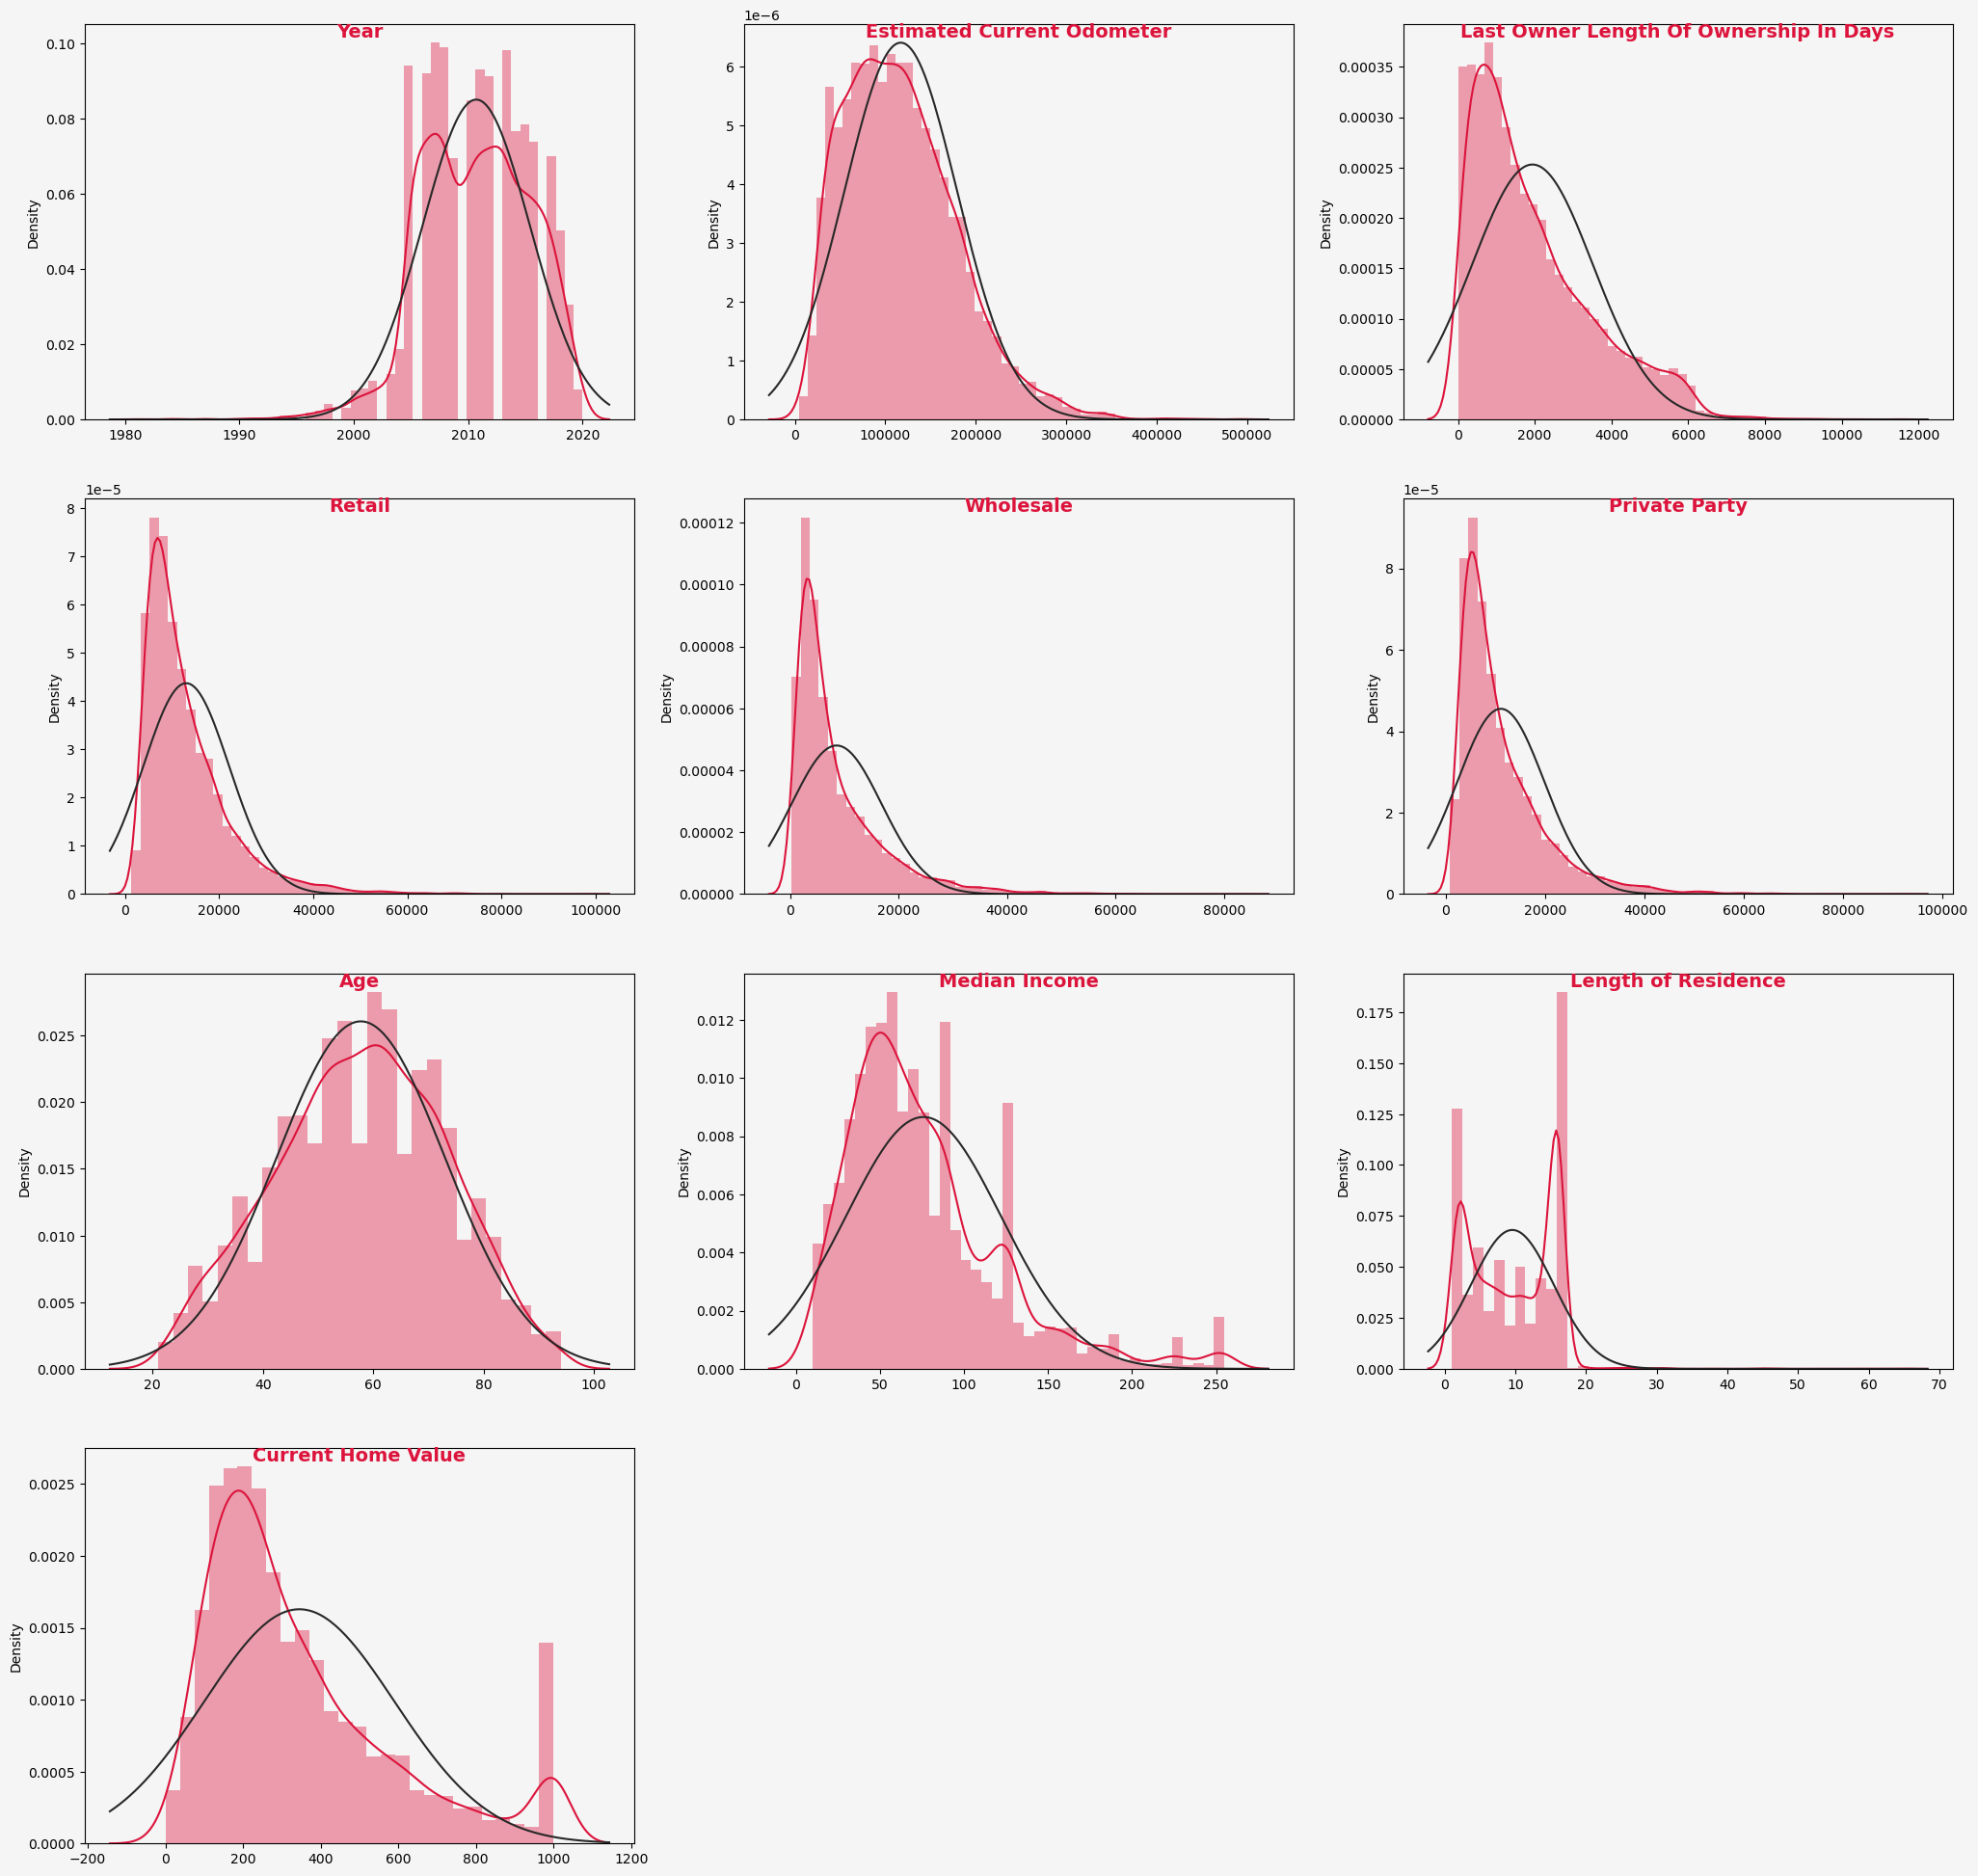

In [15]:
# call the funciton
check_dist(4,3,balanced_data,continuous_cols,"crimson",isbox=False)
plt.show()

$\color{crimson}{\bf{\text{Interpretation:}}}$

- *Age* follows a normal distribution, with most of consumers aged around 40. 
- Except for *year* and *age*, all other variables show the same pattern of positive skewness. $\color{crimson}{\text{The value of raw counts spans several orders of magnitude}}$ and this is problematic for several models, such as linear models because linear models have to work for all possible values of the count. The extremely large values could wreak havoc in unsupervised learning methods such as *K-means* clustering. 

$\color{crimson}{\bf{\text{Insights:}}}$

To prevent the skewed distribution from adversely impacting the performance of models, we decided to perform feature engineering on these variables, such as *log transformation, quantizing, or Box-cox transform, etc.*

#### Categorical Variables


In [16]:
nunique_num = [balanced_data[obj_col].nunique() for obj_col in object_cols]
print("The Number of Categories for each Categorical Variable")
print("___________________________________________")
res = pd.DataFrame({"Feature name":object_cols,"Unique Categories":nunique_num})
cm = sns.light_palette("crimson", as_cmap=True)
res.sort_values(by="Unique Categories",ascending=False).style.background_gradient(cm)

The Number of Categories for each Categorical Variable
___________________________________________


$\color{crimson}{\bf{\text{Interpretation:}}}$

- The number of categories for *Model* is extremely large and in this case common approaches working with categorical variables, including *one hot encoding or dummy encoding*, break down. 
- The number of categories for other varaibles is not such huge, so we can perform *one hot encoding or dummy encoding* to transform the variable to feed it to machine learning algorithms.


$\color{crimson}{\bf{\text{Insights:}}}$

- We have two options, *removal or transformation*, when having one variable with extremely large number of categories. Based on the hunch that consumers may have difference preferences over make and model when buying cars, we decided to transform the variable. **Hash Featuring might not be a good option because of low interpretability and Bins Counting will be applied.**
- The *Presence of Children*, *Working woman in household*, and *Young Adults in Household* have only one unique category and so we remove them from the dataset because of their zero variance.
- As for all other categorical variables, if some of them are ordinal variables, then we transform them using LabelEncoding, but if not, we can either perform ont-hot encoding or dummy encoding.

**1) Drop Variables with only One Category**

In [17]:
dp_cols = ["Working woman in household","Young Adult in household","Presence of Children"]
balanced_da = balanced_data.drop(dp_cols,axis=1)
mark = balanced_da.columns[balanced_da.dtypes == "object"]
cat_data = balanced_da[mark]

**2) Then we need to identify which one variable has logical ordering so that we can perform ordinal encoding on them. Examine the distribution of the categorical variables with less than 15 categories.**

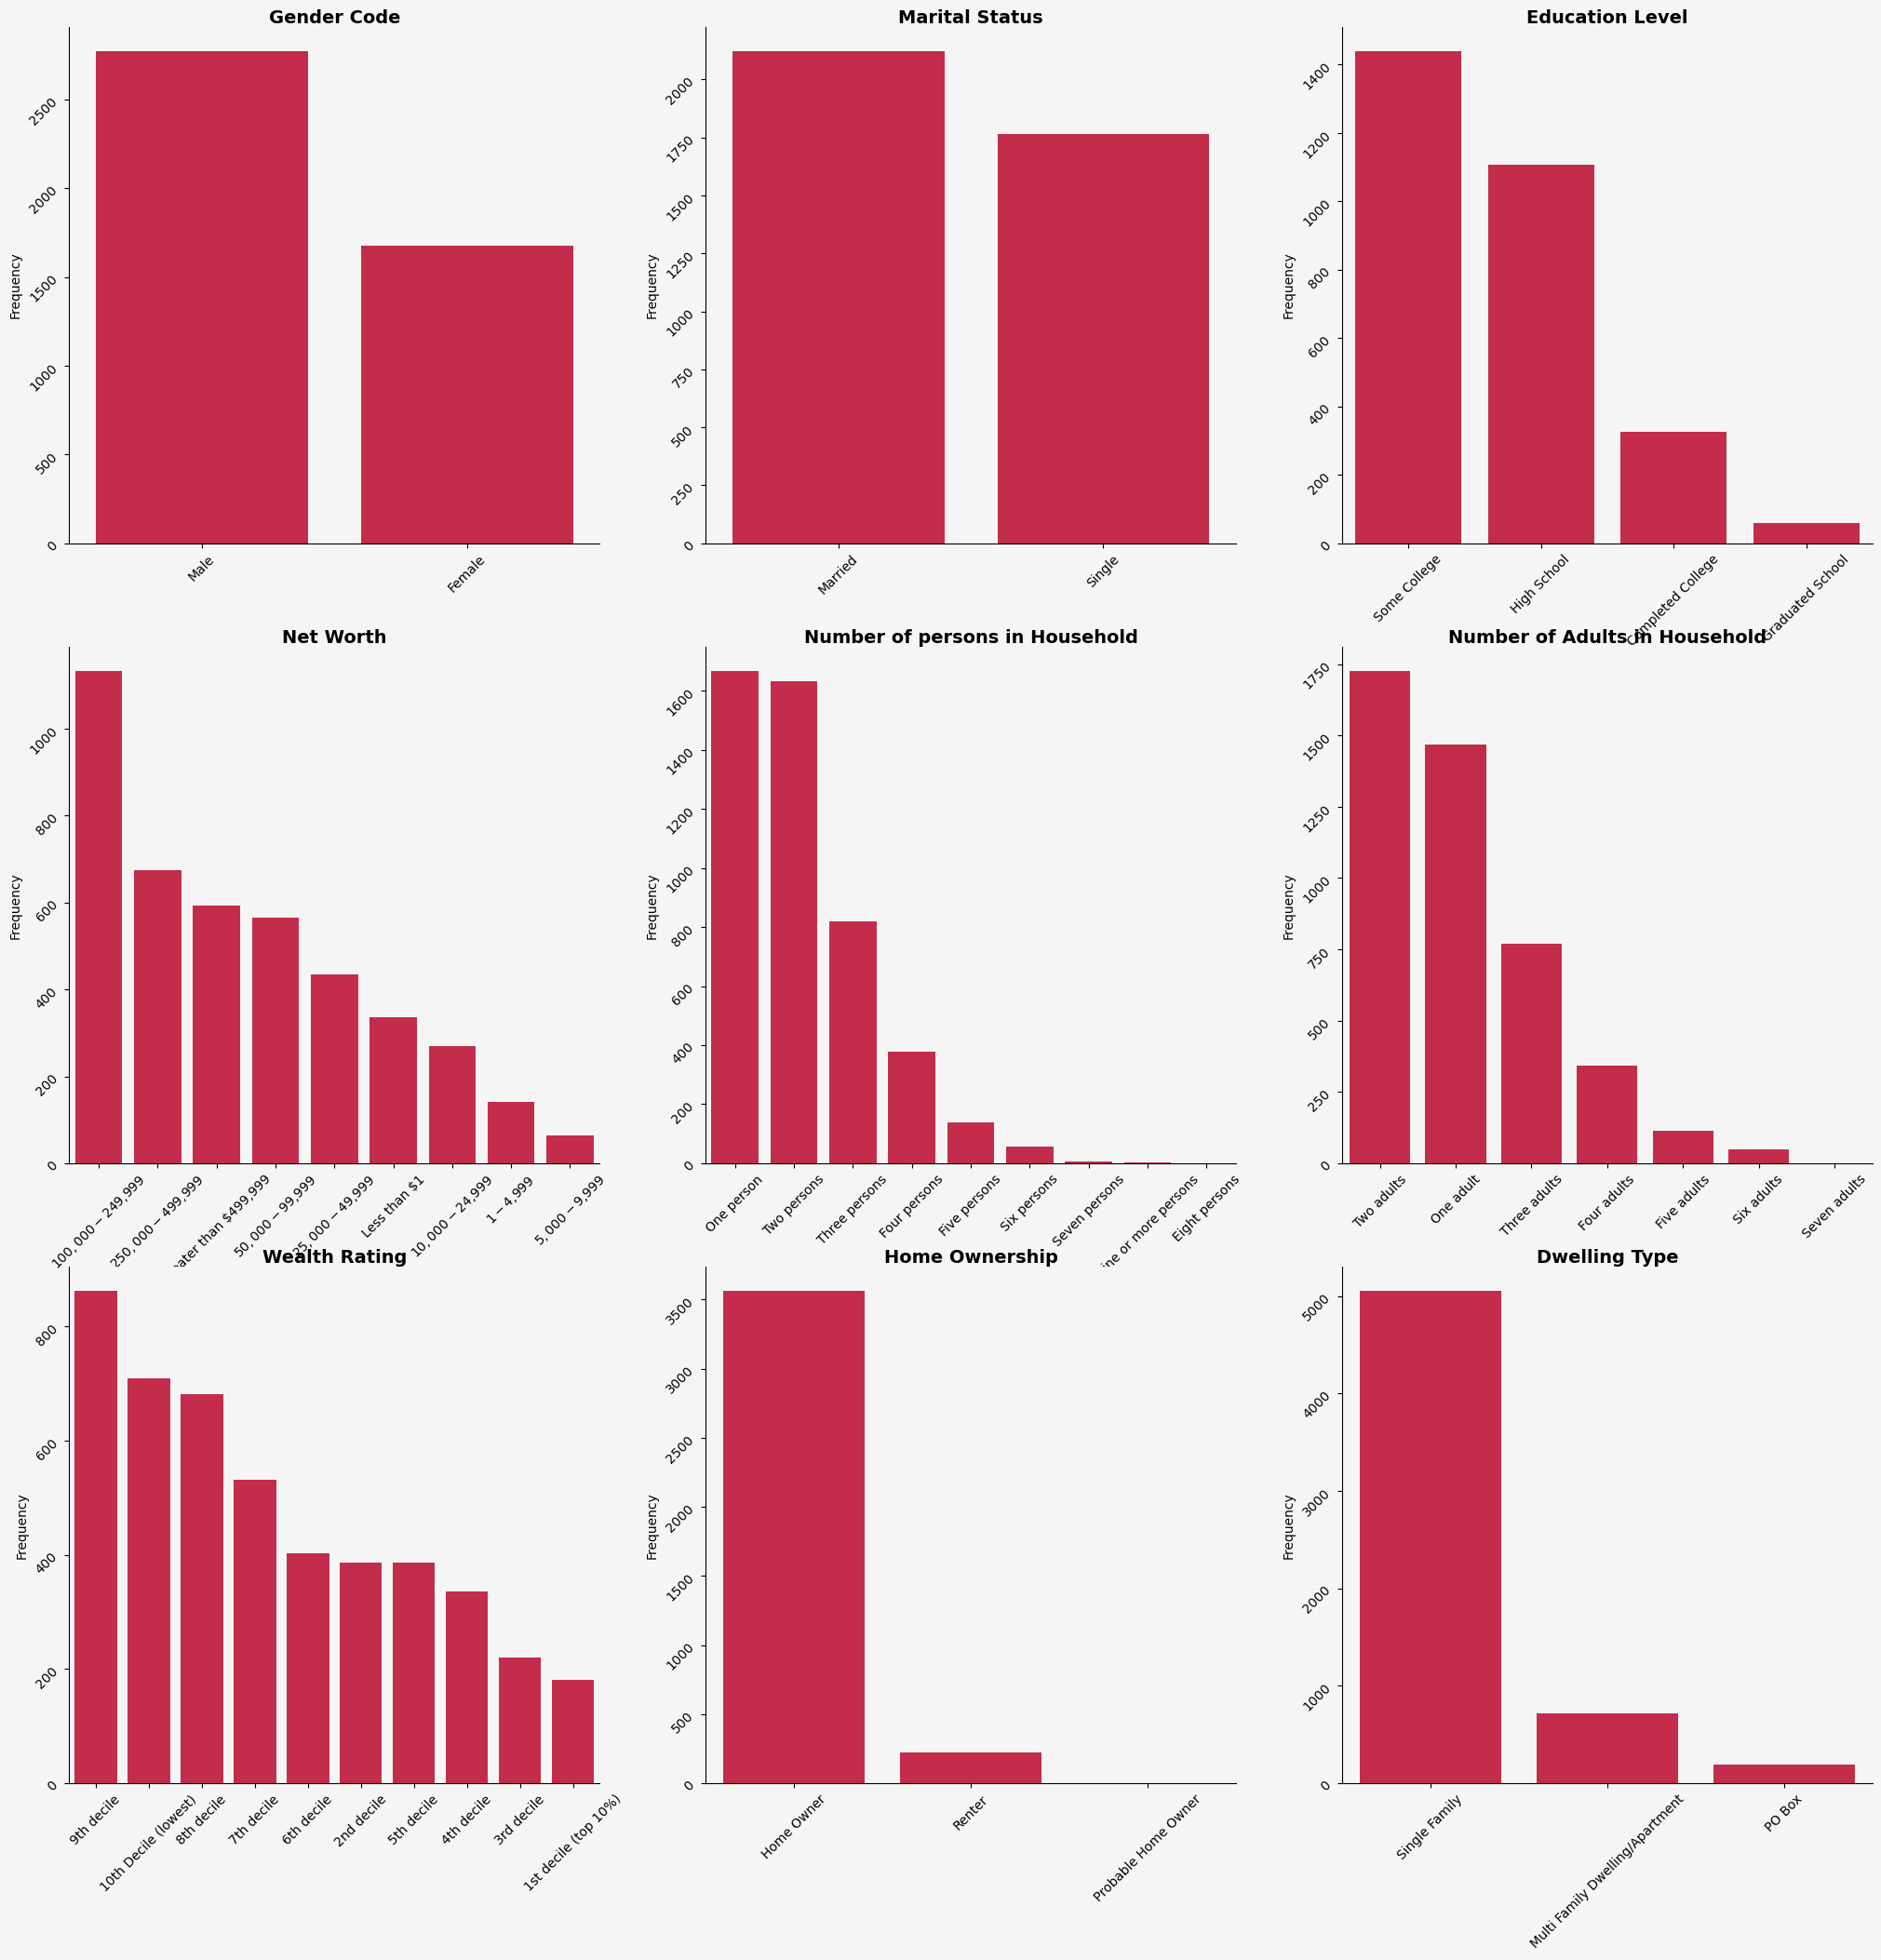

In [18]:
# folter out car with less than 15 categories
mark = (res["Unique Categories"]<15) & (res["Unique Categories"]!=1)
# extract columns
cat_cols = res[mark]["Feature name"].tolist()

fig,axes = plt.subplots(3,3,figsize=(25,25),dpi=100,facecolor="whitesmoke")
i = 0
for r in range(4):
    for c in range(3):
        try:
            temp = balanced_da[cat_cols[i]].value_counts().reset_index().rename(columns={"index":cat_cols[i],cat_cols[i]:"Frequency"})
            sns.barplot(data=temp,x=cat_cols[i],y="Frequency",color="crimson",ax=axes[r,c])
            text_title = cat_cols[i]
            i += 1
            axes[r,c].set_facecolor("whitesmoke")
            axes[r,c].set_title(text_title,fontsize=14,weight="bold",pad=-8)
            axes[r,c].set_xlabel("")
            for spine in ["right","top"]:
                axes[r,c].spines[spine].set_visible(False)
            axes[r,c].tick_params(labelsize=10,rotation=45)
        except IndexError:
            pass

plt.show()

$\color{crimson}{\bf{\text{Interpretation:}}}$

- Categories of `Education level` obviously have an logical ordering: Gradiated School > Completed College > Some College > High School. Therefore *ordinal encoding* make sense in this variable.
- `Net Worth` is splitted into different categories of bins, and these bins changes when the range of bins increases. So the variable has logical sequence and we can assign numbers to them from 1 to k.
- `Number of persons in HouseHold` and `Number of Adults in HighScoll` actually represent numbers even if they are string. We encode them as ordering numbers.
- `Wealth Rating` represents the financial status of consumers. We assume that consumers who are more wealthy should be more likely buy tires, and so we decided to give more weight to people at the 1st decile and less weght to poor people.
- As for other variables, we did not find out any logical ordering, so we decided to perform one-hot encoding on them.

## Covariation

**Framework:**

- Taget Variable and Predictor Vairables
- Relations between Predictor Variables

### Correlation between Taget Variable and Predictor Vairables

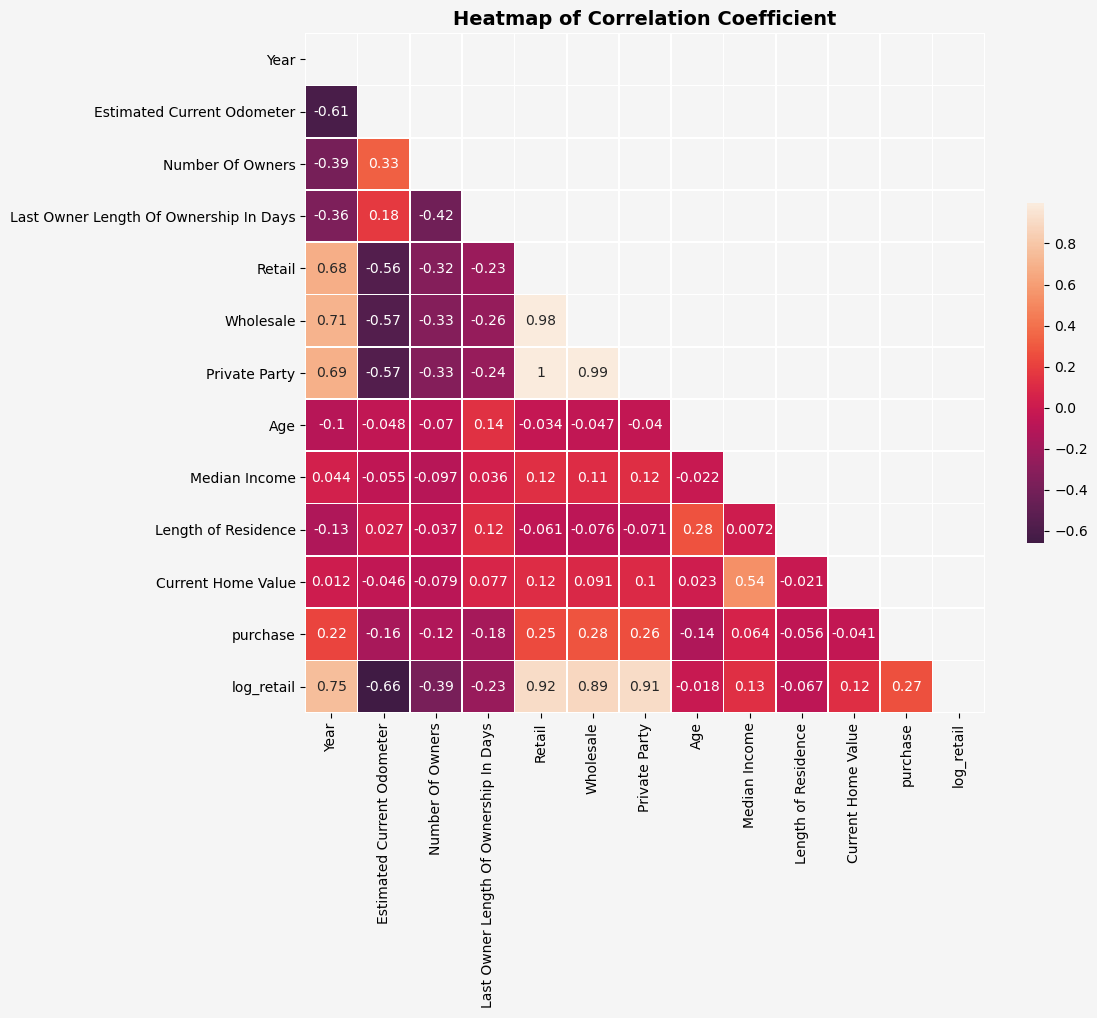

In [19]:
# split columns into different cats
object_cols,numerical_cols,discrete_cols,continuous_cols = get_columns(balanced_da)

def corr_plot(data,cols):
    """plot the heatmap of correlation coefficients of variables"""

    # take a quick look at the relationship between variables
    corr_matrix = data[cols].corr()
    # Set up the matplotlib figure
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    fig, ax = plt.subplots(figsize=(11, 9),dpi=100,facecolor="whitesmoke")
    sns.heatmap(corr_matrix,cmap="rocket",annot=True,mask=mask,ax=ax,center=0,square=True,linewidths=.5,cbar_kws={"shrink": .5})
    ax.set_facecolor("whitesmoke")
    ax.set_title("Heatmap of Correlation Coefficient",weight="bold",fontsize=14)
    plt.show()
    
    
    
corr_plot(balanced_da,numerical_cols)

$\color{crimson}{\bf{\text{Interpretation:}}}$

- `Retailing price`, `Private Party` and `Year` are more correlated with purchase than other variables
- `Retail`, `wholesale`, and `private party` are highly correlated with each other. We only focus on retail.
- Collinearity is a servere problem in the dataset.

We display the correlation coefficients of independent variables with target variable.

In [20]:
mark = pd.Series(numerical_cols).isin(["log_retail"])
corr_ser = balanced_da[pd.Series(numerical_cols)[~mark].tolist()].corr()["purchase"].sort_values(ascending=False)
corr_ser

purchase                                  1.000000
Wholesale                                 0.282445
Private Party                             0.263872
Retail                                    0.246420
Year                                      0.223230
Median Income                             0.063909
Current Home Value                       -0.040824
Length of Residence                      -0.055883
Number Of Owners                         -0.122756
Age                                      -0.138486
Estimated Current Odometer               -0.163793
Last Owner Length Of Ownership In Days   -0.175416
Name: purchase, dtype: float64

#### Purchase Versus Retail


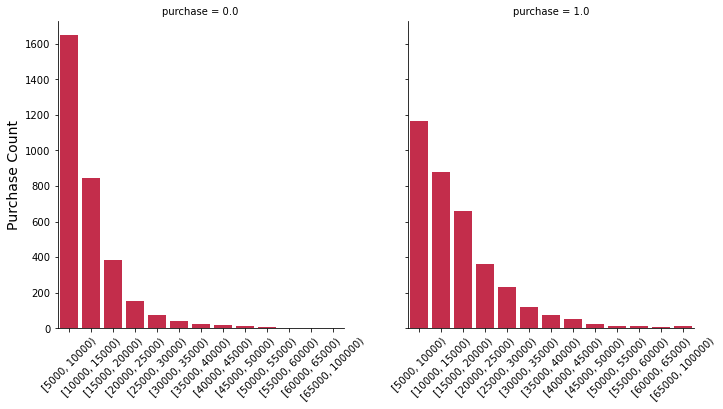

In [21]:
plot_da = balanced_da.copy()
plot_da["retail_bins"] = pd.cut(plot_da["Retail"],
                               [5000,10000,15000,20000,25000,30000,35000,40000,45000,50000,55000,60000,65000,100000],
                               right=False)
#____________________________________________________________________________________________________________

# Visualize the distribution of target variable
fig = sns.catplot(data=plot_da,x="retail_bins",col="purchase",kind="count",color="crimson")
fig.set_axis_labels("", "Purchase Count",fontsize=14)
fig.set_xticklabels(rotation=45)
plt.show()

##### Purchase Versus Retail  across Sex

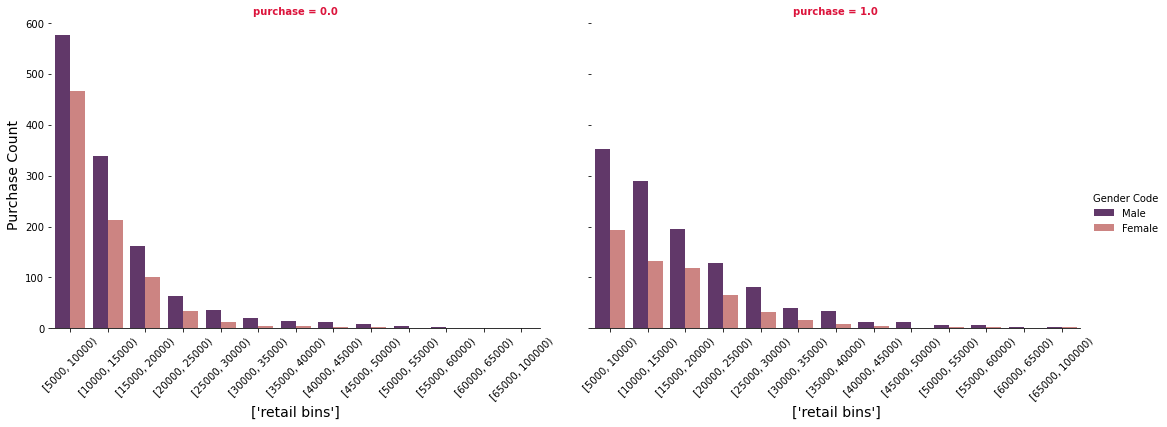

In [22]:
fig = sns.catplot(data=plot_da,x="retail_bins",col="purchase",kind="count",hue="Gender Code",
           saturation=.5,ci=None, aspect=1.5,palette="magma")
fig.set_axis_labels("", "Purchase Count",fontsize=14)
fig.set_xlabels(["retail bins"],fontsize=14)
fig.set_titles(fontsize=16,color="crimson",weight="bold")
fig.despine(left=True)
fig.set_xticklabels(rotation=45)
plt.show()

$\color{crimson}{\bf{\text{Interpretation:}}}$

For either purchase or not purchase, the number of male customers is always greater than that of female customers across all price levels, indicating that the impact of price on car purchase is not mediated by **Gender**. We turn to examine other variables.

##### Purchase Versus Retail by Marital Status

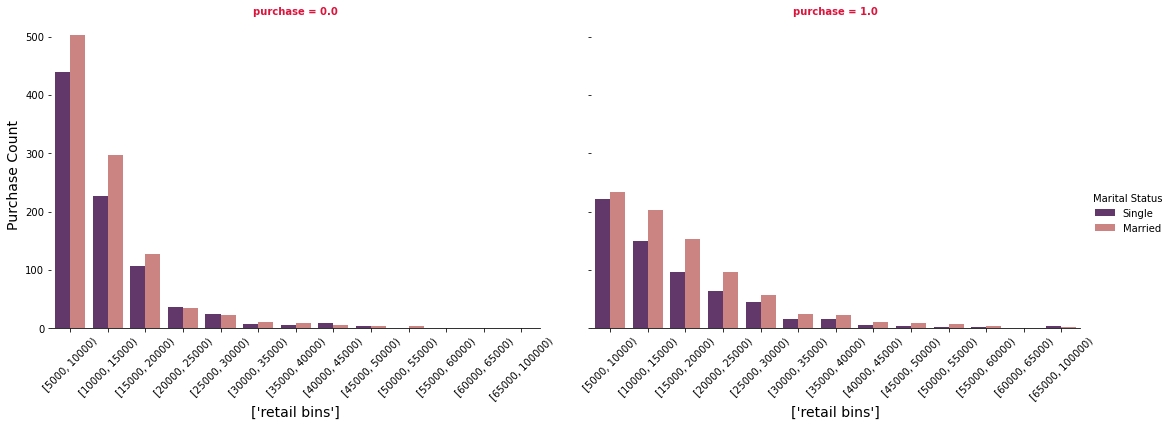

In [23]:
fig = sns.catplot(data=plot_da,x="retail_bins",col="purchase",kind="count",hue="Marital Status",
           saturation=.5,ci=None, aspect=1.5,palette="magma")
fig.set_axis_labels("", "Purchase Count",fontsize=14)
fig.set_xlabels(["retail bins"],fontsize=14)
fig.set_titles(fontsize=16,color="crimson",weight="bold")
fig.despine(left=True)
fig.set_xticklabels(rotation=45)
plt.show()

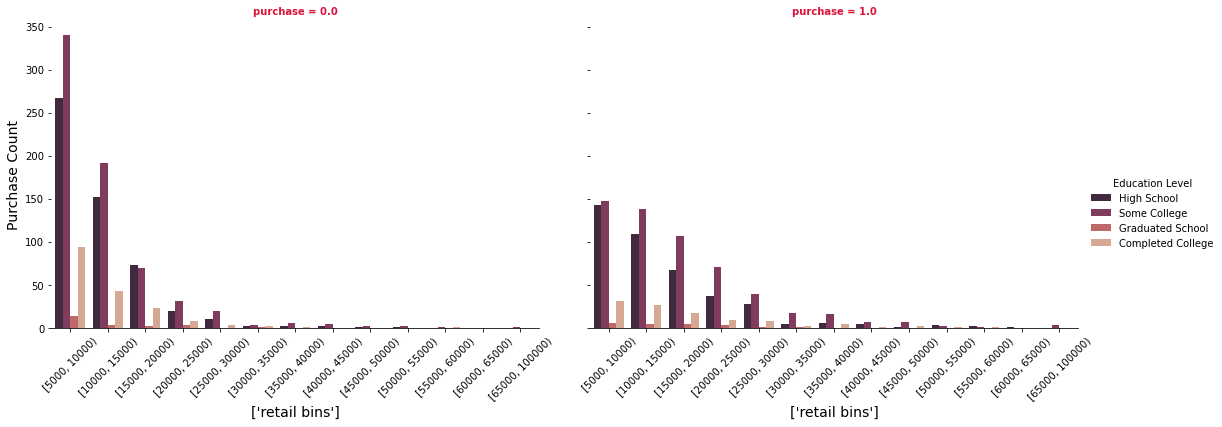

In [24]:
fig = sns.catplot(data=plot_da,x="retail_bins",col="purchase",kind="count",hue="Education Level",
           saturation=.5,ci=None, aspect=1.5,palette="rocket")
fig.set_axis_labels("", "Purchase Count",fontsize=14)
fig.set_xlabels(["retail bins"],fontsize=14)
fig.set_titles(fontsize=16,color="crimson",weight="bold")
fig.despine(left=True)
fig.set_xticklabels(rotation=45)
plt.show()

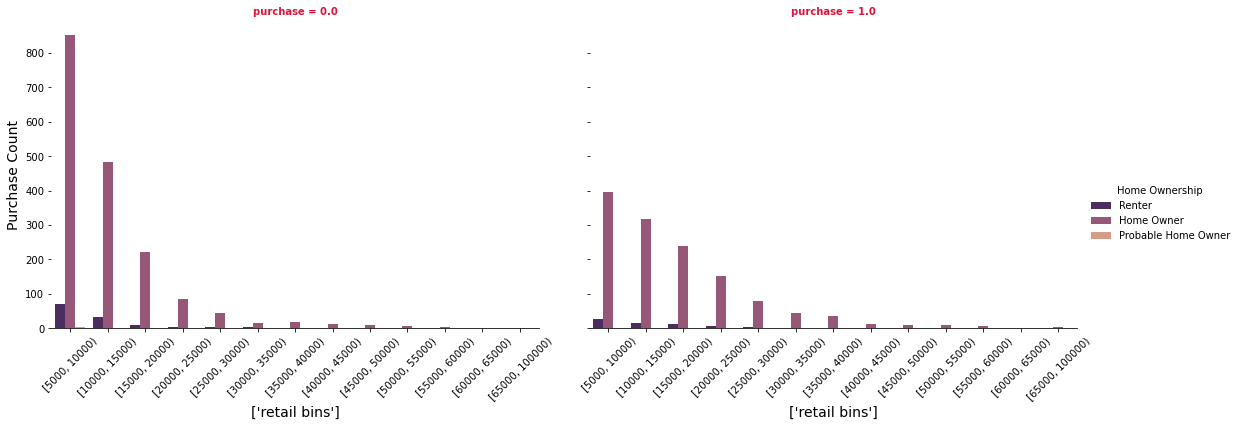

In [25]:
fig = sns.catplot(data=plot_da,x="retail_bins",col="purchase",kind="count",hue="Home Ownership",
           saturation=.5,ci=None, aspect=1.5,palette="magma")
fig.set_axis_labels("", "Purchase Count",fontsize=14)
fig.set_xlabels(["retail bins"],fontsize=14)
fig.set_titles(fontsize=16,color="crimson",weight="bold")
fig.despine(left=True)
fig.set_xticklabels(rotation=45)
plt.show()

#### Purchase Versus Purchase Date

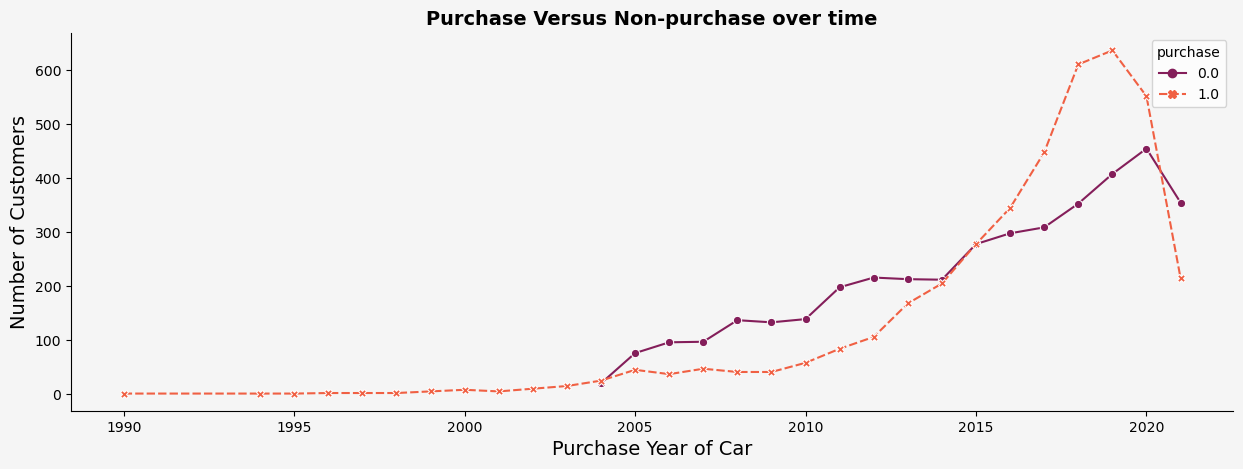

In [26]:
plot_da["purchase_year"] = pd.to_datetime(plot_da["Vehicle Purchase Date"]).dt.year

res = plot_da.dropna(subset=["purchase_year","purchase"]).groupby(["purchase_year","purchase"]).agg({"purchase_year":"count"}).\
rename(columns={"purchase_year":"count"})

# plot lines)
fig,ax = plt.subplots(1,1,figsize=(15,5),dpi=100,facecolor="whitesmoke")
sns.lineplot(data=res,x="purchase_year",y="count",hue="purchase",style="purchase",markers=True,ax=ax,palette="rocket")
ax.set_facecolor("whitesmoke")
ax.set_xlabel("Purchase Year of Car",fontsize=14)
ax.set_ylabel("Number of Customers",fontsize=14)
ax.set_title("Purchase Versus Non-purchase over time",fontsize=14,weight="bold")
for spine in ["top","right"]:
    ax.spines[spine].set_visible(False)
plt.show()

$\color{crimson}{\bf{\text{Interpretation:}}}$

From 2015, the number of tire buyers is greater than that of tire non-buyers. Between 2015 and 2020, the number of tire purchasers increased dramatically, and the difference between tire buyers and non-buyers is the greatest in the period. We decided to create one variable to indicate the seasonality, 

In [27]:
balanced_da["car_purchase_year"] = pd.to_datetime(balanced_da["Vehicle Purchase Date"]).dt.year
balanced_da["car_purchase_year_between_15_20"] = ((balanced_da["car_purchase_year"]>=2015) & (balanced_da["car_purchase_year"]<=2020)).astype("int64")

#### Purchase Versus Year

Examine the difference in purchase count in different years.

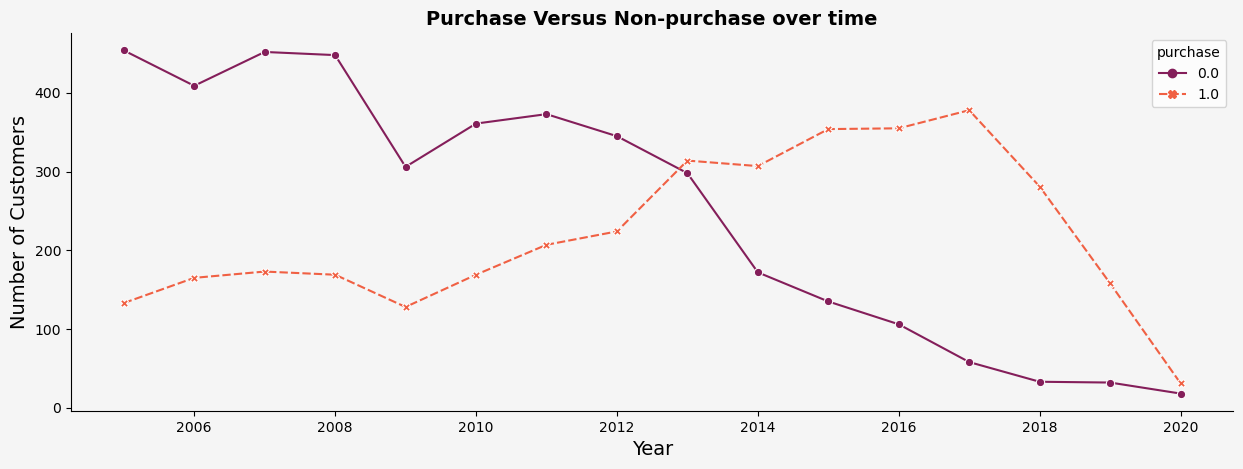

In [28]:
# extract the purchase data by year
res = plot_da.dropna(subset=["Year","purchase"]).groupby(["Year","purchase"]).agg({"Year":"count"}).\
rename(columns={"Year":"count"})
time_da = res.reset_index().query("Year>=2005")

# plot lines)
fig,ax = plt.subplots(1,1,figsize=(15,5),dpi=100,facecolor="whitesmoke")
sns.lineplot(data=time_da,x="Year",y="count",hue="purchase",style="purchase",markers=True,ax=ax,palette="rocket")
ax.set_facecolor("whitesmoke")
ax.set_xlabel("Year",fontsize=14)
ax.set_ylabel("Number of Customers",fontsize=14)
ax.set_title("Purchase Versus Non-purchase over time",fontsize=14,weight="bold")
for spine in ["top","right"]:
    ax.spines[spine].set_visible(False)
plt.show()

$\color{crimson}{\bf{\text{Interpretation:}}}$

- For cars manufactured before 2012, the number of customers who did not purchase tires is greater than that of customers who purchse tires, while in 2013, the figure for tire purchaser surparsses that for tire non-purchaser. 
- For cars manufactured between 2014 and 2018, tire purchasers are much more than those who did not purchase tires.
- After 2018, the number of tire purchaser begins to fall to the basically same number of non purchasers.

$\color{crimson}{\bf{\text{Insight}}}$

Customers with cars manufactured between 2014 and 2018 are more likley to purchase tires. Therefore, we decided to create one variable to indicate whether customer's cars are manufactured in the time period.

In [29]:
balanced_da["is_between_2014_2018"] =  ((balanced_da.Year>=2014) & (balanced_da.Year<=2018)).astype("int64")
balanced_da.is_between_2014_2018.value_counts()

0    5821
1    2179
Name: is_between_2014_2018, dtype: int64

##### Purchase Versus Year by Gender

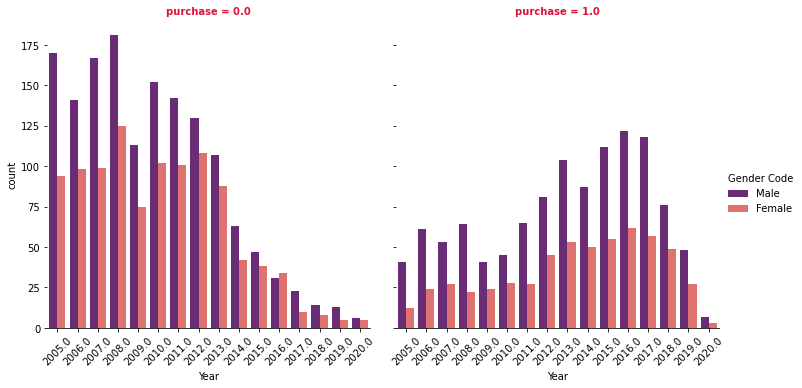

In [30]:
fig = sns.catplot(data=plot_da.query("Year>=2005"),x="Year",col="purchase",kind="count",hue="Gender Code",palette="magma")
fig.set_xticklabels(rotation=45,fontsize=10)
fig.set_titles(fontsize=16,color="crimson",weight="bold")
fig.despine(left=True)
plt.show()

$\color{crimson}{\bf{\text{Interpretation:}}}$

The customer count for either purchaser or non-purchaser has the same distribution over time: the number of males is always greater than that of females. So there is no interaction between `Year` and `Sex`.

##### Purchase Versus Year by Education Level

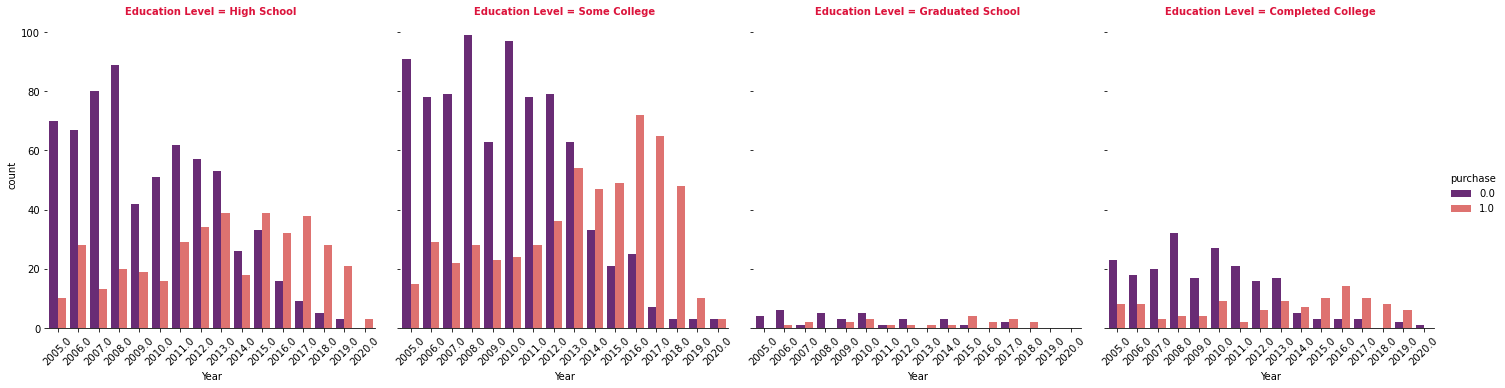

In [31]:
fig = sns.catplot(data=plot_da.query("Year>=2005"),x="Year",col="Education Level",kind="count",hue="purchase",palette="magma")
fig.set_xticklabels(rotation=45,fontsize=10)
fig.set_titles(fontsize=16,color="crimson",weight="bold")
fig.despine(left=True)
plt.show()

$\color{crimson}{\bf{\text{Interpretation:}}}$

- A same pattern can be found across the four grids of education level: the number of tire purchasers begins to be greater than that of tire non-purchasers.
- Although the four grids have the same pattern, there is one minor difference being remakable. For customers who had some college, the difference between the tire purchasers and tire non-purchasers is much greater than those who did not go to college or completed college.

$\color{crimson}{\bf{\text{Insight:}}}$

It is justified to state that people who had some college and whose care are produced between 2014 and 2019 are more likely to be our customers. Therefore, we decided to add one column to indiate the relationship.

In [32]:
balanced_da["some_colleges_2014_2018"] =  ((balanced_da.Year>=2014) & (balanced_da.Year<=2019) & (balanced_da["Education Level"]=="Some College"))\
.astype("int64")
balanced_da.some_colleges_2014_2018.value_counts()

0    7617
1     383
Name: some_colleges_2014_2018, dtype: int64

##### Purchase Versus Year by Household Size

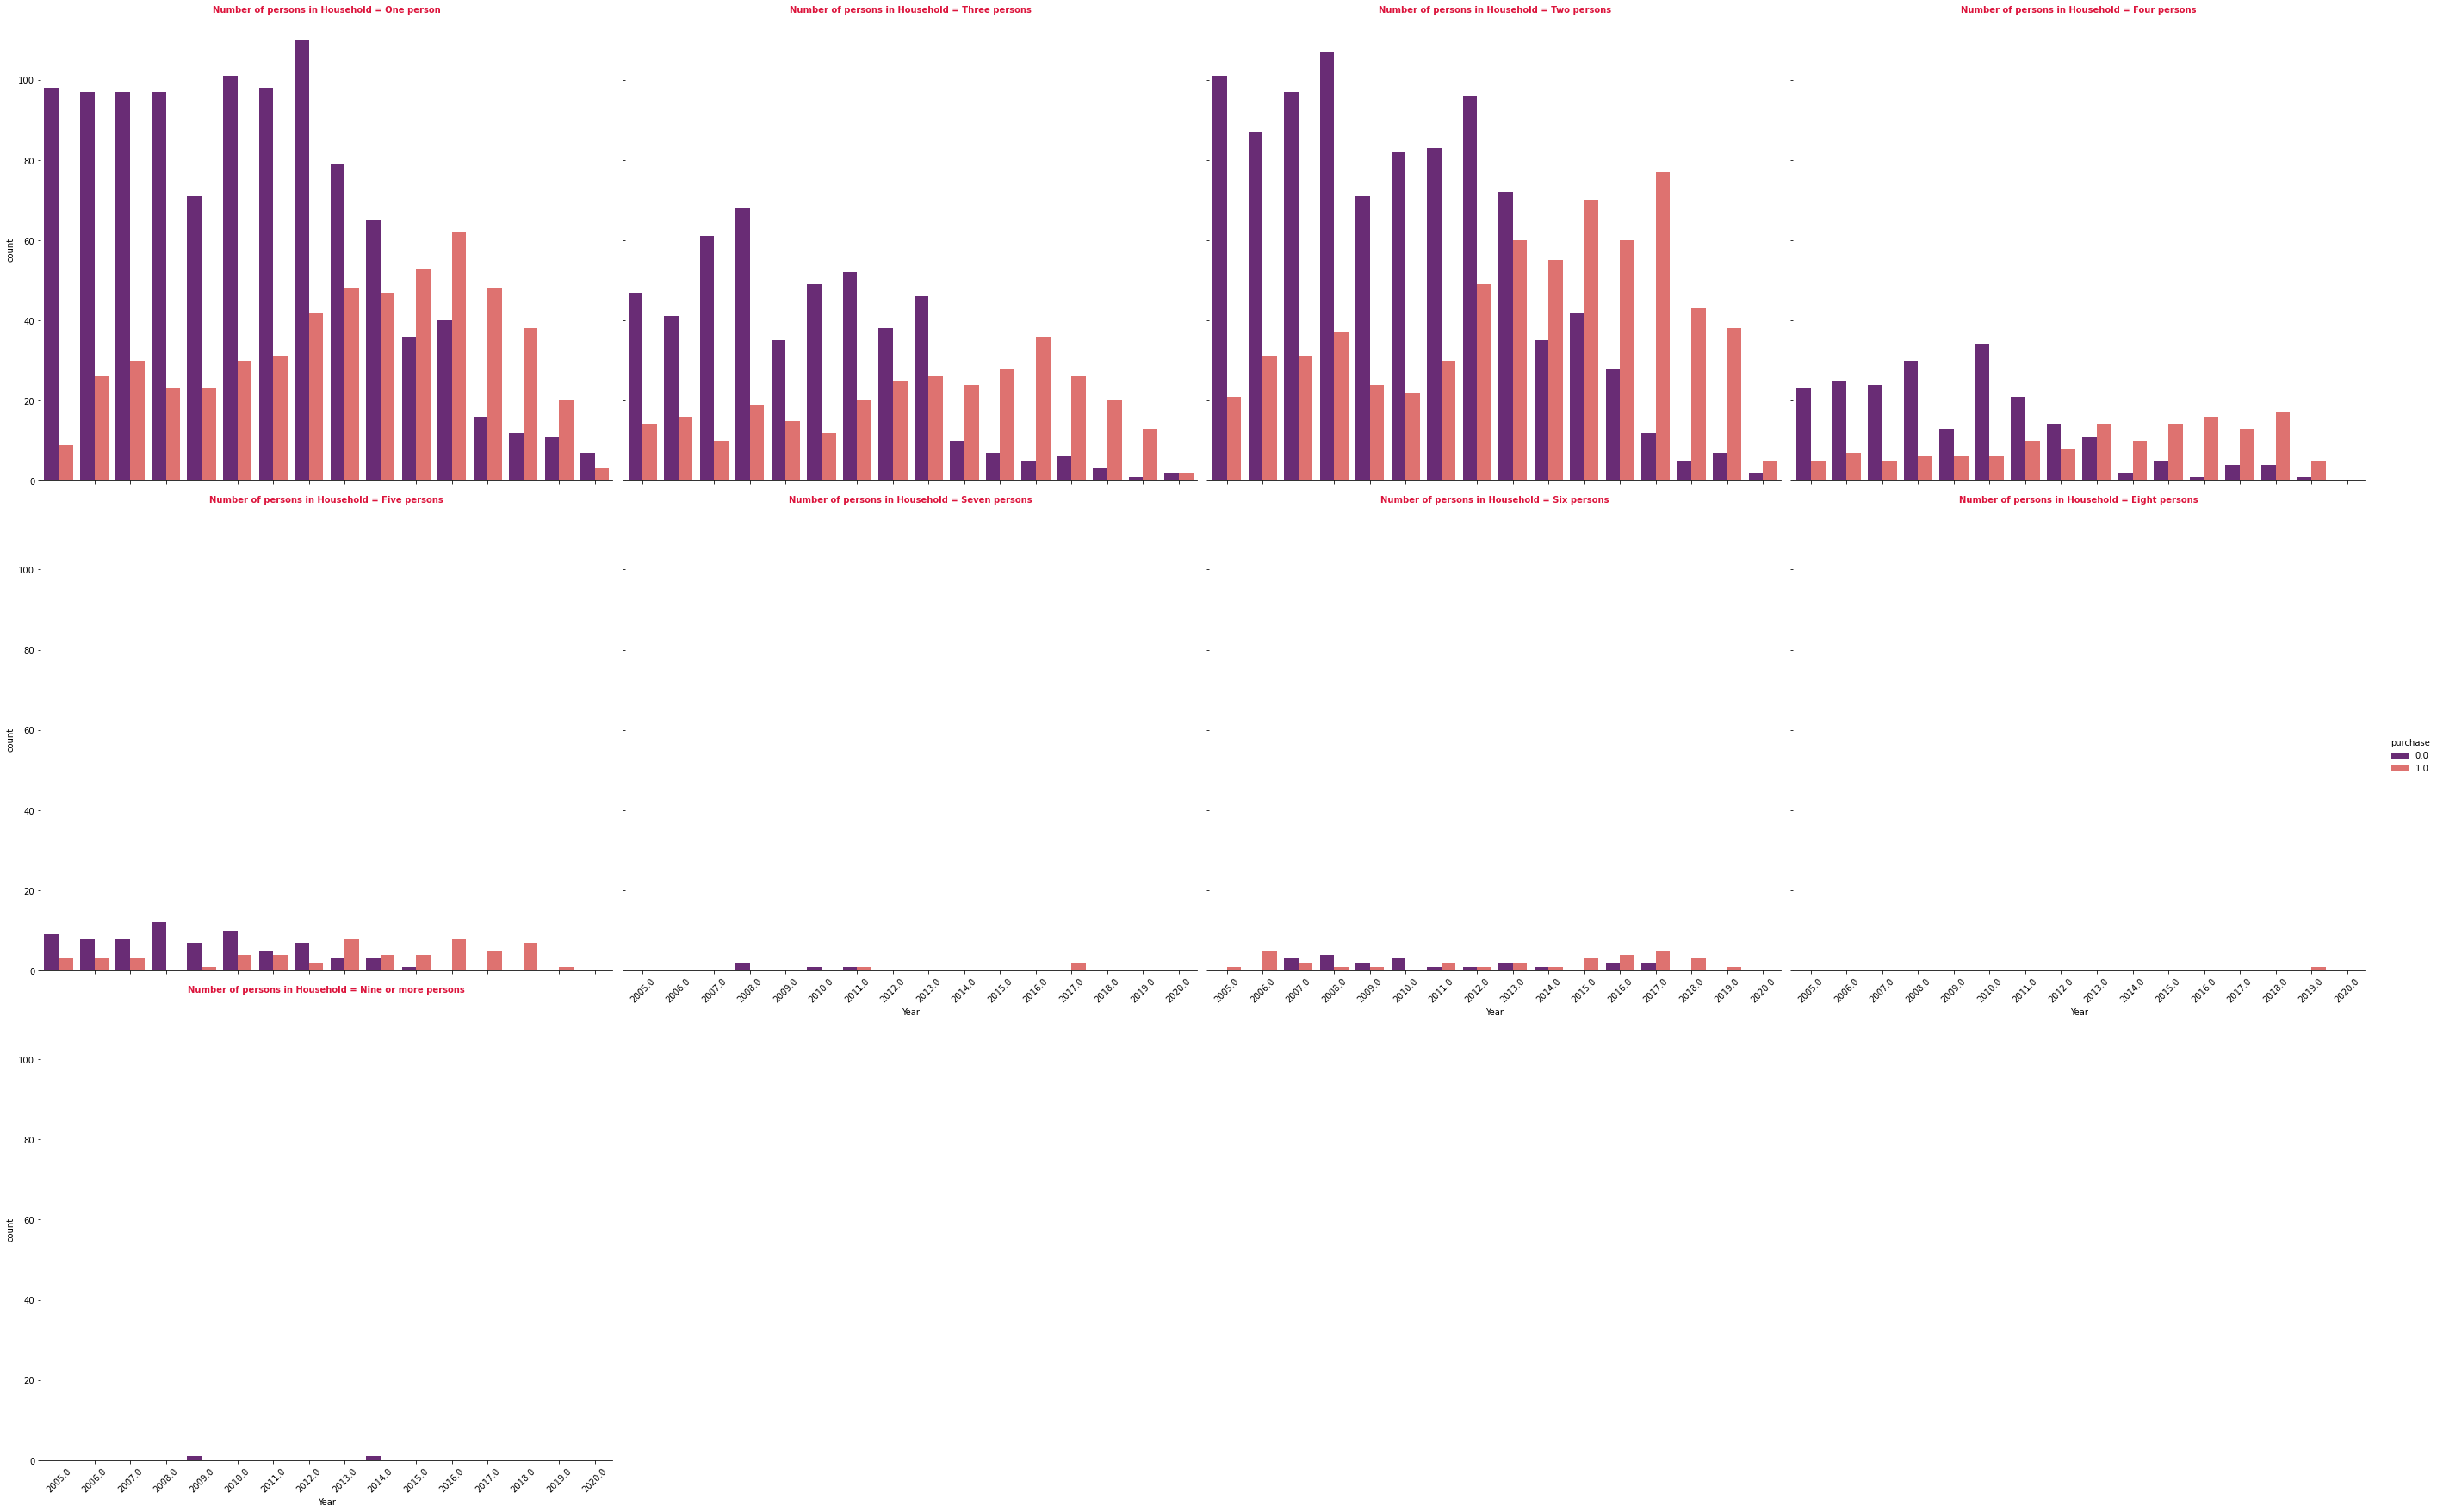

In [33]:
fig = sns.catplot(data=plot_da.query("Year>=2005"),x="Year",col="Number of persons in Household",kind="count",
                  hue="purchase",palette="magma",col_wrap=4,height=8, aspect=1.2)
fig.set_xticklabels(rotation=45,fontsize=10)
fig.set_titles(fontsize=20,color="crimson",weight="bold")
fig.despine(left=True)
plt.show()

$\color{crimson}{\bf{\text{Interpretation:}}}$

Given that the sample size for some categories is too small, no useful insighst can be obtained.

#### Purchase Versus Household Income

In [34]:
plot_da["Household Income"] = plot_da["Household Income"].apply(lambda x:str(x).strip())
plot_da["Household Income"].unique()
orders = ["Under $10K","$10K - $20K","$20K - $30K","$30K - $40K","$40K - $50K","$50K - $60K",
         "$60K - $70K","$70K - $80K","$70K - $80K","$80K - $90K","$90K - $100K","$100K - $150K",
         "$150K - $175K","$175K - $200K","$200K - $250K"]

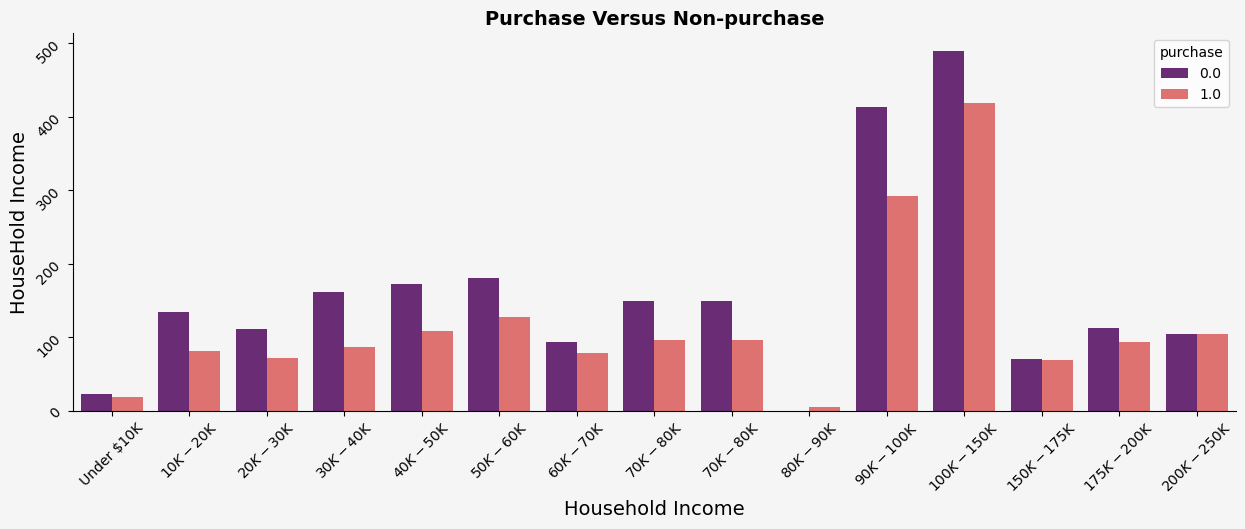

In [35]:
fig,ax = plt.subplots(1,1,figsize=(15,5),dpi=100,facecolor="whitesmoke")
sns.countplot(data=plot_da,x="Household Income",hue="purchase",ax=ax,palette="magma",order=orders)
ax.set_facecolor("whitesmoke")
ax.set_xlabel("Household Income",fontsize=14)
ax.set_ylabel("HouseHold Income",fontsize=14)
ax.set_title("Purchase Versus Non-purchase",fontsize=14,weight="bold")
for spine in ["top","right"]:
    ax.spines[spine].set_visible(False)
ax.tick_params(rotation=45)
plt.show()

#### Purchase Versus Household Size

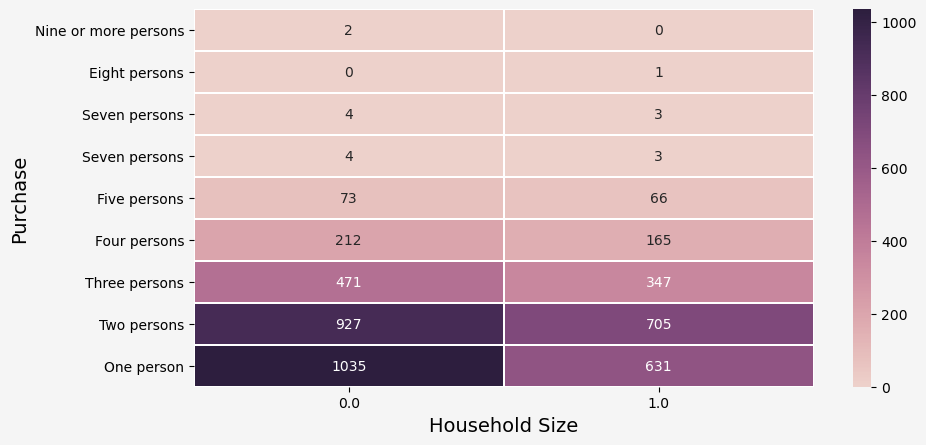

In [36]:
temp = plot_da.dropna(subset=["Number of persons in Household"])
cross_tab = pd.crosstab(temp["Number of persons in Household"],temp["purchase"])
new_index = ['Nine or more persons','Eight persons','Seven persons','Seven persons','Five persons',
 'Four persons','Three persons','Two persons','One person']
temp_ = cross_tab.reindex(new_index)
fig, ax = plt.subplots(1,1,figsize=(10,5),dpi=100,facecolor="whitesmoke")
cmap = sns.cubehelix_palette(as_cmap=True)
sns.heatmap(temp_,annot=True,fmt="d",cmap=cmap,linewidths=.5,ax=ax)
ax.set_facecolor("whitesmoke")
ax.set_xlabel("Household Size",fontsize=14)
ax.set_ylabel("Purchase",fontsize=14)
plt.show()


#### Purchase Versus Last Owner Length Of Ownership In Days

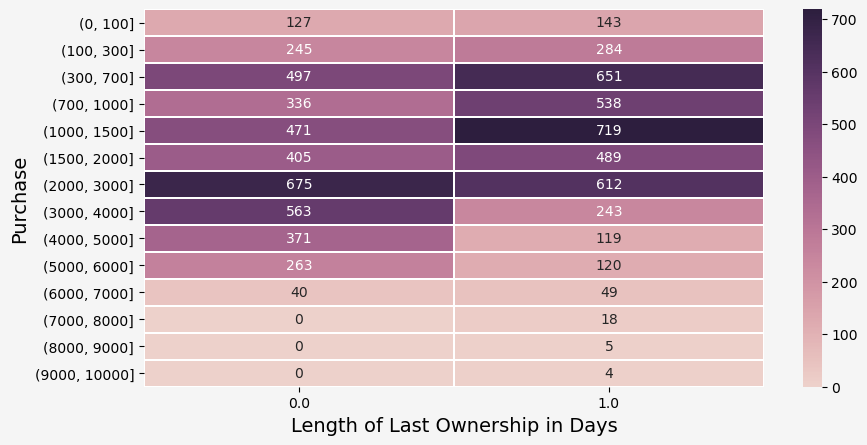

In [37]:
plot_da["ownership_day_bins"] = pd.cut(plot_da["Last Owner Length Of Ownership In Days"],
                                      [0,100,300,700,1000,1500,2000,3000,4000,5000,6000,7000,8000,9000,10000,11000])
cross_tab = pd.crosstab(plot_da["ownership_day_bins"],plot_da["purchase"])
fig, ax = plt.subplots(1,1,figsize=(10,5),dpi=100,facecolor="whitesmoke")
cmap = sns.cubehelix_palette(as_cmap=True)
sns.heatmap(cross_tab,annot=True,fmt="d",cmap=cmap,linewidths=.5,ax=ax)
ax.set_facecolor("whitesmoke")
ax.set_xlabel("Length of Last Ownership in Days",fontsize=14)
ax.set_ylabel("Purchase",fontsize=14)
plt.show()

$\color{crimson}{\bf{\text{Interpretation:}}}$

Our hunch is that the longer you hold the car, the harder you sell it. So customers should be less likely to buy the car owned by someone for ver long time. But we need to know the exact **turning point.**

Here's our observation obtained from data: tire purchasers are always more than tire non-purchasers for cars owned for less than 2000 days. But the trend is reversed when the figure is greater than 2000, number of tire non-buyers exceeding that of tire buyers. The figure 2000 is the turning point that we are looking for. 

Also, after 6000 days, the sample size is very small, and so the value is very small. We cannot obtain useful insights from it.

**Therefore, we create one variable to indicate the insight.**

In [38]:
balanced_da["longer_than_2000"] = (balanced_da["Last Owner Length Of Ownership In Days"]>2000).astype("int64")

##### Purchase Versus Last Owner Length Of Ownership In Days by Gender

<AxesSubplot:ylabel='purchase'>

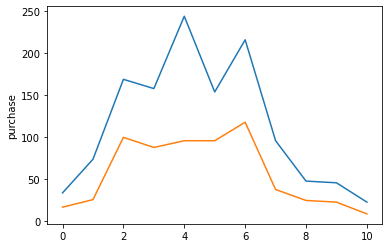

In [39]:
temp = pd.crosstab([plot_da["ownership_day_bins"],plot_da["Gender Code"]],plot_da["purchase"]).reset_index()
temp = temp.rename(columns={'Gender Code':"Gender",0.0:"no_purchase",1.0:"purchase"})
temp = temp.query("no_purchase>0")

male_purchase = temp.query('Gender=="Male"').purchase
female_purchase = temp.query('Gender=="Female"').purchase
x = np.arange(len(temp.query('Gender=="Male"').ownership_day_bins))
sns.lineplot(x,male_purchase)
sns.lineplot(x,female_purchase)

<AxesSubplot:ylabel='no_purchase'>

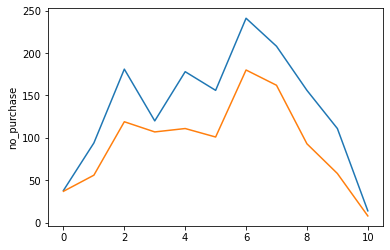

In [40]:
male_nopurchase = temp.query('Gender=="Male"').no_purchase
female_nopurchase = temp.query('Gender=="Female"').no_purchase
x = np.arange(len(temp.query('Gender=="Male"').ownership_day_bins))
sns.lineplot(x,male_nopurchase)
sns.lineplot(x,female_nopurchase)

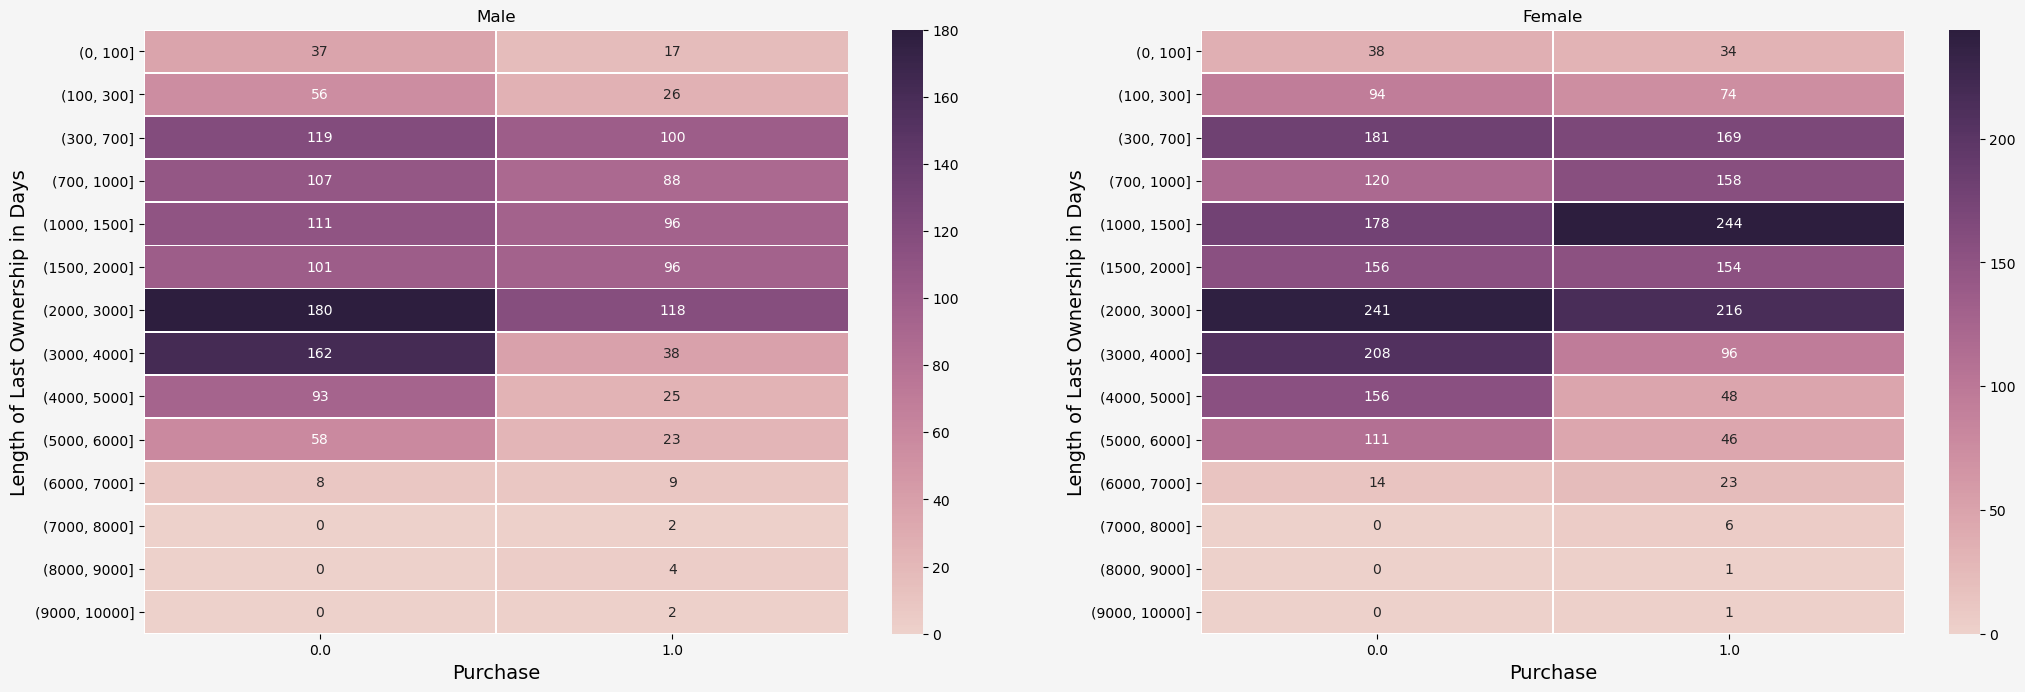

In [41]:
cross_tab = pd.crosstab([plot_da['Gender Code'],plot_da["ownership_day_bins"]],plot_da["purchase"],dropna=True)
temp = cross_tab.reset_index()

# Heatmap for male
fig, axes = plt.subplots(1,2,figsize=(25,8),dpi=100,facecolor="whitesmoke")
cmap = sns.cubehelix_palette(as_cmap=True)
sns.heatmap(temp[temp["Gender Code"]=="Female"].drop("Gender Code",axis=1).set_index("ownership_day_bins"),
            annot=True,fmt="d",cmap=cmap,linewidths=.5,ax=axes[0])
axes[0].set_facecolor("whitesmoke")
axes[0].set_ylabel("Length of Last Ownership in Days",fontsize=14)
axes[0].set_xlabel("Purchase",fontsize=14)
axes[0].set_title("Male")

# Heatmap for female
sns.heatmap(temp[temp["Gender Code"]=="Male"].drop("Gender Code",axis=1).set_index("ownership_day_bins"),
            annot=True,fmt="d",cmap=cmap,linewidths=.5,ax=axes[1])
axes[1].set_facecolor("whitesmoke")
axes[1].set_ylabel("Length of Last Ownership in Days",fontsize=14)
axes[1].set_xlabel("Purchase",fontsize=14)
axes[1].set_title("Female")

plt.show()

##### Purchase Versus Last Owner Length Of Ownership In Days by Marital Status

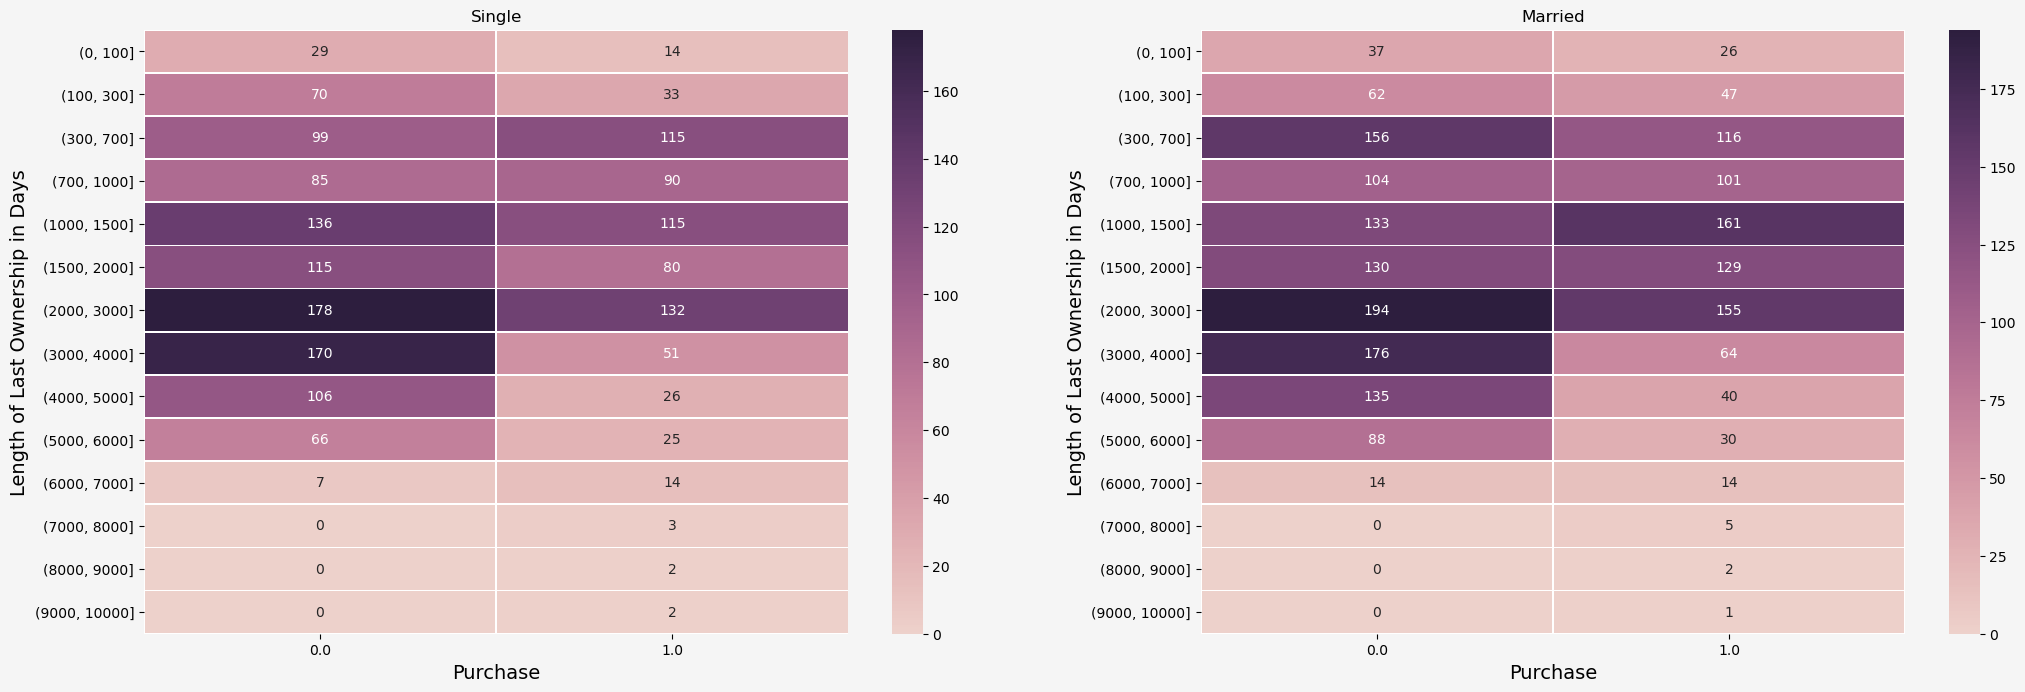

In [42]:
cross_tab = pd.crosstab([plot_da['Marital Status'],plot_da["ownership_day_bins"]],plot_da["purchase"],dropna=True)
temp = cross_tab.reset_index()

# Heatmap for Single
fig, axes = plt.subplots(1,2,figsize=(25,8),dpi=100,facecolor="whitesmoke")
cmap = sns.cubehelix_palette(as_cmap=True)
sns.heatmap(temp[temp["Marital Status"]=="Single"].drop("Marital Status",axis=1).set_index("ownership_day_bins"),
            annot=True,fmt="d",cmap=cmap,linewidths=.5,ax=axes[0])
axes[0].set_facecolor("whitesmoke")
axes[0].set_ylabel("Length of Last Ownership in Days",fontsize=14)
axes[0].set_xlabel("Purchase",fontsize=14)
axes[0].set_title("Single")

# Heatmap for female
sns.heatmap(temp[temp["Marital Status"]=="Married"].drop("Marital Status",axis=1).set_index("ownership_day_bins"),
            annot=True,fmt="d",cmap=cmap,linewidths=.5,ax=axes[1])
axes[1].set_facecolor("whitesmoke")
axes[1].set_ylabel("Length of Last Ownership in Days",fontsize=14)
axes[1].set_xlabel("Purchase",fontsize=14)
axes[1].set_title("Married")

plt.show()

#### Purchase Versus Age

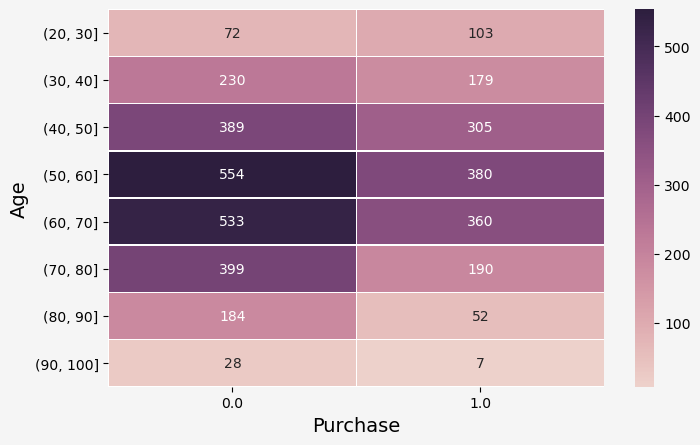

In [43]:
plot_da["age_bins"] = pd.cut(plot_da.Age,[20,30,40,50,60,70,80,90,100])

cross_tab = pd.crosstab(plot_da["age_bins"],plot_da["purchase"])

fig, ax = plt.subplots(1,1,figsize=(8,5),dpi=100,facecolor="whitesmoke")
cmap = sns.cubehelix_palette(as_cmap=True)
sns.heatmap(cross_tab,annot=True,fmt="d",cmap=cmap,linewidths=.5,ax=ax)
ax.set_facecolor("whitesmoke")
ax.set_xlabel("Purchase",fontsize=14)
ax.set_ylabel("Age",fontsize=14)
plt.show()

$\color{crimson}{\bf{\text{Interpretation:}}}$

- The number of tire purchasers increase with increaseing ages, while the number of tire non-buyers also increases with ages.
- Tire purchasers are always more than those who did not purchase tires across different age bands.

The age, based on the plot, does not impact the consumer's decision making about purchase.

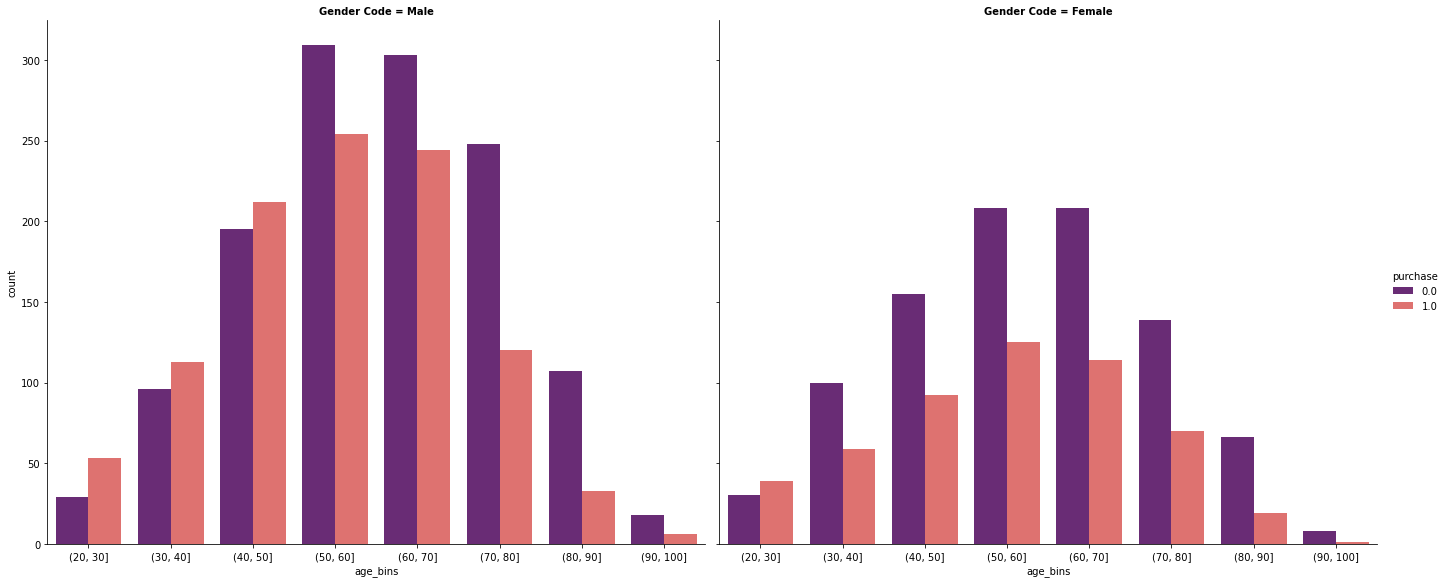

In [44]:
sns.cubehelix_palette(as_cmap=True)
fig = sns.catplot(data=plot_da,x="age_bins",kind="count",col="Gender Code",hue="purchase",palette="magma",
            height=8,aspect=1.2)
fig.set_titles(fontsize=20,weight="bold")
plt.show()

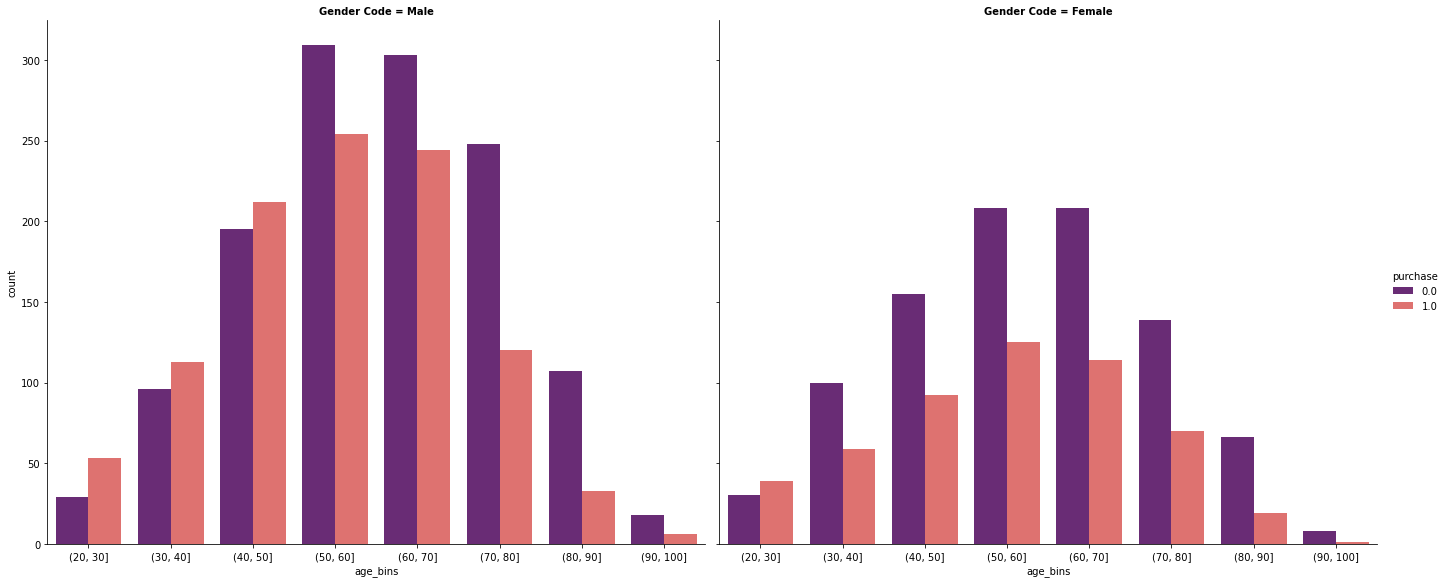

In [45]:
sns.cubehelix_palette(as_cmap=True)
fig = sns.catplot(data=plot_da,x="age_bins",kind="count",col="Gender Code",hue="purchase",palette="magma",
            height=8,aspect=1.2)
fig.set_titles(fontsize=20,weight="bold")
plt.show()

##### Purchase Versus Age by Marital Status

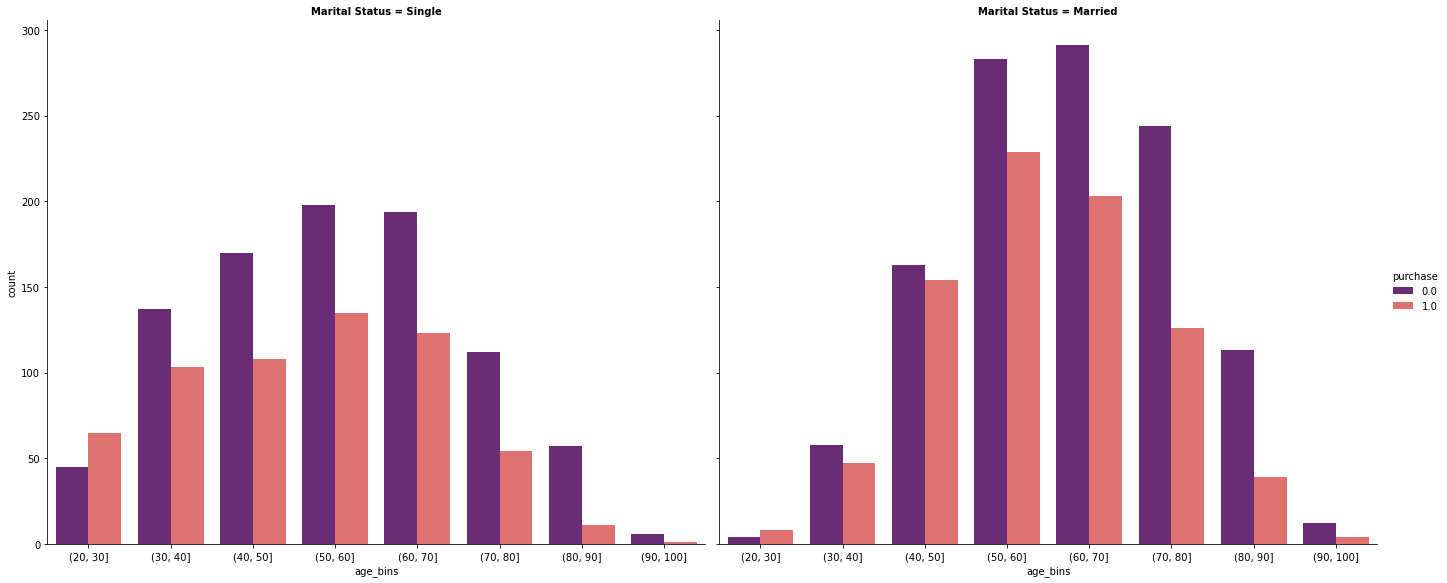

In [46]:
sns.cubehelix_palette(as_cmap=True)
fig = sns.catplot(data=plot_da,x="age_bins",kind="count",col="Marital Status",hue="purchase",palette="magma",
            height=8,aspect=1.2)
fig.set_titles(fontsize=20,weight="bold")
plt.show()

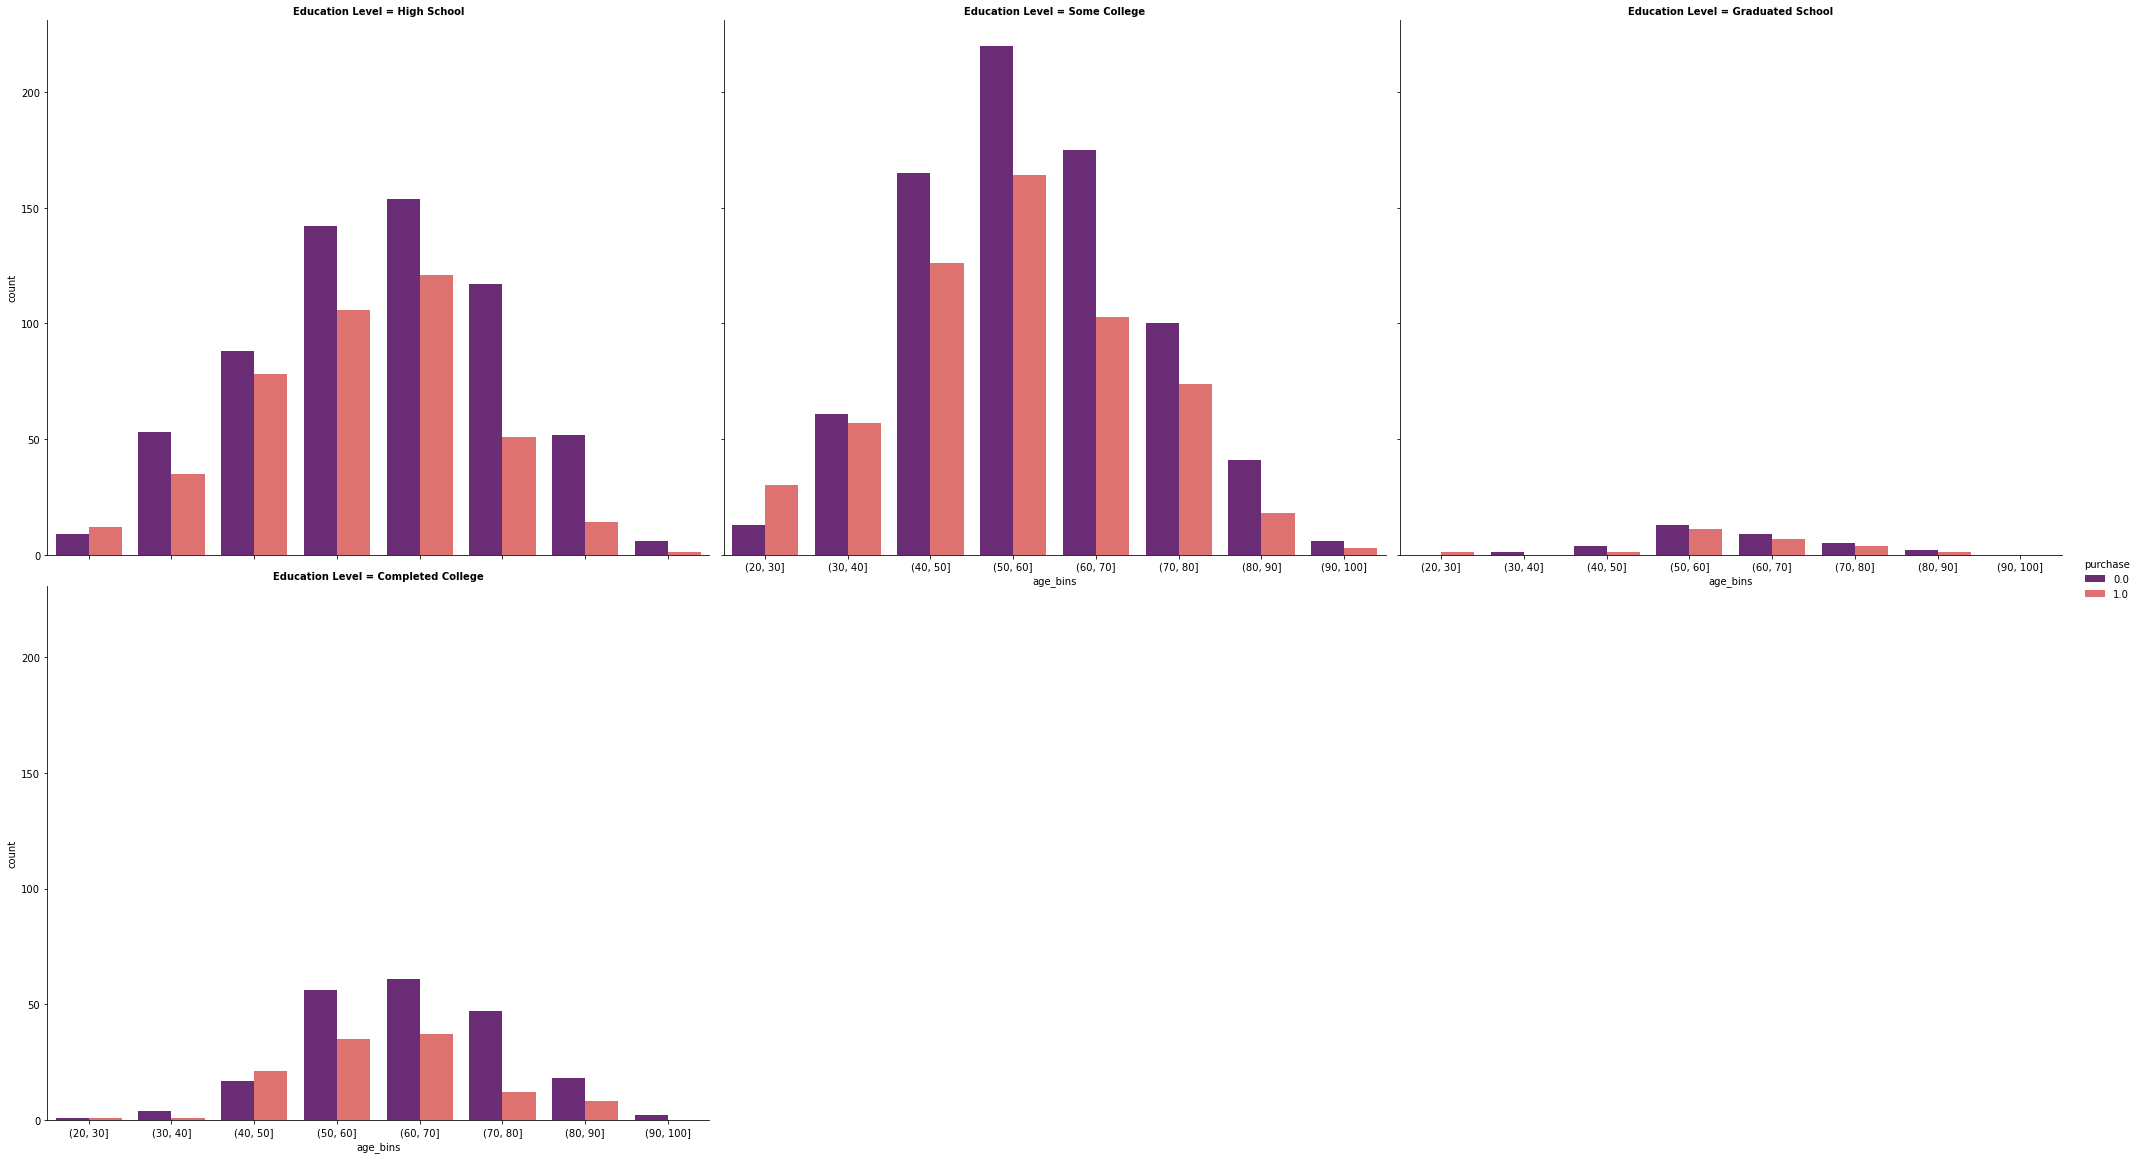

In [47]:
sns.cubehelix_palette(as_cmap=True)
fig = sns.catplot(data=plot_da,x="age_bins",kind="count",col="Education Level",hue="purchase",palette="magma",
            height=8,aspect=1.2,col_wrap=3)
fig.set_titles(fontsize=20,weight="bold")
plt.show()

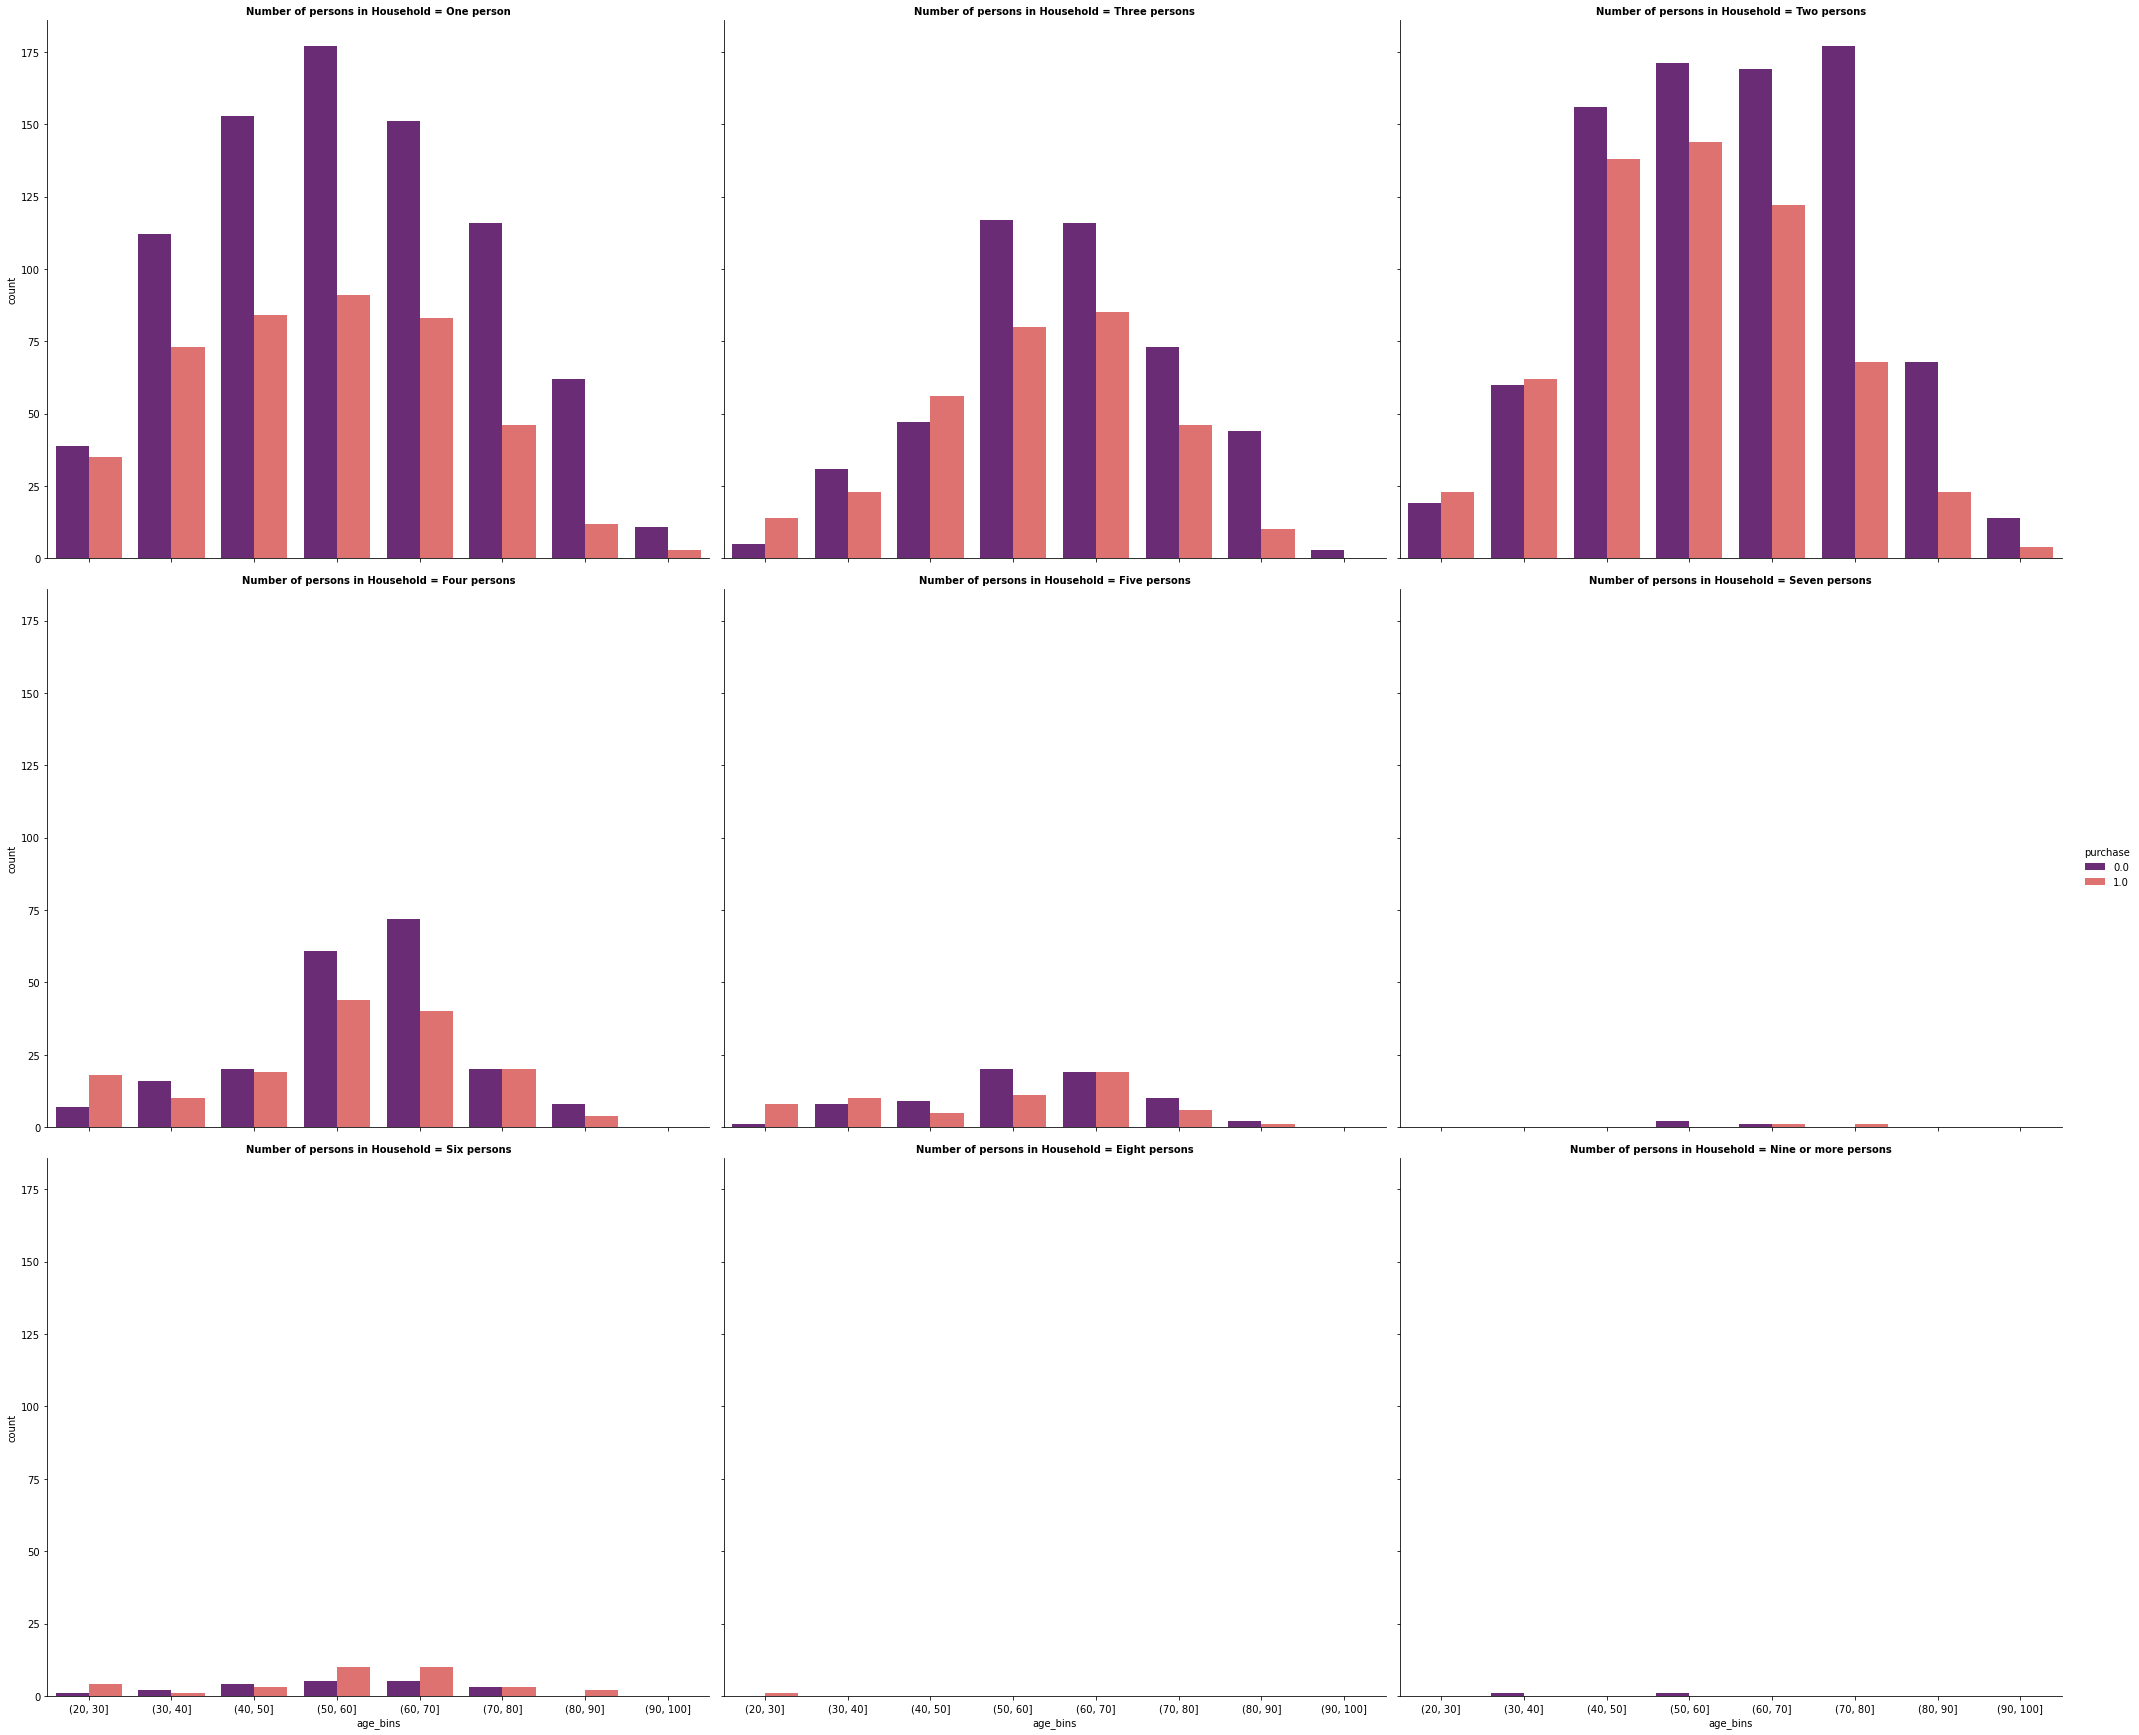

In [48]:
sns.cubehelix_palette(as_cmap=True)
fig = sns.catplot(data=plot_da,x="age_bins",kind="count",col="Number of persons in Household",hue="purchase",palette="magma",
            height=8,aspect=1.2,col_wrap=3)
fig.set_titles(fontsize=20,weight="bold")
plt.show()

#### Purchase Versus Odometer

if miles showing on odometor is from 60,000 to 75,000, the consumers need to make tire replacements by 4 tires at once. So we examine whether the hunch can be confirmed in the dataset.

In [49]:
def cut_odometers(x):
    if x>=0 and x<60000:
        return "(0,60000]"
    elif x>=60000 and x<75000:
        return "(60000,75000]"
    elif x>=75000 and x<135000:
        return "(75000,135000]"
    elif x>=135000 and x<150000:
        return "(135000,150000]"
    elif x>=150000 and x<210000:
        return "(150000,210000]"
    elif x>=210000 and x<225000:
        return "(210000,225000]"
    else:
        return "225000 or more"


plot_da["odometer_bins"] = plot_da["Estimated Current Odometer"].apply(lambda x:cut_odometers(x))

In [50]:
cross_tab = pd.crosstab(plot_da["odometer_bins"],plot_da["purchase"])
cross_tab_ = cross_tab.reindex(["(0,60000]","(60000,75000]","(75000,135000]","(135000,150000]","(150000,210000]","(210000,225000]","225000 or more"])

cross_tab_["purchase_rate"] = cross_tab_.iloc[:,1]/(cross_tab_.iloc[:,0]+cross_tab_.iloc[:,1])

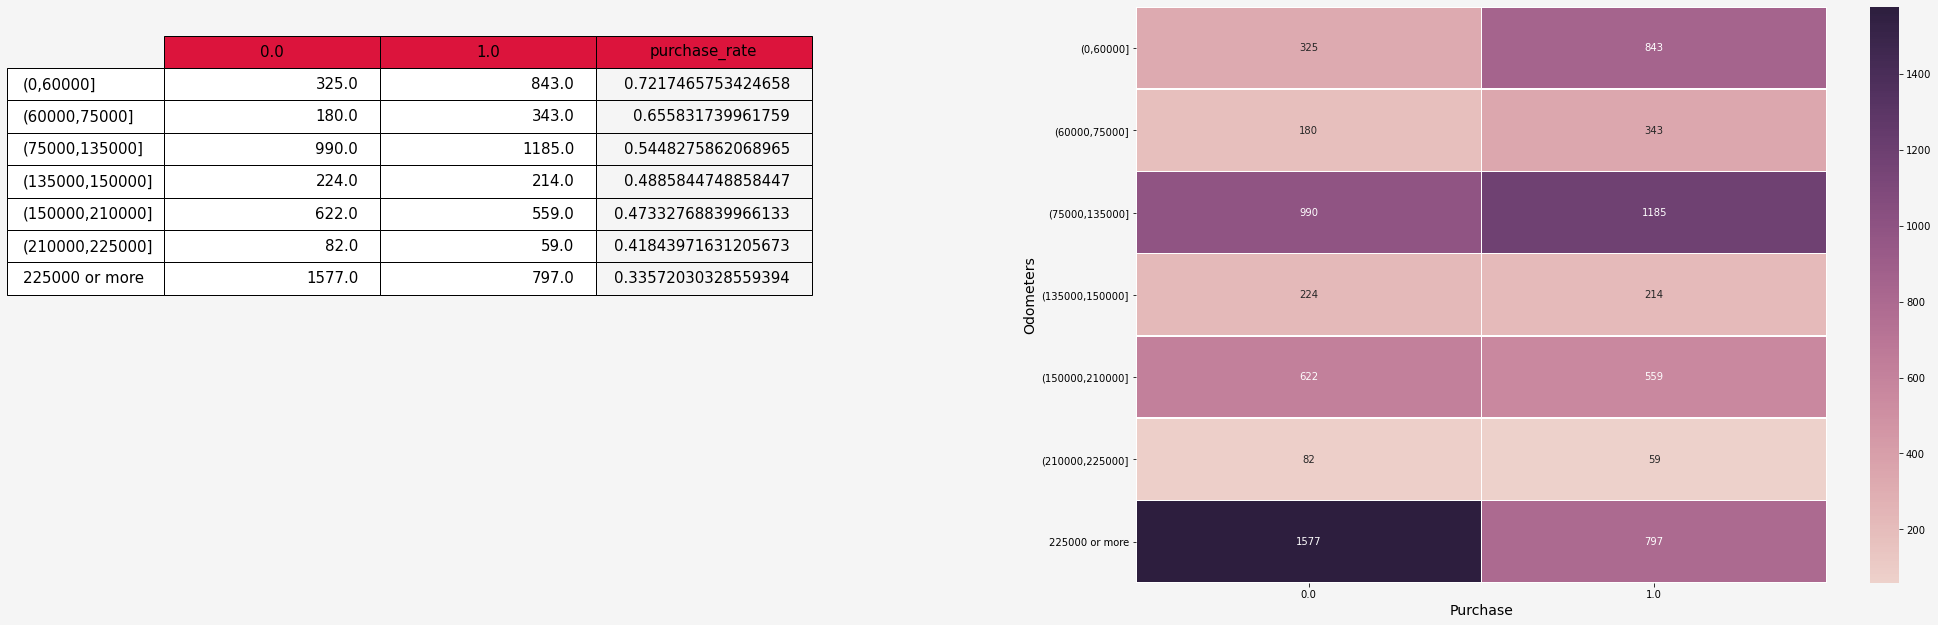

In [51]:
color_list=[['white', 'white',"whitesmoke"]]

fig = plt.figure(facecolor='whitesmoke')
ax1 = fig.add_axes([0, 0, 1, 1]) 
ax2 = fig.add_axes([2,0,2, 2], facecolor='whitesmoke') 


ax1.axis("off")
ax1.axis("tight")
table = ax1.table(cellText=cross_tab_.values,
         rowLabels=cross_tab_.index,
         colLabels=cross_tab_.columns,
         colColours=['crimson']*3, cellColours=color_list*7,
         loc='top')
table.scale(1.5, 2.7) 
#table.auto_set_font_size(False) 
table.set_fontsize(16)  
plt.subplots_adjust(left=0.2, top=0.8)


cmap = sns.cubehelix_palette(as_cmap=True)
sns.heatmap(cross_tab_.iloc[:,:-1],annot=True,fmt="d",cmap=cmap,linewidths=.5,ax=ax2)
ax2.set_facecolor("whitesmoke")
ax2.set_xlabel("Purchase",fontsize=14)
ax2.set_ylabel("Odometers",fontsize=14)
plt.show()

$\color{crimson}{\bf{\text{Interpretation:}}}$

The purchase rate decreases with increaseing odometers. The highest purchase occurs in the range of (0,60000), suggesting that customers whose cars have less than 60000 odometers are more likely to purchase tires.

In [52]:
balanced_da["odo_smaller_than_60000"] = balanced_da["Estimated Current Odometer"]<=60000

##### Purchase Versus Odometer by Gender

Text(0.5, 1.0, 'No purchase')

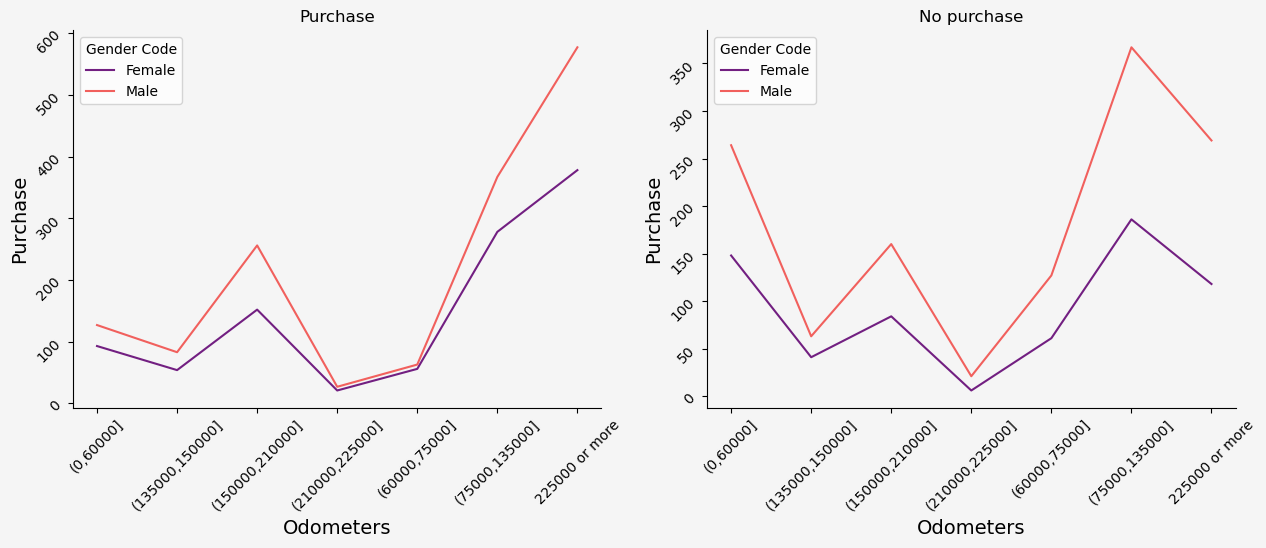

In [53]:
cross_tab = pd.crosstab([plot_da['Gender Code'],plot_da["odometer_bins"]],plot_da["purchase"],dropna=True)
temp = cross_tab.reset_index()
temp.columns = ["Gender Code","odometer_bins","purchase",'no purchase']

# Lineplot for purchase
fig, ax = plt.subplots(1,2,figsize=(15,5),dpi=100,facecolor="whitesmoke")
sns.lineplot(data=temp,x="odometer_bins",y="purchase",hue="Gender Code",ax=ax[0],palette="magma")
ax[0].set_facecolor("whitesmoke")
ax[0].set_xlabel("Odometers",fontsize=14)
ax[0].set_ylabel("Purchase",fontsize=14)
for spine in ["top","right"]:
    ax[0].spines[spine].set_visible(False)
ax[0].tick_params(rotation=45)
ax[0].set_title("Purchase")
    
# Lineplot for no purchase
sns.lineplot(data=temp,x="odometer_bins",y="no purchase",hue="Gender Code",ax=ax[1],palette="magma")
ax[1].set_facecolor("whitesmoke")
ax[1].set_xlabel("Odometers",fontsize=14)
ax[1].set_ylabel("Purchase",fontsize=14)
for spine in ["top","right"]:
    ax[1].spines[spine].set_visible(False)
ax[1].tick_params(rotation=45)
ax[1].set_title("No purchase")

$\color{crimson}{\bf{\text{Interpretation:}}}$

No particular pattern can be found because the two line charts show the exactly same changes across different level of odometers.

##### Purchase Versus Odometer by Education Level

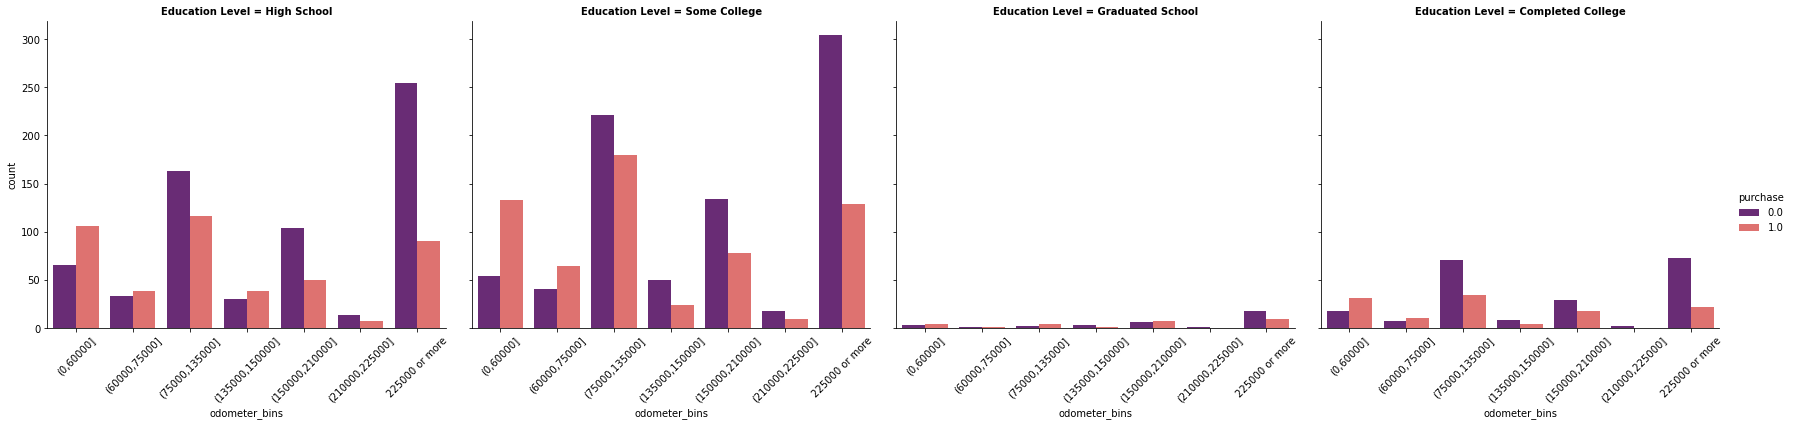

In [54]:
x_order = ["(0,60000]","(60000,75000]","(75000,135000]","(135000,150000]","(150000,210000]","(210000,225000]","225000 or more"]
fig = sns.catplot(data=plot_da,x="odometer_bins",kind="count",col="Education Level",hue='purchase',
           palette="magma",order=x_order,height=5,aspect=1.2)
fig.set_xticklabels(rotation=45)
fig.set_titles(fontsize=20,weight="bold")
plt.show()

$\color{crimson}{\bf{\text{Interpretation:}}}$

No partiluar patterns can be identified.

#### Purchase Versus Gender Code

In [55]:
# extract the purchase data by year
res = plot_da.dropna(subset=["Gender Code","purchase"]).groupby(["Gender Code","purchase"]).agg({"Gender Code":"count"}).\
rename(columns={"Gender Code":"count"})
temp = res.reset_index()

# copy temp
temp_x = temp.copy()
# calculate purchase rate
temp_x["proportion"] = temp_x.groupby("Gender Code").transform(lambda x:x/x.sum())["count"]


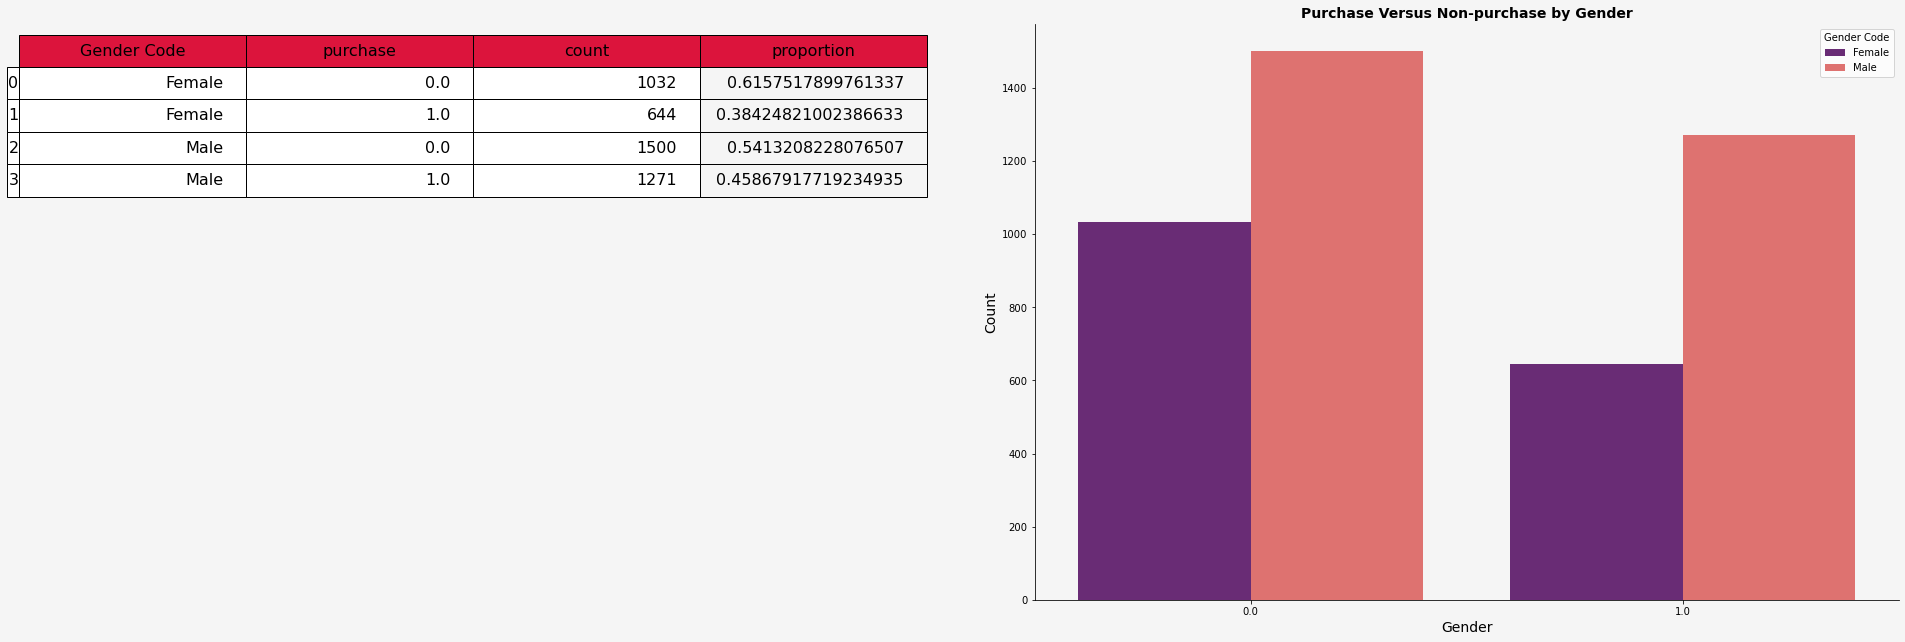

In [56]:
color_list=[['white', 'white','white',"whitesmoke"]]

fig = plt.figure(facecolor='whitesmoke')
ax1 = fig.add_axes([0, 0, 1.4, 1.4]) 
ax2 = fig.add_axes([2,0,2, 2], facecolor='whitesmoke') 


ax1.axis("off")
ax1.axis("tight")
table = ax1.table(cellText=temp_x.values,
         rowLabels=temp_x.index,
         colLabels=temp_x.columns,
         colColours=['crimson']*4, cellColours=color_list*4,
         loc='top')
table.scale(1.5, 2.7) 
#table.auto_set_font_size(False) 
table.set_fontsize(16)  

# plot lines
sns.barplot(data=temp,x="purchase",y="count",hue="Gender Code",ax=ax2,palette="magma")
ax2.set_facecolor("whitesmoke")
ax2.set_xlabel("Gender",fontsize=14)
ax2.set_ylabel("Count",fontsize=14)
ax2.set_title("Purchase Versus Non-purchase by Gender",fontsize=14,weight="bold")
for spine in ["top","right"]:
    ax2.spines[spine].set_visible(False)
plt.show()

$\color{crimson}{\bf{\text{Interpretation:}}}$

- For either buyers or non-buyers, males are more than females.
- The purchase rate of males is higher than that of female customers, suggesting that males are more likely to buy tires.

#### Purchase Versus Number of Owners

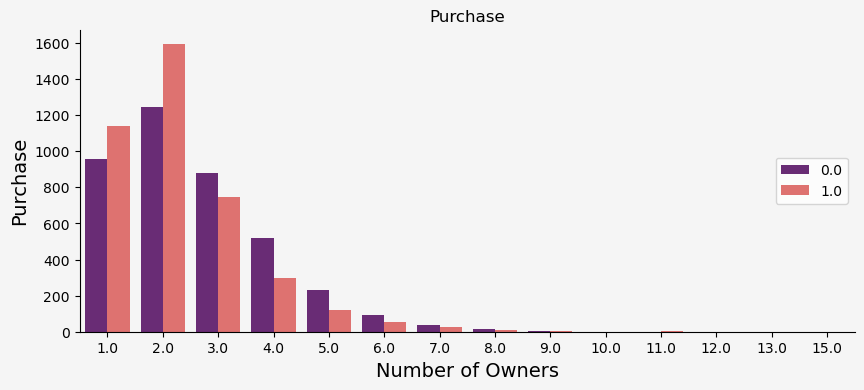

In [57]:
fig, ax = plt.subplots(1,1,figsize=(10,4),dpi=100,facecolor="whitesmoke")
sns.countplot(data=plot_da,x='Number Of Owners',hue="purchase",palette="magma")
ax.set_facecolor("whitesmoke")
ax.set_xlabel("Number of Owners",fontsize=14)
ax.set_ylabel("Purchase",fontsize=14)
for spine in ["top","right"]:
    ax.spines[spine].set_visible(False)
ax.set_title("Purchase")
plt.legend(loc="right")
plt.show()

$\color{crimson}{\bf{\text{Interpretation:}}}$

- If the car has at most 2 owners, the number of tire purchasers is greater than that of tire non-buyers.
- The trend is reversed when the car has more than two owners.

In [58]:
balanced_da["owners_less_than_2"] = (balanced_da["Number Of Owners"]<=2).astype("int64")

#### Purchase Versus Number of Young Adults

In [59]:
# extract the purchase data by year
res = plot_da.dropna(subset=["Number of Adults in Household","purchase"]).groupby(["Number of Adults in Household","purchase"]).agg({"Number of Adults in Household":"count"}).\
rename(columns={"Number of Adults in Household":"count"})
temp = res.reset_index()

# copy temp
temp_x = temp.copy()
temp_x["Number of Adults in Household"] = temp_x["Number of Adults in Household"].replace({"Five adults":5,"Four adults":4,"One adult":1,
                                                "Seven adults":7,"Six adults":6,"Three adults":3,
                                                "Two adults":2})
# calculate purchase rate
temp_x["proportion"] = temp_x.groupby("Number of Adults in Household").transform(lambda x:x/x.sum())["count"]
sort_tempx = temp_x.sort_values(by="Number of Adults in Household")

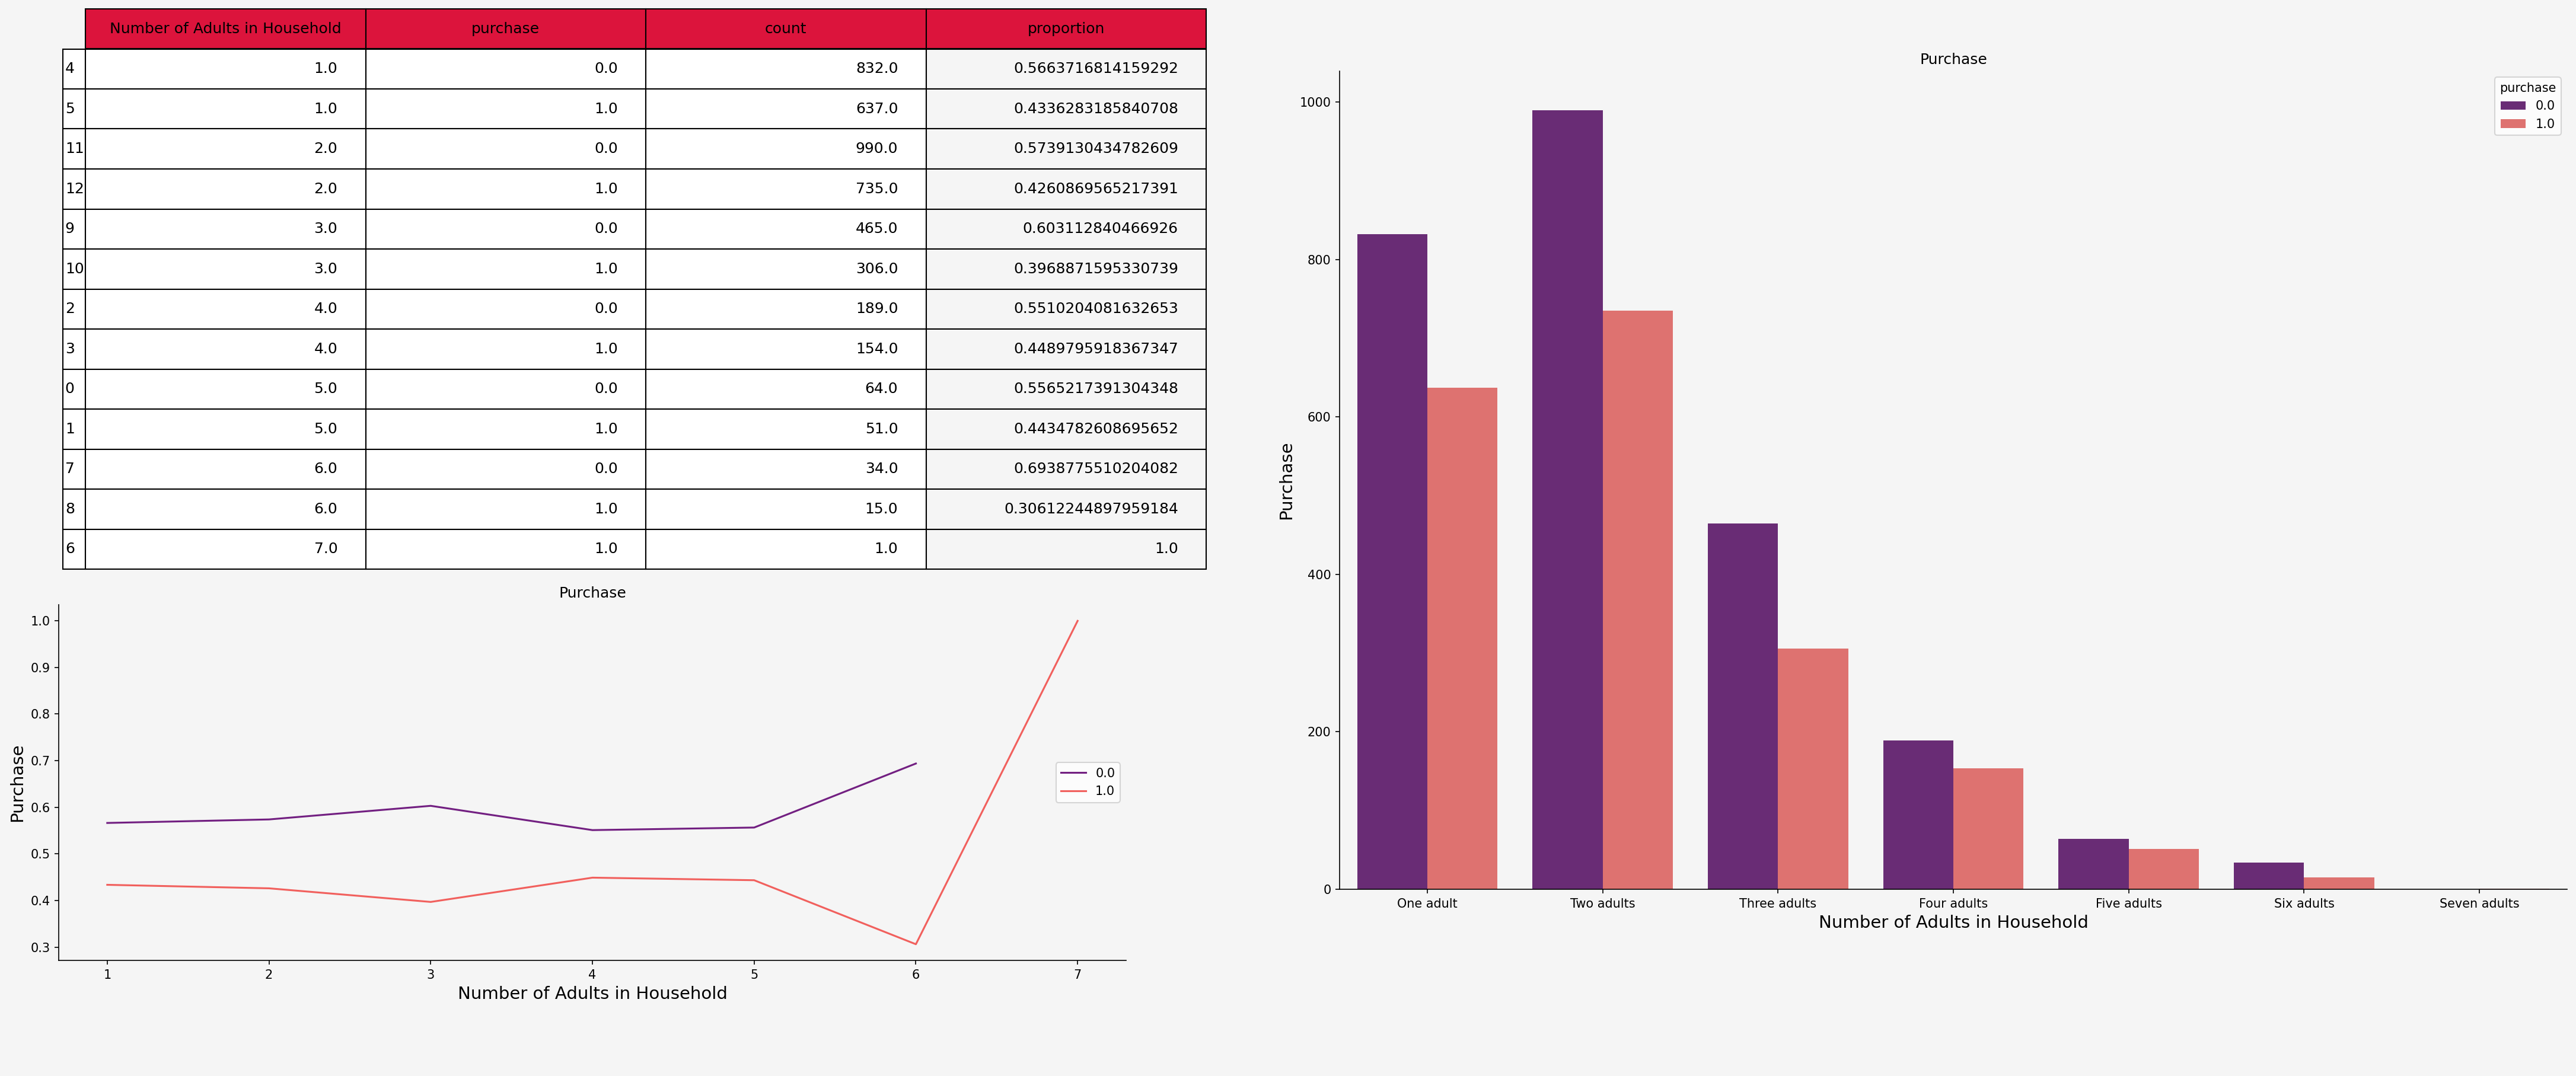

In [60]:
color_list=[['white', 'white','white',"whitesmoke"]]

fig = plt.figure(facecolor='whitesmoke',dpi=150)
ax1 = fig.add_axes([0, 0, 1.4, 1.4]) 
ax2 = fig.add_axes([2,0.5,2.3, 2.3], facecolor='whitesmoke') 
ax3 = fig.add_axes([-0.4,0.3,2,1])

ax1.axis("off")
ax1.axis("tight")
table = ax1.table(cellText=sort_tempx.values,
         rowLabels=sort_tempx.index,
         colLabels=sort_tempx.columns,
         colColours=['crimson']*4, cellColours=color_list*13,
         loc='top')
table.scale(1.5, 2.7) 
#table.auto_set_font_size(False) 
table.set_fontsize(16)  


sns.countplot(data=plot_da,x='Number of Adults in Household',hue="purchase",palette="magma",
             order=['One adult','Two adults','Three adults','Four adults','Five adults','Six adults','Seven adults'],
             ax=ax2)
ax2.set_facecolor("whitesmoke")
ax2.set_xlabel("Number of Adults in Household",fontsize=14)
ax2.set_ylabel("Purchase",fontsize=14)
for spine in ["top","right"]:
    ax2.spines[spine].set_visible(False)
ax2.set_title("Purchase")
ax2.set_facecolor("whitesmoke")


sns.lineplot(data=sort_tempx,x="Number of Adults in Household",y="proportion",hue="purchase",ax=ax3,palette="magma")
ax3.set_facecolor("whitesmoke")
ax3.set_xlabel("Number of Adults in Household",fontsize=14)
ax3.set_ylabel("Purchase",fontsize=14)
for spine in ["top","right"]:
    ax3.spines[spine].set_visible(False)
ax3.set_title("Purchase")


plt.legend(loc="right")
plt.show()

$\color{crimson}{\bf{\text{Interpretation:}}}$

- The segment of seven adults has only one sample, so the purchase rate increases dramatically. 
- The purchase rate remains relatively unchanged with the increaseing number of adults in a household, so we can say the variable has no correlation with `purchase`.

#### Purchase Versus Occupation

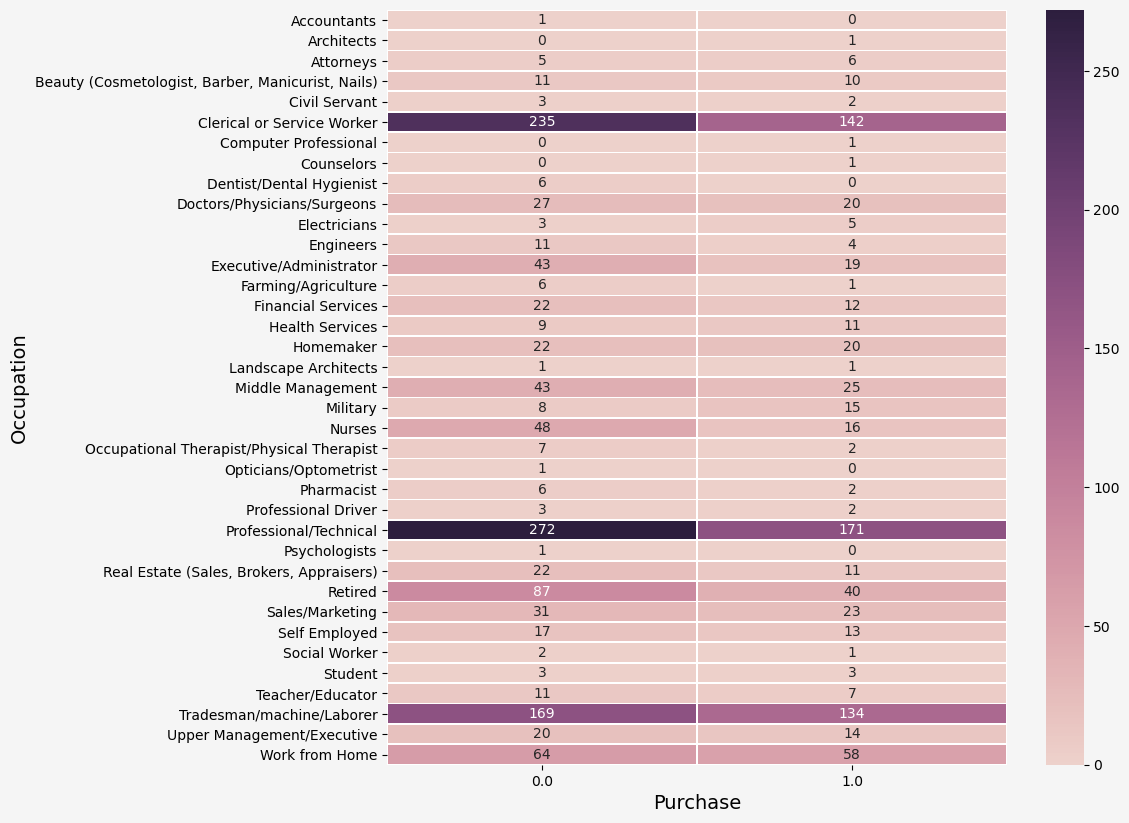

In [61]:
cross_tab = pd.crosstab(plot_da["Occupation"],plot_da["purchase"])
fig, ax = plt.subplots(1,1,figsize=(10,10),dpi=100,facecolor="whitesmoke")
cmap = sns.cubehelix_palette(as_cmap=True)
sns.heatmap(cross_tab,annot=True,fmt="d",cmap=cmap,linewidths=.5,ax=ax)
ax.set_facecolor("whitesmoke")
ax.set_xlabel("Purchase",fontsize=14)
ax.set_ylabel("Occupation",fontsize=14)
plt.show()

### Correlations between Predictor Variables

#### Occupation & Make

We inspect the relationship between occupation and make to gain insights into what kind of brands are the main option for different occupations. Therefore, we can infer the missing value of occupation based on their cars.

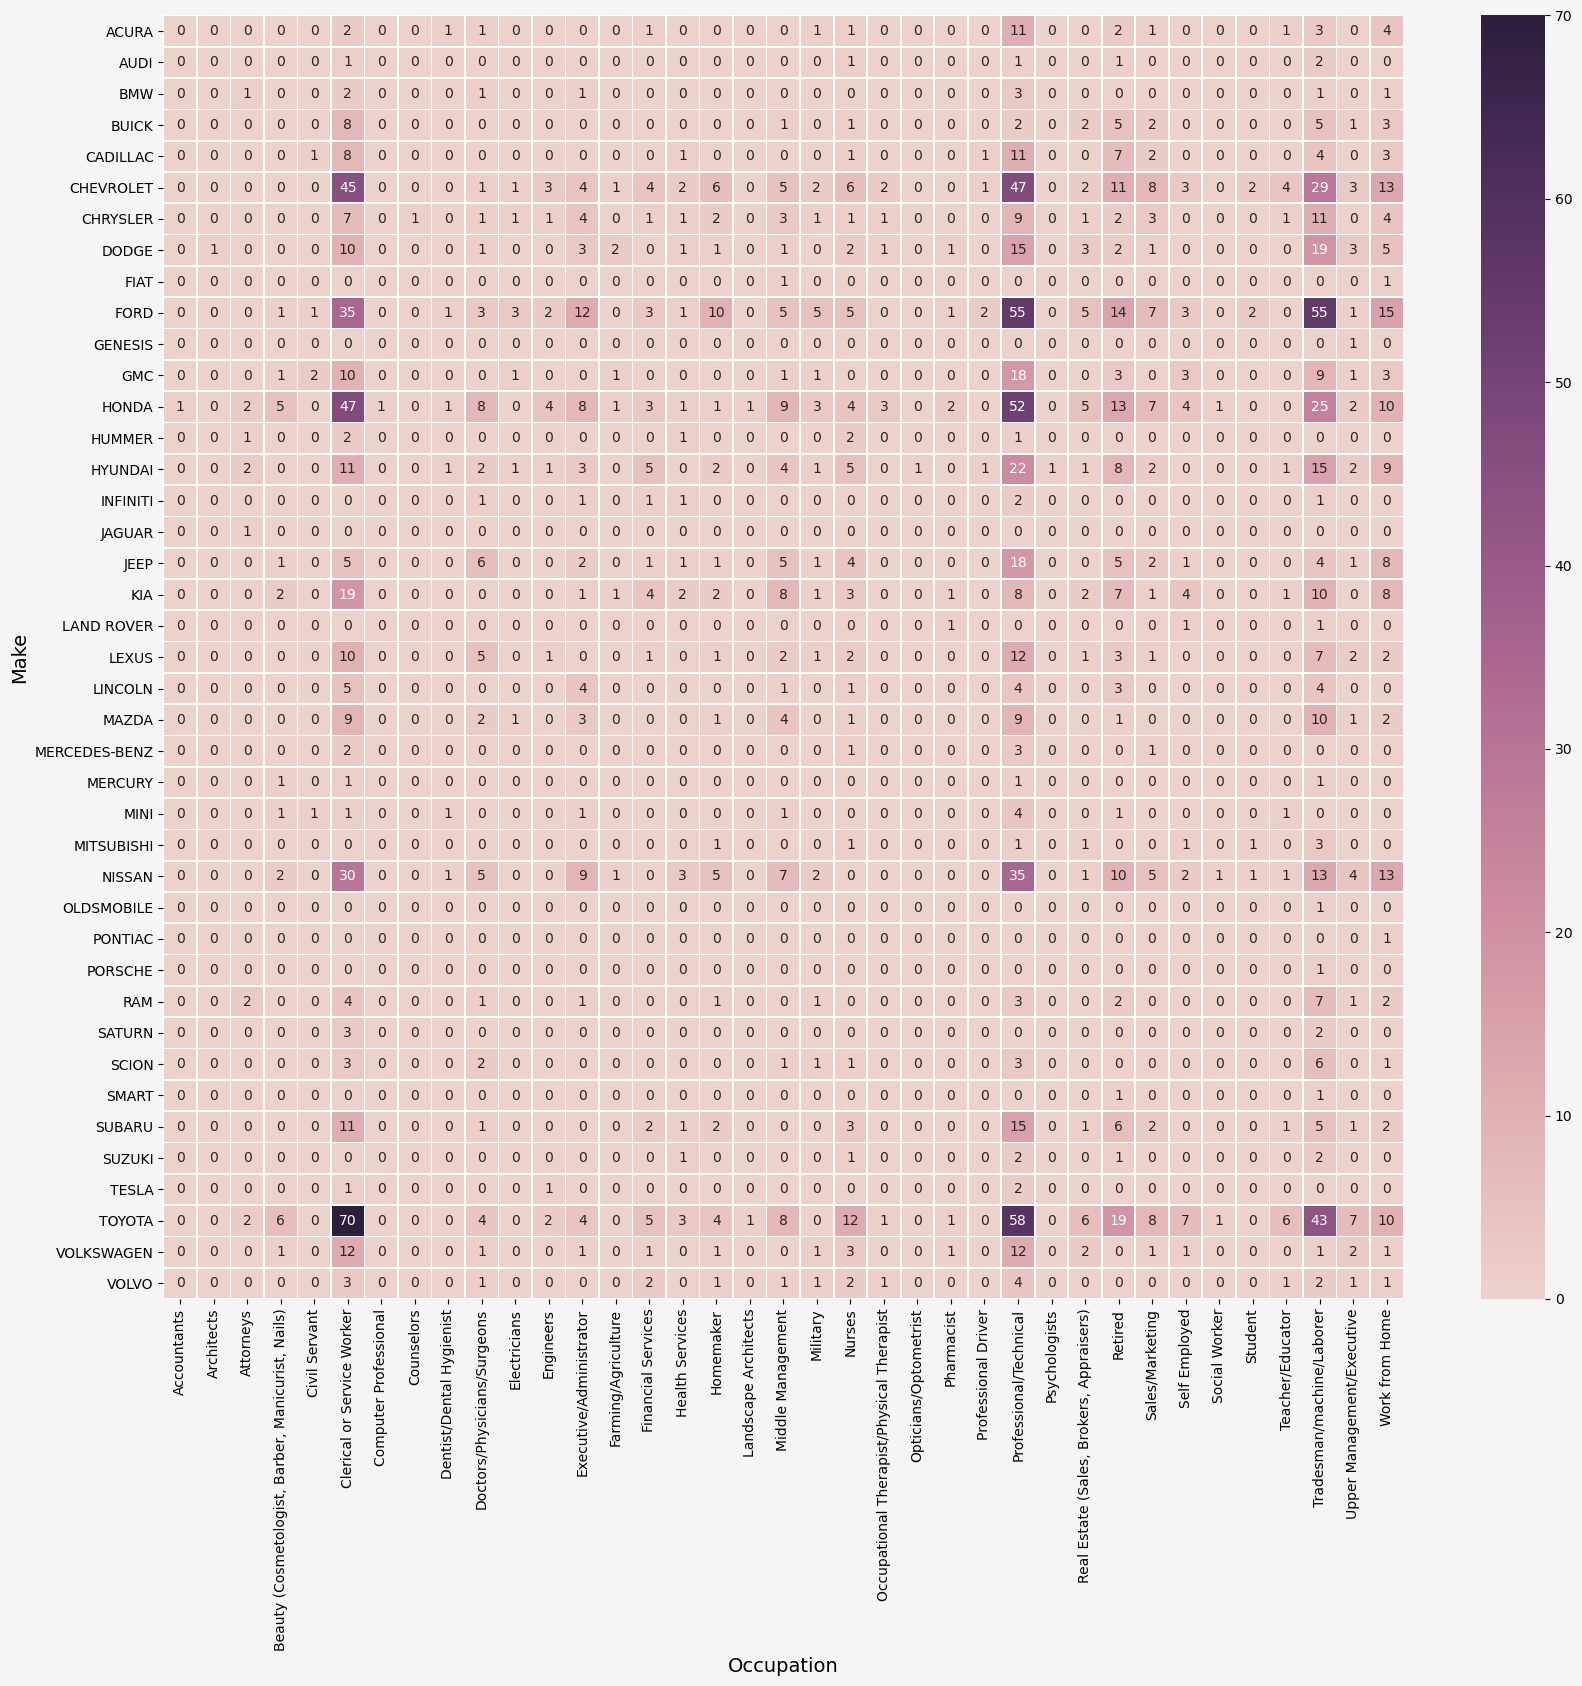

In [62]:
cross_res = pd.crosstab(balanced_da["Make"],balanced_da["Occupation"])


fig, ax = plt.subplots(1,1,figsize=(20,17),dpi=100,facecolor="whitesmoke")
cmap = sns.cubehelix_palette(as_cmap=True)
sns.heatmap(cross_res,annot=True,fmt="d",cmap=cmap,linewidths=.5,ax=ax)
ax.set_facecolor("whitesmoke")
ax.set_xlabel("Occupation",fontsize=14)
ax.set_ylabel("Make",fontsize=14)
plt.show()

$\color{crimson}{\bf{\text{Interpretation:}}}$

It is easily found that across all occupations, *Clerical or service worker*, *professional or technical*, and *tradesman/mechanical* are the three main occupations. 

- `Clerical or service worker`. For the occupation, *Toyota* is their make of choice.
- `Professional or Technical`. For professional or technical people, *Ford* and *Toyato* are their preferred brands of car.

But for basically all brands, the three occupations are always the greatest customers. In this case, we cannot just infer the missing occupation based on the car brand, because we have three options here. So we have to reply on other ways to fill missing valyes, such as machine learning algorihtms.

Extract all data that miss gender

In [63]:
per_to_num = {'One person':1,'Three persons':3,'Two persons':2,'Four persons':4,'Five persons':5,'Seven persons':7,
'Six persons':6,'Eight persons':8,'Nine or more persons':9}
plot_da["Number of persons in Householdx"] = plot_da["Number of persons in Household"].replace(per_to_num)

In [64]:
def ordinal_encoding_edu(x):
    if x=="High School":
        return 1
    elif x=="Some College":
        return 2
    elif x=="Completed College":
        return 3
    else:
        4
plot_da["Education_Levelx"] = plot_da["Education Level"].apply(lambda x:ordinal_encoding_edu(x))

In [65]:
object_cols,numerical_cols,discrete_cols,continuous_cols = get_columns(plot_da)

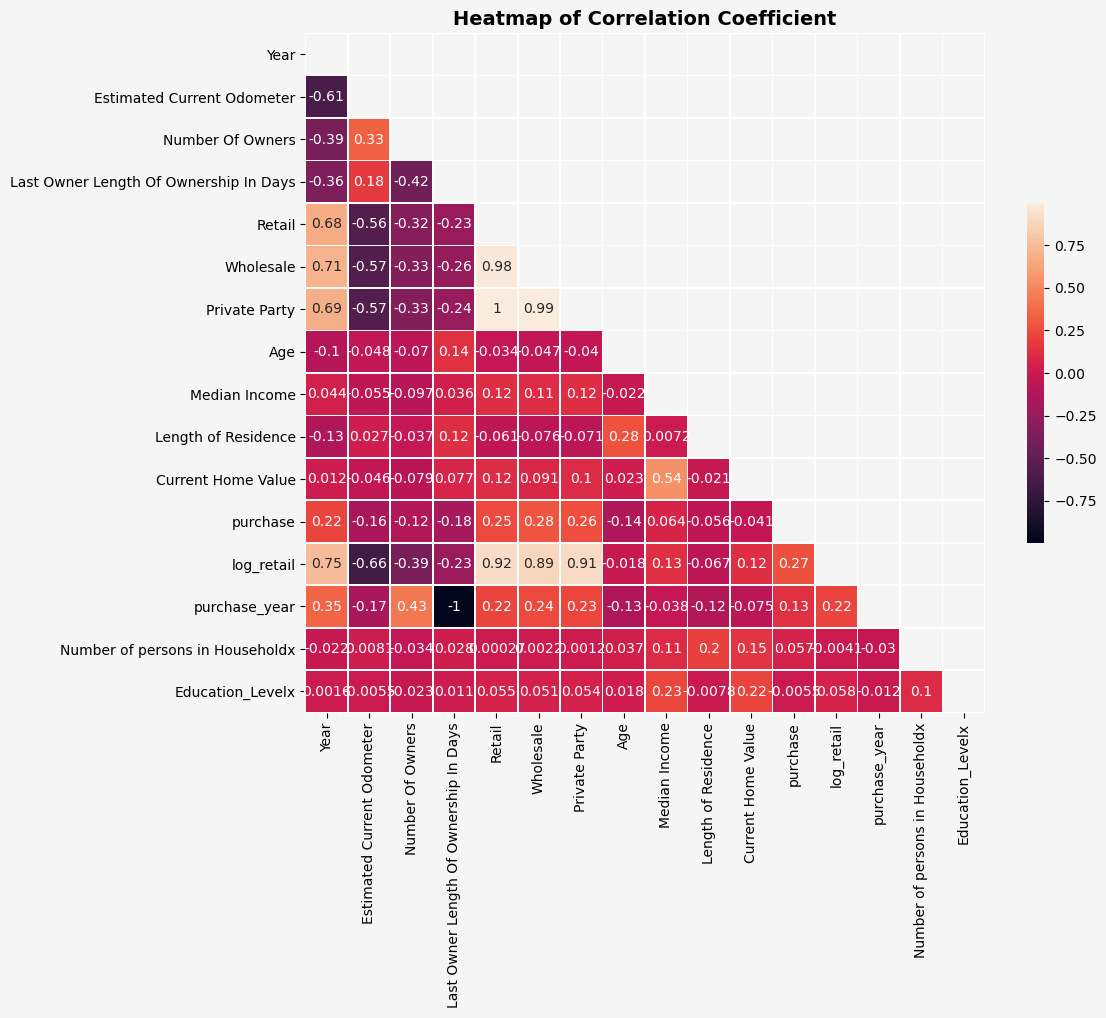

In [66]:
corr_plot(plot_da,numerical_cols)

# Data Cleaning & Feature Engineering

## Data Cleaning

Based on insights we obtained from EDA section, we first conduct a elementary clearning on the dataset.

### Drop Unnecessary Variables

**Drop variables that have strong collinearity.**

In [67]:
balanced_da = balanced_da.drop(["Private Party","Wholesale"],axis=1)

**Drop Variables with more than 70% of missing values**

- The `Occupation` does not impact the purchase decision of customers and it has too many missing values. So we decided to drop it from dataset.
- `Number of Adults in Household`, we find through EDA, has no relation with `purchase` because the purchase rate remains basically constant across different number of adults. Also, the numer of missing values is very large and so we drop it.

In [68]:
balanced_da = balanced_da.drop(["Occupation","Number of Adults in Household","Race / Ethnicity"],axis=1)

### Outliers

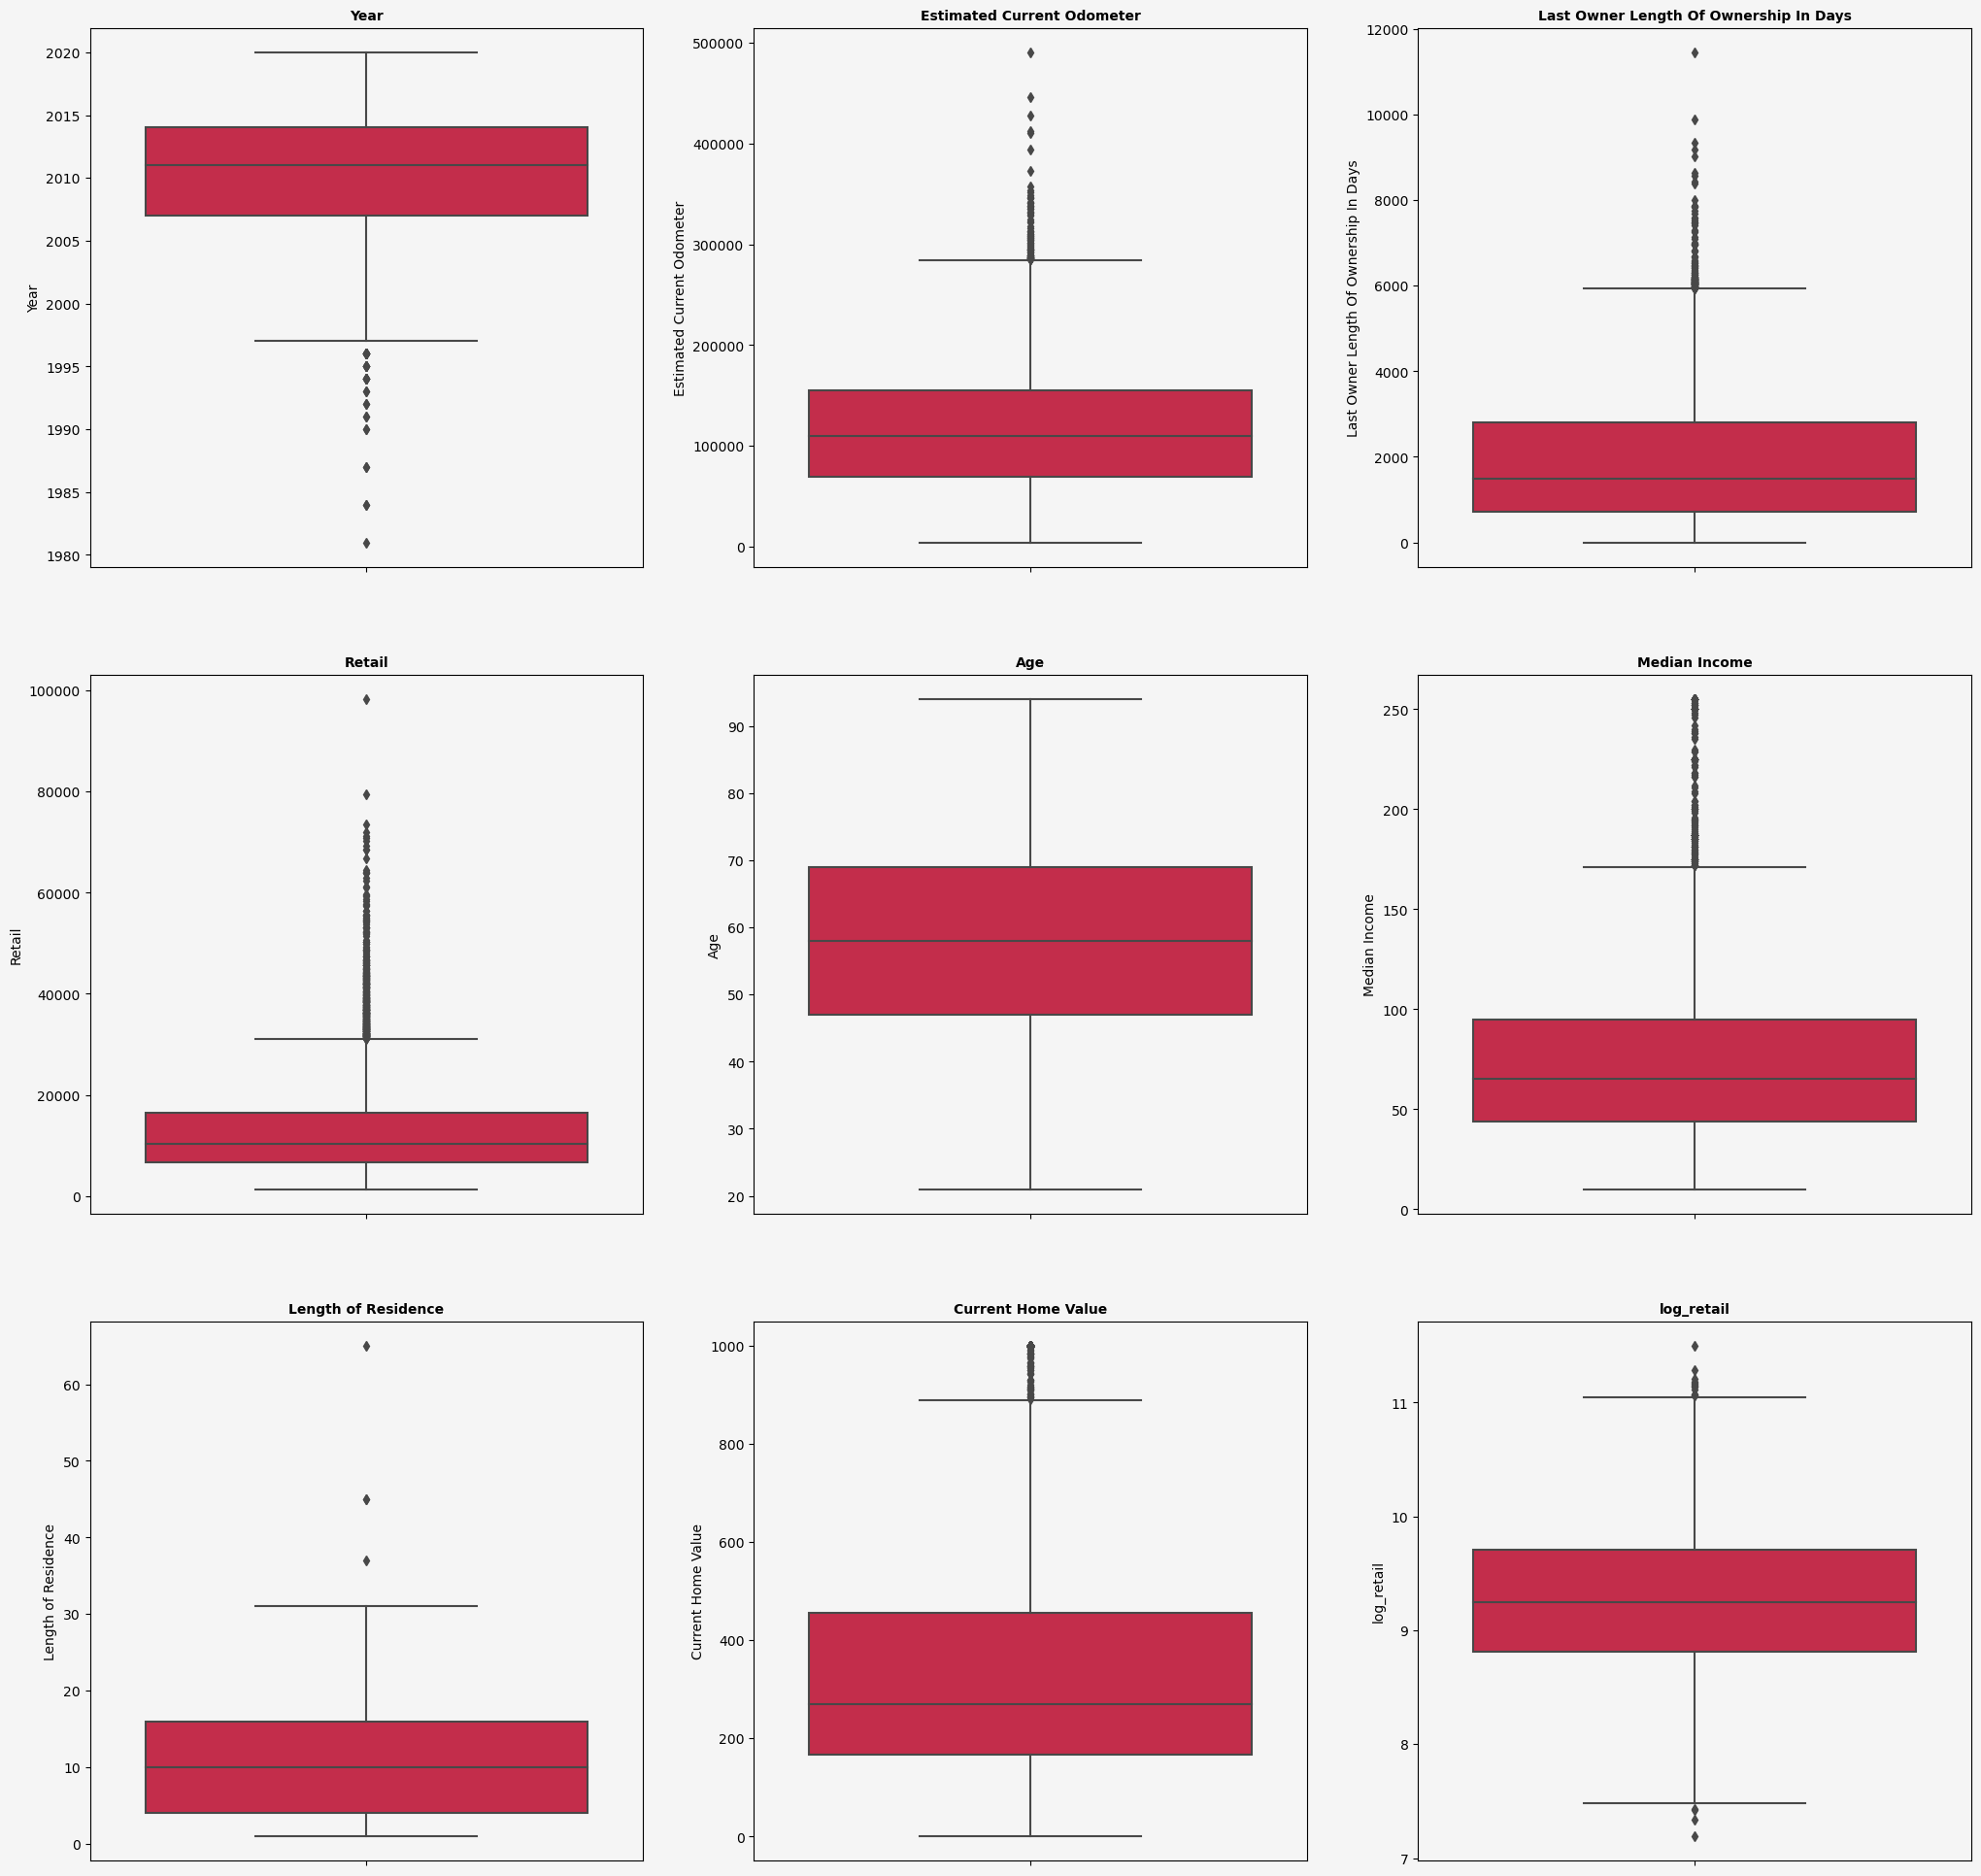

In [69]:
object_cols,numerical_cols,discrete_cols,continuous_cols = get_columns(balanced_da)
check_dist(3,3,balanced_da,continuous_cols,"crimson",isbox=True)

**Age**

We think that it is impossible for people who are aged more than 90 years old to drive and thus there is no reason to state that they will purchase tires. We delete these observations.

In [70]:
from scipy import stats
from scipy.stats import norm

def plot_resi(data,col):
    fig,ax = plt.subplots(1,1,figsize=(8,5),dpi=100)
    stats.probplot(data[col].dropna(),dist=stats.norm,plot=ax)
    ax.set_facecolor("whitesmoke")
    ax.set_title("ProbPlot against Normal Distribution",fontsize=12,weight="bold",color="crimson")
    for spine in ["top","right"]:
        ax.spines[spine].set_visible(False)
    plt.show()

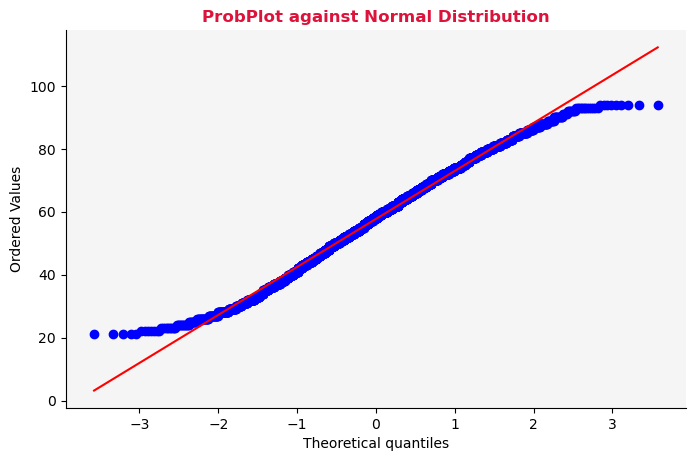

In [71]:
plot_resi(balanced_da,"Age")

**Intepretation:**

The data points on the both tails lie off the line straight line, suggesting that the `Age` variable has slight skewness.

In [72]:
# drop observations with higher than 90 years old
outlier_index = balanced_da[balanced_da.Age>90].Age.index
balanced_da_dp = balanced_da.drop(labels=outlier_index)

**Last Owner Length of Ownership in Days**

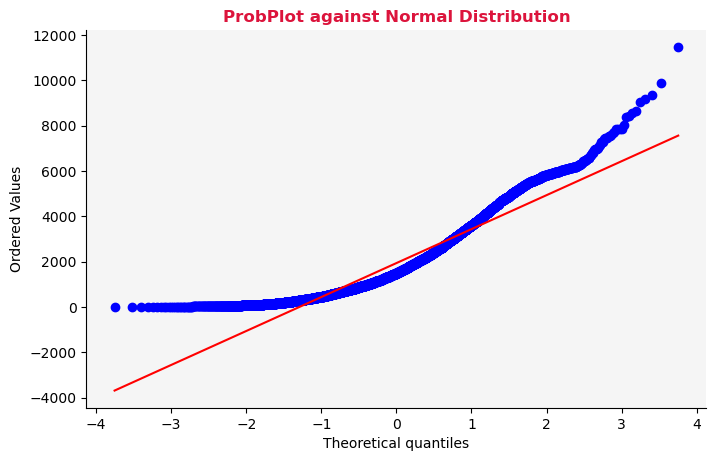

In [73]:
from scipy import stats
from scipy.stats import norm

plot_resi(balanced_da,"Last Owner Length Of Ownership In Days")

In [74]:
cm = sns.light_palette("crimson", as_cmap=True)

mark = balanced_da["Last Owner Length Of Ownership In Days"]>6000
owner_df = balanced_da[mark]
owner_df["ownership_bins"] = pd.cut(owner_df["Last Owner Length Of Ownership In Days"],10)
cross_tab = pd.crosstab(owner_df["ownership_bins"],owner_df["purchase"])
cross_tab.style.background_gradient(cmap=cm)

$\color{crimson}{\bf{\text{Interpretation:}}}$

Except for the ownership bins of (5998,6548], in which the number of tire buyers is basically the same as tire non-buyers, all other bins do not have enough sample size so that the vell values are basically 0. To prevent linear regression models from fitting large y values using very samll change in x, we decided to delete these outlying observations from the dataset.

In [75]:
# drop outlying observations about ownership days
balanced_da_dp = balanced_da_dp.drop(labels=owner_df.index)
balanced_da_dp.shape

(7800, 31)

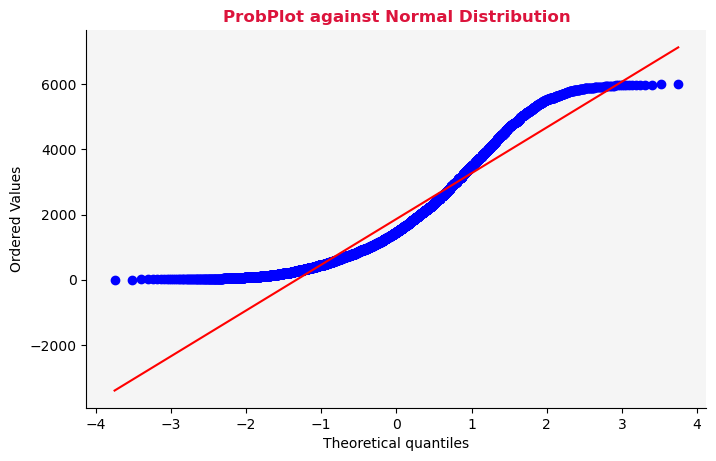

In [76]:
plot_resi(balanced_da_dp,"Last Owner Length Of Ownership In Days")

$\color{crimson}{\bf{\text{Interpretation:}}}$

After deleting outling observations from the dataset, the `probplot` shows that the data points on the high-end tail of straight line, which is the reference line of normald distribution, follow more closely the line than it does when there are outlying observations.

**Length of Residence**

There is one very remarkable observation in the boxplot, which has more than 60 days of residence.

In [77]:
mark = balanced_da["Length of Residence"]>60
outlier_resi = balanced_da[mark]["Length of Residence"]
outlier_resi

678    65.0
Name: Length of Residence, dtype: float64

There is only one observation with higher than 65 days of residence. We delete it from dataset.

In [78]:
balanced_da_dp = balanced_da_dp.drop(labels=678)

## Feature Engineering


### Ordinal Ecoding

We have found that some variables have logical ordering, so we need to encode them from logical categories to natural numbers.

In [79]:
map1 = {"High School":1,"Some College":2,"Completed College":3,"Graduated School":4}
map2 = {'One person':1,'Three persons':3,'Two persons':2,'Four persons':4,'Five persons':5,'Seven persons':7,
'Six persons':6,'Eight persons':8,'Nine or more persons':9}


# transformation
balanced_da_dp["Education Level"] = balanced_da_dp["Education Level"].replace(map1)
balanced_da_dp["Number of persons in Household"] = balanced_da_dp["Number of persons in Household"].replace(map2)

In [80]:
balanced_da_dp = balanced_da_dp.drop(["Net Worth","Wealth Rating","Current Home Value","log_retail","Household Income"],axis=1)

### Train Test Split


In [85]:
from sklearn.model_selection import train_test_split

balanced_da_dp = balanced_da_dp.dropna(subset=["Year","Make","Make"])

# split data into features and label
X = balanced_da_dp.drop("purchase",axis=1)
y = balanced_da_dp["purchase"]


# then split data into train set and test set
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=42)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

X_train_full = X_train.copy()
X_test_full = X_test.copy()

(5848, 25) (1950, 25) (5848,) (1950,)


In [86]:
# split the columns of x train set into different categories
object_cols,numerical_cols,discrete_cols,continuous_cols = get_columns(X_train_full)

In [87]:
# get missing info
missing_df = get_missing_pct(X_train_full)
cm = sns.light_palette("crimson", as_cmap=True)
missing_df.sort_values(by="missing_pct",ascending=False).style.background_gradient(cm)

### Pipeline Transformation

*Step 1: Define preprocessing steps*
- Fill missing values
    - Continuous variables: using mean to fill with missing values
    - Discrete Variables: using k-nearest algorithm to fill with missing values
    - Categorical variables: using most frequent category to fill with missing values
    
*Step 2: Creating variables to indicate the absence of missing values*

*Step 3: Perform one hot encoding on categorical variables with less than 15 categories*

Since `make`, `model`, and `Race/Ethnicity` has more than 15 categories, so we take other measures to handle them.

In [88]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer, MissingIndicator
from sklearn.pipeline import FeatureUnion 

# preprocessing for numerical data
continuous_transformer = Pipeline([
    ("mean imputer",SimpleImputer(strategy="mean"))
])

discrete_transformer = Pipeline([
    ("k nearest imputer",KNNImputer())
])

# add variables to indicate presence of missing categories
do_nothing_imputer = ColumnTransformer([("Imputer frequent", SimpleImputer(missing_values=np.nan, strategy="most_frequent"), [])], remainder='passthrough')
feature_expansion = FeatureUnion([
        ("do nothing",do_nothing_imputer),
        ("add features for Missing",MissingIndicator(missing_values=np.nan,features="missing-only"))
])


# define categorical transfomer
categorical_transformer = Pipeline([
    ("missing indicator",feature_expansion),
    ("k nearest imputer",SimpleImputer(strategy="most_frequent"))
])

# define target cols we need to transform
object_cols_x = pd.Series(object_cols).drop([0,1]).tolist()

# build the column transformer
preprocessor = ColumnTransformer(
  transformers = [
    ("continuous_num",continuous_transformer,continuous_cols),
      ("discrete_num",discrete_transformer,discrete_cols),
      ("cat",categorical_transformer,object_cols_x)
  ]
)

In [89]:
missing_cols = list(map(lambda x:x+"_missing",object_cols_x))
cols = continuous_cols + discrete_cols+ object_cols_x+missing_cols
X_train_part = pd.DataFrame(preprocessor.fit_transform(X_train_full),columns=cols)
X_train_dum = pd.get_dummies(X_train_part[object_cols_x]).reset_index().drop("index",axis=1)

# perform the same transformation on X test
X_test_part = pd.DataFrame(preprocessor.fit_transform(X_test_full),columns=cols)
X_test_dum = pd.get_dummies(X_test_part[object_cols_x]).reset_index().drop("index",axis=1)

**Target Encoding**

There are two categorical variables, `make` and `model`, that we do not perform transformation. Since the number their categories are too large, so we cannot just use onehot encoder to transform them. 

In [90]:
for col in object_cols[:2]:
    print(col,X_train_full[col].nunique())

Make 45
Model 1250


Model has as many as 1348 categories, target encoding will present some problems if some categories are rare categories. To mitigate the risk, we find out the rare categories and group them into back-off bin.

In [173]:
from category_encoders import MEstimateEncoder

# Create the encoder instance. Choose m to control noise.
encoder = MEstimateEncoder(cols=["Make","Model"], m=5.0)
encoded_df = encoder.fit_transform(X_train_full,y_train)[["Make","Model"]].reset_index().drop("index",axis=1)
encoded_df_ = encoded_df.rename({"Make":"encoded_make","Model":"encoded_model"})
original_mm_df = X_train_full[["Model","Make"]].reset_index().drop("index",axis=1)
tar_encoding_res = pd.concat([encoded_df_,original_mm_df],axis=1)
tar_encoding_res.to_csv("target_encoding.csv")

In [172]:
model_df = X_train_full.Model.value_counts().reset_index()
threshold = 4

# filter out records that has less than 2 frequency of model
back_off_model = model_df.loc[model_df.Model<threshold,:]
back_off_cats = back_off_model["index"].tolist()

def back_off_bin(x):
    """put rare categories into back off categories"""
    if x in back_off_cats:
        return 'backoff_cat'
    else:
        return x


    
X_train_full["Model"] = X_train_full["Model"].apply(lambda x: back_off_bin(x))
X_test_full["Model"] = X_test_full["Model"].apply(lambda x: back_off_bin(x))

In [174]:
from category_encoders import MEstimateEncoder

# Create the encoder instance. Choose m to control noise.
encoder = MEstimateEncoder(cols=["Make","Model"], m=5.0)


x_train_cat = encoder.fit_transform(X_train_full,y_train)[["Make","Model"]].reset_index().drop("index",axis=1)
x_test_cat = encoder.fit_transform(X_test_full, y_test)[["Make","Model"]].reset_index().drop("index",axis=1)

In [91]:
# concatenate the transformed dataset together
X_train_part = X_train_part.drop(object_cols_x,axis=1)
X_test_part = X_test_part.drop(object_cols_x,axis=1)
X_train_full = pd.concat([X_train_part,X_train_dum],axis=1)
X_test_full = pd.concat([X_test_part,X_test_dum],axis=1)

In [92]:
# convert the boolean col into number col
for col in object_cols_x:
    col = col + "_missing"
    X_train_full[col] = X_train_full[col].astype("int")
    X_test_full[col] = X_test_full[col].astype("int")

The transformation makes the thousands of categories of `Model` become values ranging from 0 to 1. We make decision about how to deal with the variable when discovering useful insights in *covariation section*.

### Feature Scaling

In exploratory data analysis, we have found that several variables are severely skewed. We decided to conduct boxcox transformation on them to make the more normally distributed so that linear models can perform better.

In [93]:
from scipy import stats

# perform log transformation on target variables

target_cols = ["Estimated Current Odometer","Last Owner Length Of Ownership In Days","Retail"]
rc_bc,params = stats.boxcox(X_train_full["Estimated Current Odometer"].astype("int"))
X_train_full["Estimated Current Odometer"] = rc_bc

rc_bc,params = stats.boxcox(X_train_full["Last Owner Length Of Ownership In Days"].astype("int"))
X_train_full["Last Owner Length Of Ownership In Days"] = rc_bc

rc_bc,params = stats.boxcox(X_train_full["Retail"].astype("int"))
X_train_full["Retail"] = rc_bc

In [94]:
from scipy import stats

# perform boxcox transformation on target variables
rc_bc,params = stats.boxcox(X_test_full["Estimated Current Odometer"].astype("int"))
X_test_full["Estimated Current Odometer"] = rc_bc

rc_bc,params = stats.boxcox(X_test_full["Last Owner Length Of Ownership In Days"].astype("int"))
X_test_full["Last Owner Length Of Ownership In Days"] = rc_bc

rc_bc,params = stats.boxcox(X_test_full["Retail"].astype("int"))
X_test_full["Retail"] = rc_bc

Examine the distribution of these varibles.

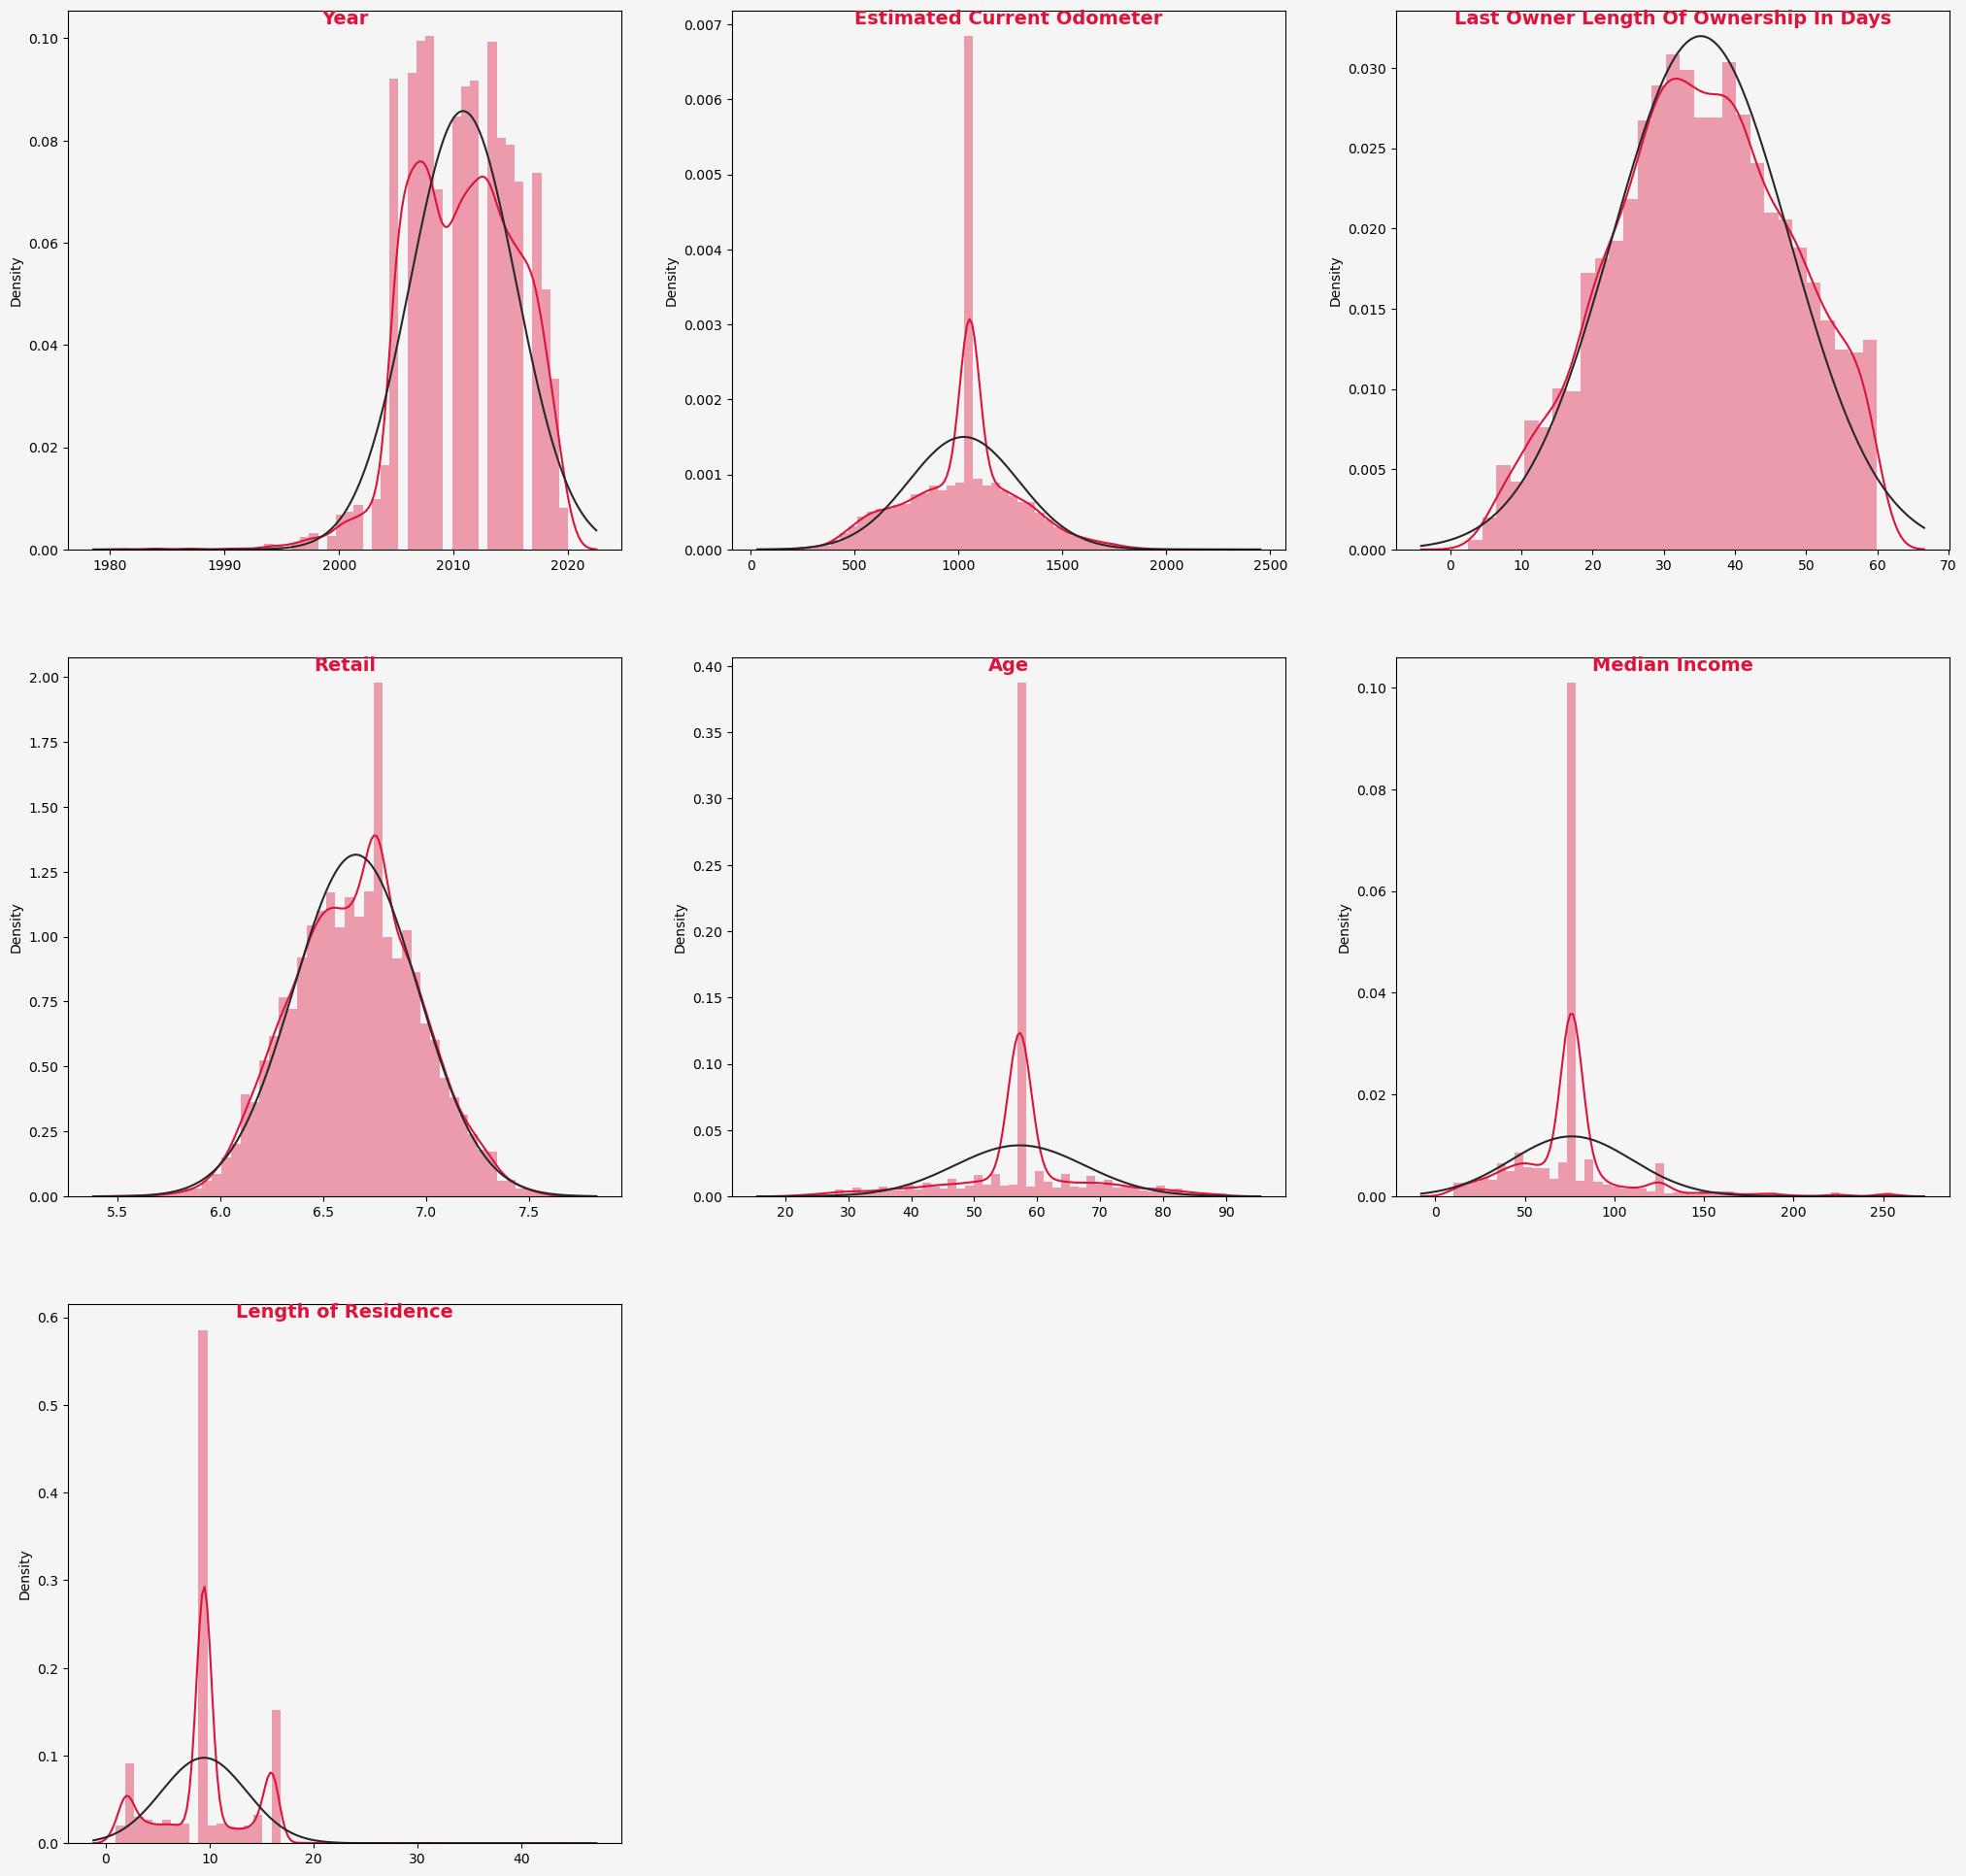

In [95]:
check_dist(3,3,X_train_full,continuous_cols,"crimson",False)

After boxcox transformation, the distribution of these variables are more normal than before. Now to ensure that some algorithms relying on eculidian distance to perform well, we perform scaling on variables.

In [96]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
scaled_xtrain = scaler.fit_transform(X_train_full)
scaled_xtest = scaler.fit_transform(X_test_full)
X_train_full = pd.DataFrame(scaled_xtrain,columns=X_train_full.columns)
X_test_full = pd.DataFrame(scaled_xtest,columns=X_test_full.columns)

# Model Selection

In [97]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_predict,cross_val_score

seed = 42

models = [
    ('kNN',KNeighborsClassifier()),
    ('SVC',SVC(random_state=seed, probability=True)),
    ('DT',DecisionTreeClassifier(random_state=seed)),
    ('RF',RandomForestClassifier(random_state=seed)),
    ('GB',GradientBoostingClassifier(random_state=seed)),
    ('GauNB',GaussianNB()),
    ('LR',LogisticRegression(solver='liblinear',max_iter=10000))
]

In [98]:
def fit_model(X,y,model,cv_fold,metric,plot=False):

    # Fit model on trains set
    model = model.fit(X,y)

    # Predict training set
    train_pred = model.predict(X)
    train_predprob = model.predict_proba(X)[:,1]

    # Cross-Validation
    cv_score = cross_val_score(model,X,y,cv=cv_fold,scoring=metric)
    cv_ypred = cross_val_predict(model,X,y,cv=cv_fold)

    # plot confusion matrix and roc_auc curve
    if plot:

        # print accuracy
        train_res = "Train Accuracy: {:.4f} | ".format(metrics.accuracy_score(y,train_pred))
        train_res += "Train AUC Score : {:.4f}\n".format(metrics.roc_auc_score(y,train_pred))
        train_res += "CV Score: Mean - {0}|std-{1}|Min-{2}|Max-{3}".\
        format(np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score))


        # make visualization for prediction
        from sklearn.metrics import confusion_matrix
        fig,axes = plt.subplots(1,2,figsize=(16,5),dpi=100)
        fig.suptitle("{} Model Report".format(model))
        fig.text(0.5,0,train_res,ha="center",va="center")
        
        # confusion maxtrix
        confusion=metrics.confusion_matrix(y_true=y,y_pred=cv_ypred)
        sns.heatmap(confusion, annot=True, cmap='Blues', fmt='d',ax=axes[0])
        axes[0].set_xlabel("Predicted_Purchase")
        axes[0].set_ylabel("Actual_Purchase") 

        # roc_auc curve
        from sklearn.metrics import roc_curve
        fpr, tpr, thresholds = roc_curve(y, cv_ypred)
        axes[1].plot(fpr, tpr, label='ROC curve (area = %0.3f)' % np.mean(cv_score))
        axes[1].plot([0, 1], [0, 1], 'k--')  # random predictions curve
        axes[1].set_xlim([0.0, 1.0])
        axes[1].set_ylim([0.0, 1.0])
        axes[1].set_xlabel('False Positive Rate or (1 - Specifity)')
        axes[1].set_ylabel('True Positive Rate or (Sensitivity)')
        axes[1].set_title('Receiver Operating Characteristic')
        axes[1].legend(loc="lower right")
        
        print(train_res)
    
    return model,cv_score,train_predprob

In [99]:
# iterate all selected models
results = []
names = []
stats = []

for name,model in models:
    res = fit_model(X_train_full,y_train,model,10,"roc_auc")
    names.append(name)
    results.append(res)

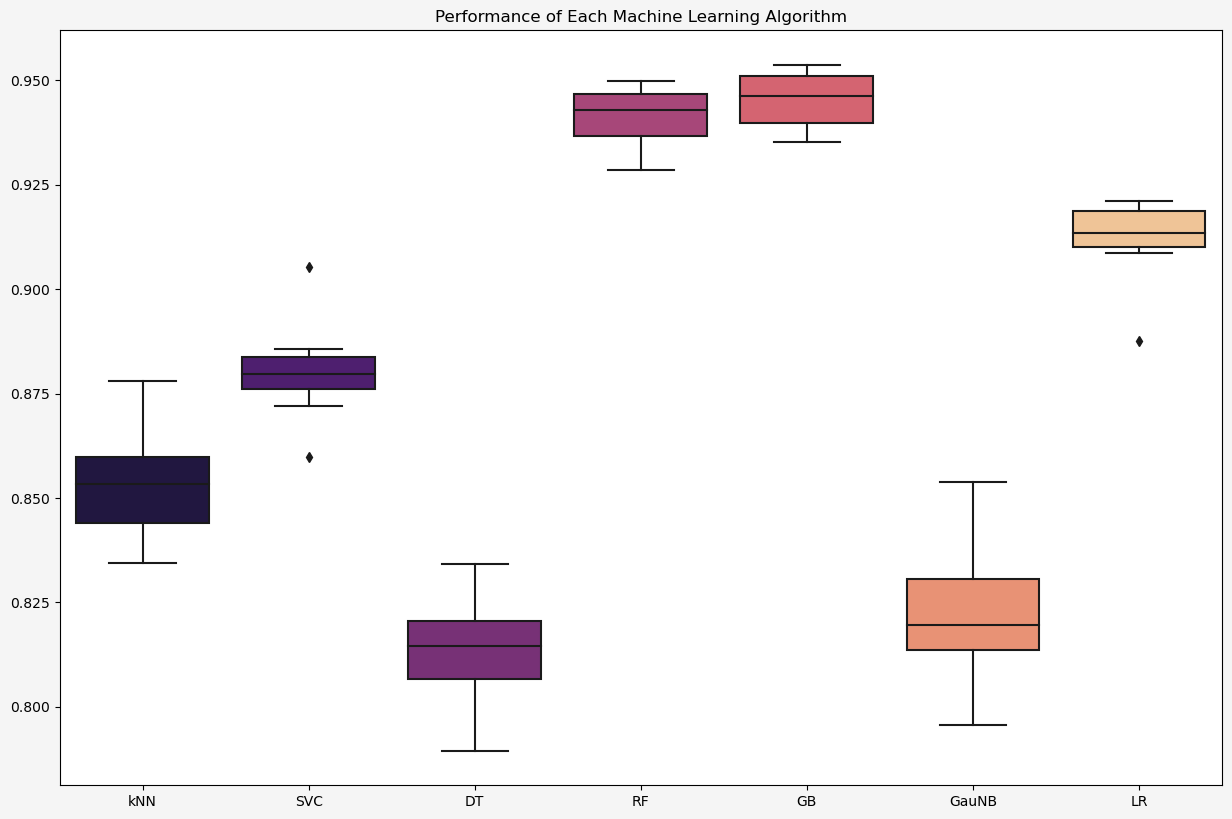

In [101]:
scores = []
for result in results:
    scores.append(result[1])
    
# visualize the scores of each model
fig,ax = plt.subplots(1,1,figsize=(15,10),dpi=100,facecolor="whitesmoke")
sns.boxplot(data=scores,ax=ax,palette="magma")
ax.set_xticklabels(names)
ax.set_title("Performance of Each Machine Learning Algorithm")
plt.show()

**Conclusion:**

- Gradient boosting performs best, with highest auc score and small variance. We decided to choose gradient boosting for further grid search.
- Logistic regression will be selected to compare against GB.

Train Accuracy: 0.8311 | Train AUC Score : 0.8309
CV Score: Mean - 0.912249158486096|std-0.009197815832936808|Min-0.8875824021693394|Max-0.9211861237084483


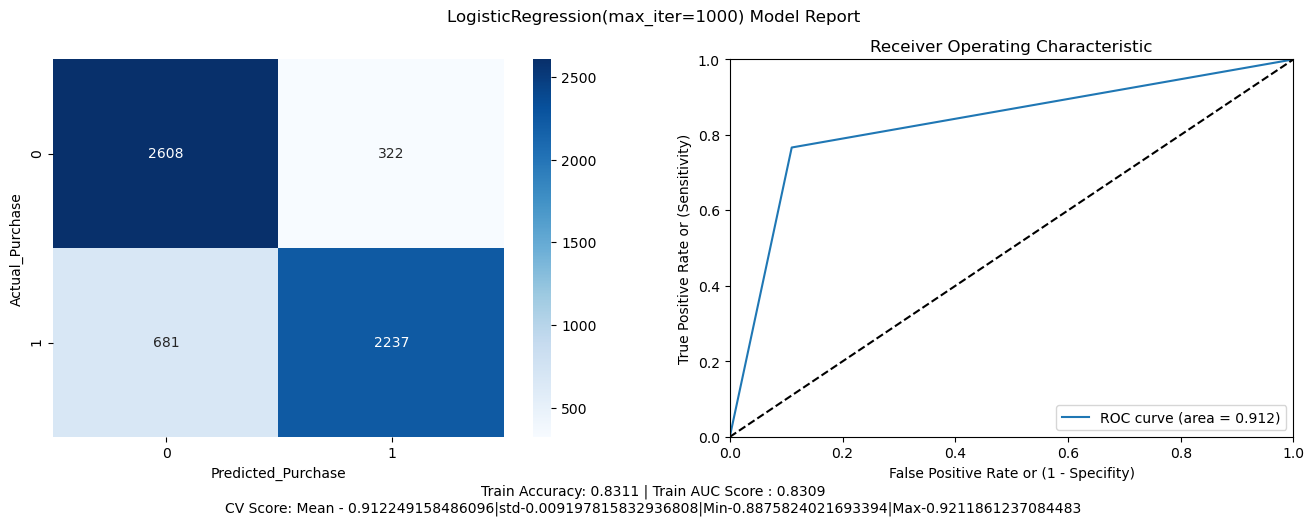

In [114]:
lg_model,cv_score,probs = fit_model(X_train_full,y_train,LogisticRegression(max_iter=1000),10,"roc_auc",plot=True)

The cross validation gives us 0.972 auc score. Now let's exmine the performance of GB.

Train Accuracy: 0.8788 | Train AUC Score : 0.8786
CV Score: Mean - 0.9450487464330752|std-0.006560274610031401|Min-0.935194492496143|Max-0.9537431242156622


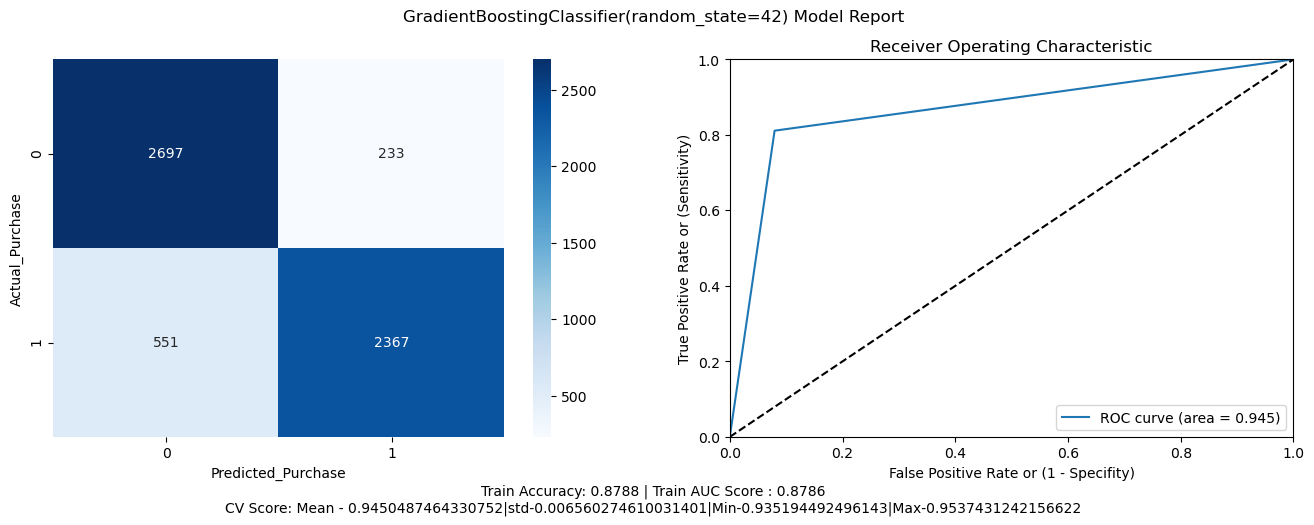

In [115]:
lg_model,cv_score,probs = fit_model(X_train_full,y_train,GradientBoostingClassifier(random_state=42),10,"roc_auc",plot=True)

The acu score for gradient boosting is 0.8786, which is very similar to that of logistic regression.

## Grid Search

So far, it seems that the performance of models is excellent, and to make the model perform more stable, we can use grid search to find the best combination of parameters.

In [116]:
from sklearn.model_selection import GridSearchCV
from sklearn.exceptions import FitFailedWarning

warnings.simplefilter(action='ignore', category=FitFailedWarning)

grid_test1 = {
    "solver":["liblinear","lbfgs","saga"],
    "C":[0.0001,0.001,0.01,0.1],
    "penalty":["l1","l2","elasticnet"]
}

lg_search1 = GridSearchCV(LogisticRegression(random_state=42,max_iter=10000),grid_test1,cv=10,verbose=0,scoring="roc_auc")
lg_search1.fit(X_train_full,y_train)

print(lg_search1.best_score_,lg_search1.best_params_)

0.910087157399691 {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


/Users/ray/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.5               nan 0.5        0.71614229 0.71635751 0.71635165
        nan        nan        nan 0.54507743        nan 0.54507743
 0.80852629 0.80779774 0.80781179        nan        nan        nan
 0.8984942         nan 0.89444861 0.87993879 0.88002531 0.87992589
        nan        nan        nan 0.90962007        nan 0.90938028
 0.91008716 0.91007432 0.90994223        nan        nan        nan]
  warnings.warn(


In [117]:
from sklearn.model_selection import GridSearchCV
from sklearn.exceptions import FitFailedWarning

warnings.simplefilter(action='ignore', category=FitFailedWarning)

grid_test2 = {
    "solver":["liblinear"],
    "C":[0.1,0.2,0.3,0.5,1,10],
    "penalty":["l2"]
}

lg_search2 = GridSearchCV(LogisticRegression(random_state=42,max_iter=10000),grid_test2,cv=10,verbose=0,scoring="roc_auc")
lg_search2.fit(X_train_full,y_train)

print(lg_search2.best_score_,lg_search2.best_params_)

0.9122433063274487 {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}


We decided to use the parameters above to train model.

Train Accuracy: 0.8311 | Train AUC Score : 0.8309
CV Score: Mean - 0.9122433063274487|std-0.009194685192344893|Min-0.887547337416429|Max-0.921162747206508


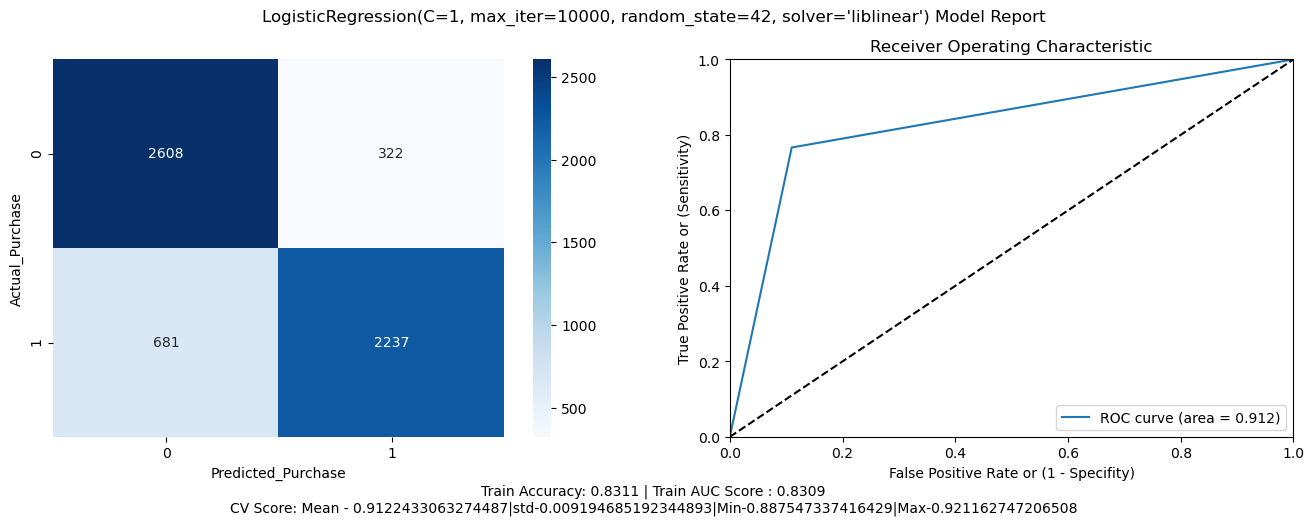

In [118]:
model = LogisticRegression(max_iter=10000,C=1,penalty="l2",solver="liblinear",random_state=42)

lg_model,cv_score,probs = fit_model(X_train_full,y_train,model,10,"roc_auc",plot=True)

In [119]:
def cross_validation_eval(model,model_name,x,y,IsTrain=True):
    pred_lg =cross_val_score(model,x,y,cv=10,scoring="roc_auc")
    
    if IsTrain:
        print("Train Set Accuracy: ")
        print("----------------------------")
        print("{0}: {1}".format(model_name,round(pred_lg.mean(),3)))
    else:
        print("Test Set Accuracy: ")
        print("----------------------------")
        print("{0}: {1}".format(model_name,round(pred_lg.mean(),3)))

In [120]:
cross_validation_eval(lg_model,"Logistic Regression",X_train_full,y_train,IsTrain=False)

Test Set Accuracy: 
----------------------------
Logistic Regression: 0.912


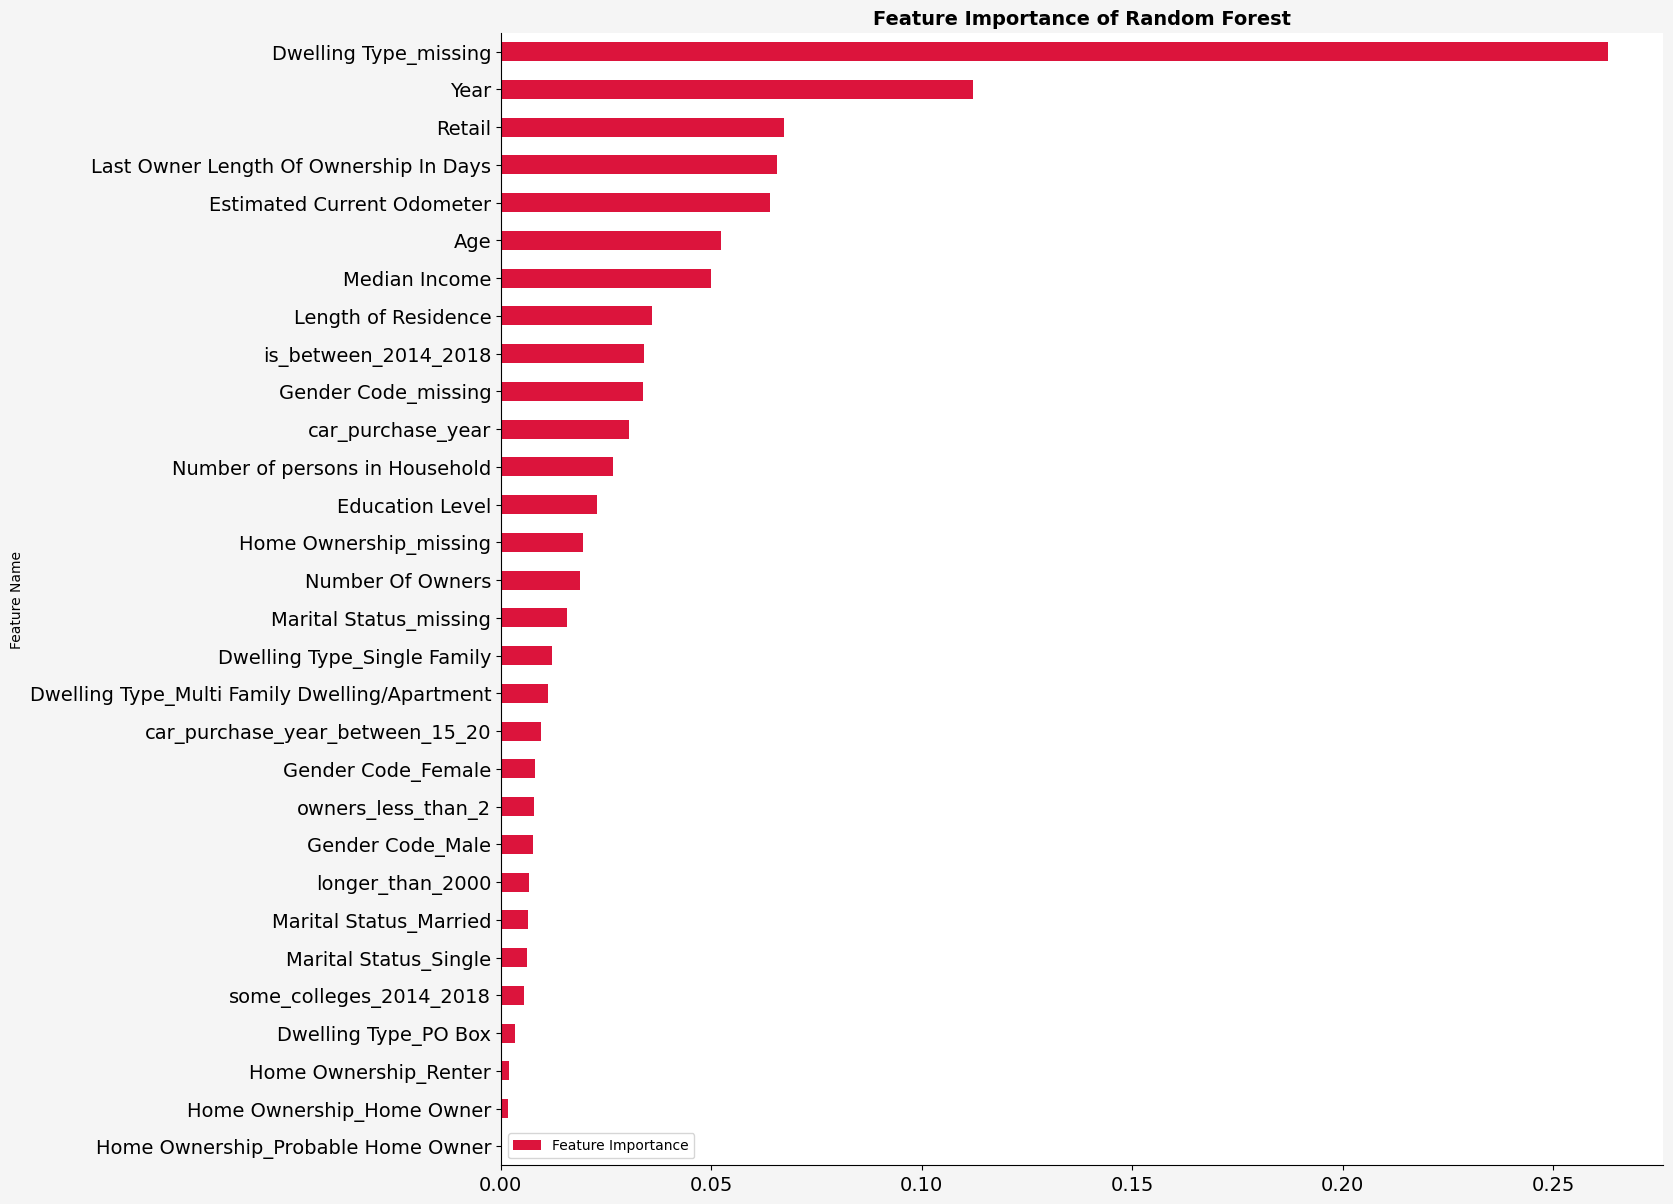

In [121]:
rf_clf = RandomForestClassifier().fit(X_train_full,y_train)
temp = pd.DataFrame({"Feature Name":X_train_full.columns,
              "Feature Importance":rf_clf.feature_importances_}).sort_values(by="Feature Importance")

fig,ax = plt.subplots(1,1,figsize=(15,15),dpi=100,facecolor="whitesmoke")
temp.plot(x="Feature Name",y="Feature Importance",kind="barh",color="crimson",ax=ax)
ax.set_title("Feature Importance of Random Forest",weight="bold",fontsize=14)
for i in ["right","top"]:
    ax.spines[i].set_visible(False)
ax.tick_params(labelsize=14)
plt.legend(loc="best")
plt.show()

Target encoding has high risk of overfitting, and the result shows that Model, which is target encoded, has the highest importance.

# Model Evaluation

In [124]:
holdout_data["Household Income"] = holdout_data["Household Income"].apply(lambda x:str(x).strip())

# feature expansion
holdout_data["car_purchase_year"] = pd.to_datetime(holdout_data["Vehicle Purchase Date"]).dt.year
holdout_data["car_purchase_year_between_15_20"] = ((holdout_data["car_purchase_year"]>=2015) & (holdout_data["car_purchase_year"]<=2020)).astype("int64")
holdout_data["is_between_2014_2018"] =  ((holdout_data.car_purchase_year>=2014) & (holdout_data.car_purchase_year<=2018)).astype("int64")
holdout_data["some_colleges_2014_2018"] =  ((holdout_data.car_purchase_year>=2014) & (holdout_data.car_purchase_year<=2019) & (holdout_data["Education Level"]=="Some College"))\
.astype("int64")
holdout_data["longer_than_2000"] = (holdout_data["Last Owner Length Of Ownership In Days"]>2000).astype("int64")
holdout_data["odo_smaller_than_60000"] = holdout_data["Estimated Current Odometer"]<=60000
holdout_data["owners_less_than_2"] = (holdout_data["Number Of Owners"]<=2).astype("int64")


# oridnal encoding
map1 = {"High School":1,"Some College":2,"Completed College":3,"Graduated School":4}
map2 = {'One person':1,'Three persons':3,'Two persons':2,'Four persons':4,'Five persons':5,'Seven persons':7,
'Six persons':6,'Eight persons':8,'Nine or more persons':9}

holdout_data["Education Level"] = holdout_data["Education Level"].replace(map1)
holdout_data["Number of persons in Household"] = holdout_data["Number of persons in Household"].replace(map2)


# drop variables
holdout_data_x = holdout_data.drop(["Private Party","Wholesale","Occupation","Number of Adults in Household","Race / Ethnicity",
                  "Net Worth","Wealth Rating","Current Home Value","log_retail","Household Income","Vehicle Purchase Date","Working woman in household",
                                   "Young Adult in household","Presence of Children"],axis=1)

Split columns

In [125]:
X = holdout_data_x.drop("purchase",axis=1)
y = holdout_data_x["purchase"]

In [126]:
# split the columns of x train set into different categories
object_cols,numerical_cols,discrete_cols,continuous_cols = get_columns(X)

In [127]:
# preprocessing for numerical data
continuous_transformer = Pipeline([
    ("mean imputer",SimpleImputer(strategy="mean"))
])

discrete_transformer = Pipeline([
    ("k nearest imputer",KNNImputer())
])

# add variables to indicate presence of missing categories
do_nothing_imputer = ColumnTransformer([("Imputer frequent", SimpleImputer(missing_values=np.nan, strategy="most_frequent"), [])], remainder='passthrough')
feature_expansion = FeatureUnion([
        ("do nothing",do_nothing_imputer),
        ("add features for Missing",MissingIndicator(missing_values=np.nan,features="missing-only"))
])


# define categorical transfomer
categorical_transformer = Pipeline([
    ("missing indicator",feature_expansion),
    ("k nearest imputer",SimpleImputer(strategy="most_frequent"))
])

# define target cols we need to transform
object_cols_x = pd.Series(object_cols).drop([0,1]).tolist()

# build the column transformer
preprocessor = ColumnTransformer(
  transformers = [
    ("continuous_num",continuous_transformer,continuous_cols),
      ("discrete_num",discrete_transformer,discrete_cols),
      ("cat",categorical_transformer,object_cols_x)
  ]
)

**Pipeline Transformation**

In [128]:
missing_cols = list(map(lambda x:x+"_missing",object_cols_x))
cols = continuous_cols + discrete_cols+ object_cols_x+missing_cols
holdout_part =  pd.DataFrame(preprocessor.fit_transform(X),columns=cols)
holdout_dum = pd.get_dummies(X[object_cols_x]).reset_index().drop("index",axis=1)

In [129]:
# concatenate the transformed dataset together
holdout_part = holdout_part.drop(object_cols_x,axis=1)
holdout_X = pd.concat([holdout_part,holdout_dum],axis=1)

**Feature Scaling**

In [130]:
from scipy import stats

# perform log transformation on target variables
rc_bc,params = stats.boxcox(holdout_X["Estimated Current Odometer"].astype("int"))
holdout_X["Estimated Current Odometer"] = rc_bc

rc_bc,params = stats.boxcox(holdout_X["Last Owner Length Of Ownership In Days"].astype("int"))
holdout_X["Last Owner Length Of Ownership In Days"] = rc_bc

rc_bc,params = stats.boxcox(holdout_X["Retail"].astype("int"))
holdout_X["Retail"] = rc_bc


scaler = RobustScaler()
scaled_xtrain = scaler.fit_transform(holdout_X)
holdout_X = pd.DataFrame(scaled_xtrain,columns=holdout_X.columns)

In [131]:
X_full = pd.concat([X_train_full,X_test_full])
y_full = pd.concat([y_train,y_test])
final_model = LogisticRegression(max_iter=10000,C=0.5,penalty="l1",solver="liblinear",random_state=42)
final_model.fit(X_full,y_full)

cross_validation_eval(final_model,"Logistic Regression",holdout_X,y,True)

Train Set Accuracy: 
----------------------------
Logistic Regression: 0.908


Train Accuracy: 0.8312 | Train AUC Score : 0.8312
CV Score: Mean - 0.9135630968953622|std-0.0066417738197290885|Min-0.9025838264299803|Max-0.9248121289423337


(LogisticRegression(C=0.5, max_iter=10000, penalty='l1', random_state=42,
                    solver='liblinear'),
 array([0.91574567, 0.92481213, 0.91138067, 0.915595  , 0.90258383,
        0.90450362, 0.91879027, 0.90727153, 0.91811351, 0.91683475]),
 array([0.01595674, 0.37224839, 0.01864793, ..., 0.02154571, 0.27732899,
        0.64599491]))

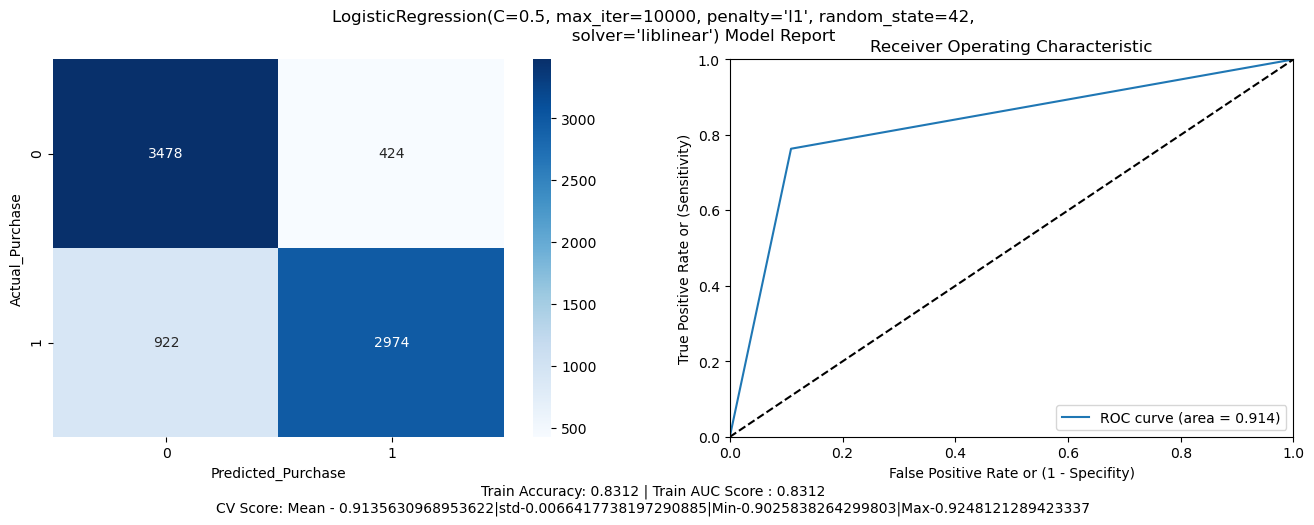

In [139]:
fit_model(X_full,y_full,final_model,10,"roc_auc",True)

In [138]:
pd.DataFrame(final_model.coef_,columns=X_full.columns).T.rename(columns={0:"Coefficient"}).\
sort_values(by="Coefficient",ascending=False)

Coefficient
Dwelling Type_missing                             9.658295
is_between_2014_2018                              1.156969
car_purchase_year_between_15_20                   0.917638
some_colleges_2014_2018                           0.330107
Home Ownership_missing                            0.315487
Retail                                            0.310079
owners_less_than_2                                0.143058
Number of persons in Household                    0.081611
Dwelling Type_Multi Family Dwelling/Apartment     0.051751
longer_than_2000                                  0.046772
Median Income                                     0.020616
Gender Code_Male                                  0.011246
Marital Status_Married                            0.003163
Home Ownership_Probable Home Owner                0.000000
Home Ownership_Home Owner                         0.000000
Dwelling Type_Single Family                       0.000000
Length of Residence                              -0.003920
Marital Status_Single                            -0.006085
Age                                              -0.024320
Estimated Current Odometer                       -0.040614
Education Level                                  -0.045911
Marital Status_missing                           -0.180041
Dwelling Type_PO Box                             -0.233225
Gender Code_Female                               -0.274713
Home Ownership_Renter                            -0.287436
Year                                             -0.313789
Number Of Owners                                 -0.341379
car_purchase_year                                -1.300398
Last Owner Length Of Ownership In Days           -1.602849
Gender Code_missing                              -3.367289

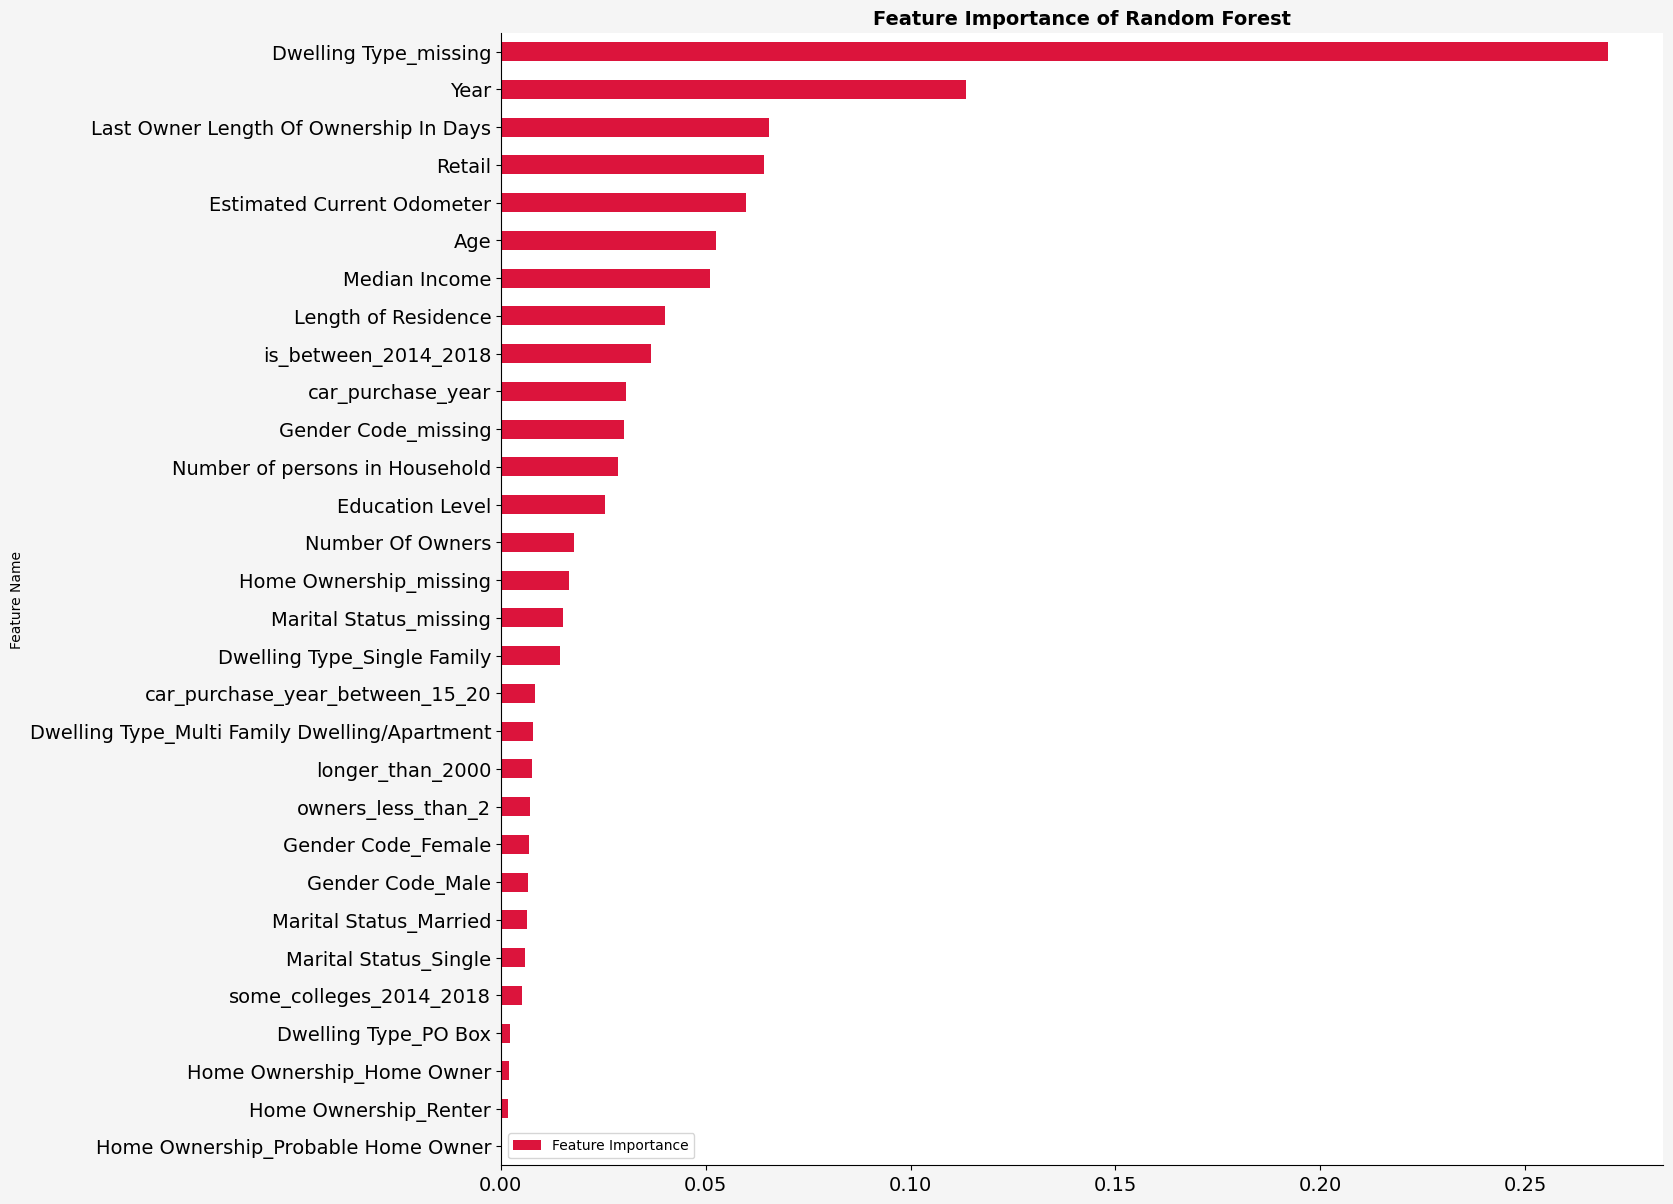

In [132]:
rf_clf = RandomForestClassifier().fit(X_full,y_full)
temp = pd.DataFrame({"Feature Name":X_full.columns,
              "Feature Importance":rf_clf.feature_importances_}).sort_values(by="Feature Importance")

fig,ax = plt.subplots(1,1,figsize=(15,15),dpi=100,facecolor="whitesmoke")
temp.plot(x="Feature Name",y="Feature Importance",kind="barh",color="crimson",ax=ax)
ax.set_title("Feature Importance of Random Forest",weight="bold",fontsize=14)
for i in ["right","top"]:
    ax.spines[i].set_visible(False)
ax.tick_params(labelsize=14)
plt.legend(loc="best")
plt.show()